# Final Excercise

In this notebook, you will find the last exercise of the lecture:
You are handed an initial dataset with several features and a univariate target. Next, you have to decide how to proceed. Since you do not have enough data to yet construct a classifier/predictor of any sensible evaluation metrics, the first task is, therefore, to acquire more data. For this purpose you can obtain batches of data according to your own design of experiments, so you will need to decide which experiments you consider necessary to perform. 

You will have four opportunities to acquire more data. Each time you have to decide which experiments to run and send those to Franz Götz-Hahn as a CSV file. The deadlines are 16.06.2023, 23.06.2023, 30.06.2023, and 07.07.2023 and 12:00 (noon). The format in all cases is a table with one row for each choosable feature, and the column entries corresponding to the desired values. Each individual sample will take approximately 30min, so pick a reasonable amount of experiments. For example, you will get the result for 100 experiments roughly 50 hours after the respective deadline. Should the experiment not be conductible, you will get a ``None`` as a result, e.g., if a feature value is out of range.

Once you have your data, you should compare the performance of different classifiers in predicting the targets. The classifiers to compare are [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). You should utilize all the different parts of the E2ML lecture that you considern appropriate. This could include Data Preprocessing, Design of Experiments for the batches, deciding on Performance Measures, Statistical Significance Testing of a hypothesis, Design of Experiments for Hyperparameter Optimization.

Should you wish to present the results from this excercise in the oral examination, you need to hand in your entire package until 14.07.2023-23:59 as a GitHub Repository. Send the link to the (public) repository to Franz Götz-Hahn via [E-Mail](mailto:franz.goetz-hahn@uni-kassel.de). Please use the README of the repository to describe the structure of the package, include any required packages in the setup.py, add the data in the data subfolder, save any results in the results subfolder, and include a _descriptive_ jupyter notebook in the notebooks subfolder.

Do note, that the point of this excercise is **not** to achieve the best performance of your models, but rather to document your process and give the motivation behind your chosen approaches, _even the ones that failed_.

In [278]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns

In [279]:
# Cheeky hack to make document more readable by suppressing warnings
# NOT RECOMMENDED
import warnings
warnings.filterwarnings('ignore')

In [280]:
# Max iterations for every loop to prevent infinite loops
MAX_ITER = 1000

### **Mollusc Classification** <a class="anchor" id="heart"></a>

Your dataset describes some physical measurements of a specific type of molluscs. Your goal is to predict the `Stage of Life` of the mollusc. The data you can get looks as follows:


| Sex	|Length	|Width	|Height|	Weight	|Non_Shell Weight	|Intestine Weight	|Shell Weight	|Stage of Life |
| ---                           | ----   | ----    | ----    | ----   |----             |----    |---- | ---------- |
| {Male (M), Female (F), Indeterminate (I)} | float (inches)     | float (inches)     |  float (inches)     | float (gram)      | float (gram)              | float (gram)     |  float (gram)     | {Child, Adolescent (Adole), Adult}      |

The table headings are identical to the column names in the corresponding CSV-files. 

We can send out divers that look for molluscs that fit your needs, which will subsequently be analyzed in a laboratory. You can request molluscs with all features except the Stage of Life attribute, as it is the target. The first day of diving has already been completed. After 8 hours of diving, they brought up the following molluscs:

In [281]:
initial_molluscs_data = pd.read_csv("../data/initial_molluscs_data.csv")
initial_molluscs_data

Sex  Length  Width  Height  Weight  Non_Shell Weight  Intestine Weight  \
0    F   0.450  0.345   0.120  0.4165            0.1655            0.0950   
1    F   0.475  0.380   0.145  0.5700            0.1670            0.1180   
2    M   0.610  0.485   0.170  1.0225            0.4190            0.2405   
3    I   0.430  0.340   0.105  0.4405            0.2385            0.0745   
4    M   0.205  0.155   0.045  0.0425            0.0170            0.0055   
5    M   0.600  0.475   0.175  1.3445            0.5490            0.2875   
6    I   0.515  0.390   0.110  0.5310            0.2415            0.0980   
7    F   0.625  0.495   0.160  1.1115            0.4495            0.2825   
8    F   0.650  0.520   0.195  1.6275            0.6890            0.3905   
9    F   0.620  0.480   0.165  1.0430            0.4835            0.2210   
10   F   0.535  0.450   0.135  0.8075            0.3220            0.1810   
11   I   0.385  0.280   0.090  0.2280            0.1025            0.0420   
12   F   0.680  0.560   0.195  1.7775            0.8610            0.3220   
13   F   0.585  0.415   0.155  0.6985            0.3000            0.1460   
14   M   0.525  0.435   0.155  1.0650            0.4860            0.2330   
15   M   0.660  0.545   0.185  1.3200            0.5305            0.2635   

    Shell Weight Stage of Life  
0         0.1350         Adult  
1         0.1870         Adole  
2         0.3600         Adult  
3         0.1075         Adole  
4         0.0155         Adult  
5         0.3600         Child  
6         0.1615         Adult  
7         0.3450         Child  
8         0.4320         Adult  
9         0.3100         Adult  
10        0.2500         Adole  
11        0.0655         Adult  
12        0.4150         Adole  
13        0.1950         Adole  
14        0.2850         Adult  
15        0.4550         Child

In [282]:
# Quick helper functions for calculating datapoint count and data generation time


def calculate_datapoint_count(duration_days=0, duration_hours=0):
    return (duration_days * 24 + duration_hours) * 2


def calculate_datageneration_time(datapoint_count):
    return datapoint_count / 2 / 24

### Initial data analysis

In [283]:
# Create copy of initial data
molluscs_data = initial_molluscs_data.copy()

In [284]:
from sklearn import preprocessing
"""
# Add numeric values for Sex and Stage of life
def sex_to_num(data):
    if type(data) == pd.Series:
        return sex_to_num(data["Sex"])
    if data == "M":
        return 1
    elif data == "F":
        return 2
    elif data == "I":
        return 0
    else:
        return -1


molluscs_data["Sex_Num"] = molluscs_data.apply(lambda row: sex_to_num(row), axis=1)


def stage_to_num(data):
    if type(data) == pd.Series:
        return stage_to_num(data["Stage of Life"])
    if data == "Child":
        return 0
    elif data == "Adole":
        return 1
    elif data == "Adult":
        return 2
    else:
        return -1

molluscs_data["Stage_Num"] = molluscs_data.apply(lambda row: stage_to_num(row), axis=1)
"""

def encode_labels(data, encoders_dict = None, key = None):
    """
    Encodes labels of categorical data to numeric values.

    Parameters
    ----------
    data : pandas.DataFrame, pandas.Series, any
        Data to encode.
        If pandas.DataFrame or pandas.Series, all columns will be encoded.
        If any other type, it will be encoded using the encoder with key.
    encoders_dict : dict, optional
        Dictionary of encoders to use. If not provided, new encoders will be created.
    key : any, optional
        Key of the encoder to use. Required if encoders_dict is not None.

    Returns
    -------
    pandas.DataFrame
        Encoded data.
    dict
        Dictionary of encoders used.
    """
    if encoders_dict is None:
        encoders_dict = {}
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        data = data.copy()
        for column in data.columns:
            if data[column].dtype == object:
                if column not in encoders_dict:
                    encoders_dict[column] = preprocessing.LabelEncoder()
                    encoders_dict[column].fit(data[column])
                data[column] = encoders_dict[column].transform(data[column])
    else:
        if type(data) == str or type(data) == int:
            data = [data]
        if key == None:
            return data, encoders_dict
        if key not in encoders_dict.keys():
            encoders_dict[key] = preprocessing.LabelEncoder()
            encoders_dict[key].fit(data)
        data = encoders_dict[key].transform(data)
    return data, encoders_dict

def decode_labels(data, encoders_dict, key = None):
    """
    Decodes labels of categorical data from numeric values.

    Parameters
    ----------
    data : pandas.DataFrame, pandas.Series, any
        Data to decode.
        If pandas.DataFrame or pandas.Series, all columns will be decoded.
        If any other type, it will be decoded using the encoder with key.
    encoders_dict : dict
        Dictionary of encoders to use.
    key : any, optional
        Key of the encoder to use. Required if data is not pandas.DataFrame or pandas.Series.
        
    Returns
    -------
    pandas.DataFrame
        Decoded data.
    """
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        data = data.copy()
        for column in data.columns:
            if column in encoders_dict.keys():
                try:
                    data[column] = encoders_dict[column].inverse_transform(data[column])
                except ValueError:
                    print(f"Error decoding column {column} with encoder {encoders_dict[column]} and unique data {data[column].unique()}")
    else:
        if type(data) == str or type(data) == int:
            data = [data]
        if key == None:
            return data
        if key in encoders_dict.keys():
            data = encoders_dict[key].inverse_transform(data)
    return data

In [285]:
# Scale numeric values
def scale_numeric(data, scaler_dict = None, key = None):
    """
    Scales numeric values of data.

    Parameters
    ----------
    data : pandas.DataFrame, pandas.Series, any
        Data to scale.
        If pandas.DataFrame or pandas.Series, all columns will be scaled.
        If any other type, it will be scaled using the scaler with key.
    scaler_dict : dict, optional
        Dictionary of scalers to use. If not provided, new scalers will be created.
    key : any, optional
        Key of the scaler to use. Required if scaler_dict is not None.
        If data is pandas.DataFrame or pandas.Series, key is list of columns to keep.

    Returns
    -------
    pandas.DataFrame
        Scaled data.
    dict
        Dictionary of scalers used.
    """
    if scaler_dict is None:
        scaler_dict = {}
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        data = data.copy()
        for column in data.columns:
            if key is not None and column in key:
                continue
            if data[column].dtype == float or data[column].dtype == int:
                if column not in scaler_dict:
                    scaler_dict[column] = preprocessing.MinMaxScaler()
                    scaler_dict[column].fit(data[column].values.reshape(-1, 1))
                data[column] = scaler_dict[column].transform(data[column].values.reshape(-1, 1))
    else:
        if type(data) == float or type(data) == int:
            data = [data]
        if key == None:
            return data, scaler_dict
        if key not in scaler_dict.keys():
            scaler_dict[key] = preprocessing.MinMaxScaler()
            scaler_dict[key].fit(data)
        data = scaler_dict[key].transform(data)
    return data, scaler_dict

def unscale_numeric(data, scaler_dict, key = None):
    """
    Unscales numeric values of data.

    Parameters
    ----------
    data : pandas.DataFrame, pandas.Series, any
        Data to unscale.
        If pandas.DataFrame or pandas.Series, all columns will be unscaled.
        If any other type, it will be unscaled using the scaler with key.
    scaler_dict : dict
        Dictionary of scalers to use.
    key : any, optional
        Key of the scaler to use. Required if data is not pandas.DataFrame or pandas.Series.
        If data is pandas.DataFrame or pandas.Series, key is list of columns to keep.

    Returns
    -------
    pandas.DataFrame
        Unscaled data.
    """
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        data = data.copy()
        for column in data.columns:
            if key is not None and column in key:
                continue
            if column in scaler_dict.keys():
                data[column] = scaler_dict[column].inverse_transform(np.array(data[column]).reshape(1, -1)).reshape(-1)
    else:
        if type(data) == float or type(data) == int:
            data = [data]
        if key == None:
            return data
        if key in scaler_dict.keys():
            data = scaler_dict[key].inverse_transform(data)
    return data

In [286]:
molluscs_data, label_encoders = encode_labels(molluscs_data)

In [287]:
# Analyze the data
molluscs_data.describe()

Sex     Length      Width     Height     Weight  \
count  16.000000  16.000000  16.000000  16.000000  16.000000   
mean    0.812500   0.534375   0.421875   0.144062   0.877875   
std     0.910586   0.124176   0.105560   0.041240   0.496578   
min     0.000000   0.205000   0.155000   0.045000   0.042500   
25%     0.000000   0.468750   0.371250   0.117500   0.508375   
50%     0.500000   0.560000   0.442500   0.155000   0.915000   
75%     2.000000   0.621250   0.487500   0.171250   1.163625   
max     2.000000   0.680000   0.560000   0.195000   1.777500   

       Non_Shell Weight  Intestine Weight  Shell Weight  Stage of Life  
count         16.000000         16.000000     16.000000      16.000000  
mean           0.376344          0.187531      0.254938       0.875000  
std            0.224390          0.109644      0.135996       0.718795  
min            0.017000          0.005500      0.015500       0.000000  
25%            0.220625          0.097250      0.154875       0.000000  
50%            0.370500          0.201000      0.267500       1.000000  
75%            0.497125          0.268250      0.360000       1.000000  
max            0.861000          0.390500      0.455000       2.000000

In [288]:
# Split dataset

def split_dataset(data, feature):
    """
    Splits dataset into a dictionary of datasets based on a feature.

    Parameters
    ----------
    data : pandas.DataFrame
        Dataset to split.
    feature : str
        Feature to split on.

    Returns
    -------
    dict
        Dictionary of datasets.
    """
    data_dict = {value : data[data[feature] == value] for value in data[feature].unique()}
    return data_dict

In [289]:
molluscs_data_dict = split_dataset(molluscs_data, "Sex")
molluscs_data_dict

{0:     Sex  Length  Width  Height  Weight  Non_Shell Weight  Intestine Weight  \
 0     0   0.450  0.345   0.120  0.4165            0.1655            0.0950   
 1     0   0.475  0.380   0.145  0.5700            0.1670            0.1180   
 7     0   0.625  0.495   0.160  1.1115            0.4495            0.2825   
 8     0   0.650  0.520   0.195  1.6275            0.6890            0.3905   
 9     0   0.620  0.480   0.165  1.0430            0.4835            0.2210   
 10    0   0.535  0.450   0.135  0.8075            0.3220            0.1810   
 12    0   0.680  0.560   0.195  1.7775            0.8610            0.3220   
 13    0   0.585  0.415   0.155  0.6985            0.3000            0.1460   
 
     Shell Weight  Stage of Life  
 0          0.135              1  
 1          0.187              0  
 7          0.345              2  
 8          0.432              1  
 9          0.310              1  
 10         0.250              0  
 12         0.415              0  
 13 

In [290]:
# Calculate means and standard deviations

def claculate_means_stds_feature(data, feature):
    """
    Calculates means and standard deviations of a feature in a dictionary of datasets.

    Parameters
    ----------
    data_dict : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to calculate means and standard deviations for.
    feature : str
        Feature to calculate means and standard deviations for.

    Returns
    -------
    dict
        Dictionary of means and standard deviations.
    """
    means_stds_dict = {}
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        means_stds_dict["mean"] = data[feature].mean()
        means_stds_dict["std"] = data[feature].std()
    elif type(data) == dict:
        for key in data.keys():
            means_stds_dict[key] = {}
            means_stds_dict[key]["mean"] = data[key][feature].mean()
            means_stds_dict[key]["std"] = data[key][feature].std()
    return means_stds_dict

def calculate_means_stds(data, skip_features = None, reverse=False):
    """
    Calculates means and standard deviations of all features in a dictionary of datasets.

    Parameters
    ----------
    data_dict : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to calculate means and standard deviations for.
    skip_features : list, optional
        List of features to skip.
    reverse : bool, optional
        If True, reverse order of the returned dictionary.
        Default is feature -> mean/std
        If True, mean/std -> feature

    Returns
    -------
    dict
        Dictionary of means and standard deviations.
    """
    means_stds_dict = {}
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        if reverse:
            means_stds_dict["std"] = {}
            means_stds_dict["mean"] = {}
        for column in data.columns:
            if skip_features is not None and column in skip_features:
                continue
            if reverse:
                means_stds_dict["std"][column] = data[column].std()
                means_stds_dict["mean"][column] = data[column].mean()
            else:
                means_stds_dict[column] = {}
                means_stds_dict[column]["mean"] = data[column].mean()
                means_stds_dict[column]["std"] = data[column].std()
    elif type(data) == dict:
        for key in data.keys():
            means_stds_dict[key] = {}
            if reverse:
                means_stds_dict[key]["mean"] = {}
                means_stds_dict[key]["std"] = {}
            for column in data[key].columns:
                if skip_features is not None and column in skip_features:
                    continue
                if reverse:
                    means_stds_dict[key]["std"][column] = data[key][column].std()
                    means_stds_dict[key]["mean"][column] = data[key][column].mean()
                else:
                    means_stds_dict[key][column] = {}
                    means_stds_dict[key][column]["mean"] = data[key][column].mean()
                    means_stds_dict[key][column]["std"] = data[key][column].std()
    return means_stds_dict

def split_means_stds_dict(means_stds_dict):
    """
    Splits a means and standard deviations dictionary into two dictionaries.

    Parameters
    ----------
    means_stds_dict : dict
        Means and standard deviations dictionary to split.

    Returns
    -------
    dict, dict
        Two dictionaries of means and standard deviations.
    """
    means_dict = {}
    stds_dict = {}
    for key in means_stds_dict.keys():
        means_dict[key] = {}
        stds_dict[key] = {}
        for feature in means_stds_dict[key].keys():
            means_dict[key][feature] = means_stds_dict[key][feature]["mean"]
            stds_dict[key][feature] = means_stds_dict[key][feature]["std"]
    return means_dict, stds_dict

In [291]:
# Calculate means and standard deviations for each feature
molluscs_data_ms = calculate_means_stds(molluscs_data)
molluscs_data_sex_ms = calculate_means_stds(molluscs_data_dict)
molluscs_data_means, molluscs_data_stds = split_means_stds_dict(molluscs_data_sex_ms)
molluscs_data_ms, molluscs_data_sex_ms, molluscs_data_means, molluscs_data_stds

({'Sex': {'mean': 0.8125, 'std': 0.9105858919765157},
  'Length': {'mean': 0.534375, 'std': 0.12417561489009561},
  'Width': {'mean': 0.421875, 'std': 0.10556001452570318},
  'Height': {'mean': 0.14406249999999998, 'std': 0.04123989775286387},
  'Weight': {'mean': 0.877875, 'std': 0.4965779730649894},
  'Non_Shell Weight': {'mean': 0.37634375, 'std': 0.22438981845217487},
  'Intestine Weight': {'mean': 0.18753124999999998,
   'std': 0.10964373652121372},
  'Shell Weight': {'mean': 0.25493750000000004, 'std': 0.13599557284460892},
  'Stage of Life': {'mean': 0.875, 'std': 0.7187952884282609}},
 {0: {'Sex': {'mean': 0.0, 'std': 0.0},
   'Length': {'mean': 0.5775, 'std': 0.08319512348346249},
   'Width': {'mean': 0.45562500000000006, 'std': 0.072527704066397},
   'Height': {'mean': 0.15875, 'std': 0.026558560632254584},
   'Weight': {'mean': 1.0065, 'std': 0.48778456895876254},
   'Non_Shell Weight': {'mean': 0.4296875, 'std': 0.2460478956713219},
   'Intestine Weight': {'mean': 0.2195, '

In [292]:
# Plot pdf and cdf
def plot_distribution(data, name="dataset", skip_features=None, subplot=False, distribution_type="pdf"):
    """
    Plots probability density function or cumulative distribution function for each feature in a dictionary of datasets.

    Parameters
    ----------
    data : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to plot probability density function or cumulative distribution function for.
    name : str, optional
        Name of the dataset.
    skip_features : list, optional
        List of features to skip.
    subplot : bool, optional
        Whether to plot all features in one plot or each feature in a separate plot.
    distribution_type : str, optional
        Type of distribution to plot. Can be "pdf" for probability density function or "cdf" for cumulative distribution function.
    """
    figsize = (20, 15)
    axs = None
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        if subplot:
            fig, axs = plt.subplots(len(data.columns) // 3, 3, figsize=figsize)
        else:
            fig = plt.figure(figsize=figsize)
        for idx, column in enumerate(data.columns):
            if skip_features is not None and column in skip_features:
                continue
            if distribution_type == "pdf":
                distribution = norm.pdf(
                    data[column].sort_values(), data[column].mean(), data[column].std()
                )
            elif distribution_type == "cdf":
                distribution = norm.cdf(
                    data[column].sort_values(), data[column].mean(), data[column].std()
                )
            else:
                raise ValueError("Invalid distribution type. Must be 'pdf' or 'cdf'.")
            if subplot and axs is not None:
                ax = axs[idx // 3, idx % 3]
                ax.plot(data[column].sort_values(), distribution, label=column)
                ax.set_title(f"{distribution_type.upper()} of {column} in {name}")
                ax.legend()
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel(distribution_type.upper())
            else:
                plt.plot(data[column].sort_values(), distribution, label=column)
        if not subplot:
            plt.title(f"{distribution_type.upper()} of {name}")
            plt.legend()
            plt.grid()
            plt.xlabel("Feature")
            plt.ylabel(distribution_type.upper())
    elif type(data) == dict:
        if subplot:
            fig, axs = plt.subplots(
                len(next(iter(data.values())).columns), len(data.keys()), figsize=figsize
            )
        else:
            fig, axs = plt.subplots(len(data.keys()) // 3, 3, figsize=figsize)
            if len(axs.shape) == 1:
                axs = axs.reshape(1, -1)
        for idx, key in enumerate(data.keys()):
            for jdx, column in enumerate(data[key].columns):
                if skip_features is not None and column in skip_features:
                    continue
                if distribution_type == "pdf":
                    distribution = norm.pdf(
                        data[key][column].sort_values(),
                        data[key][column].mean(),
                        data[key][column].std(),
                    )
                elif distribution_type == "cdf":
                    distribution = norm.cdf(
                        data[key][column].sort_values(),
                        data[key][column].mean(),
                        data[key][column].std(),
                    )
                else:
                    raise ValueError("Invalid distribution type. Must be 'pdf' or 'cdf'.")
                ax = axs[jdx, idx] if subplot and axs is not None else axs[idx // 3, idx % 3]
                ax.plot(data[key][column].sort_values(), distribution, label=column)
                ax.set_title(f"{distribution_type.upper()} of {column} in {key}")
                ax.legend()
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel(distribution_type.upper())
    plt.title(f'{distribution_type.upper()} of {name}')
    plt.show()

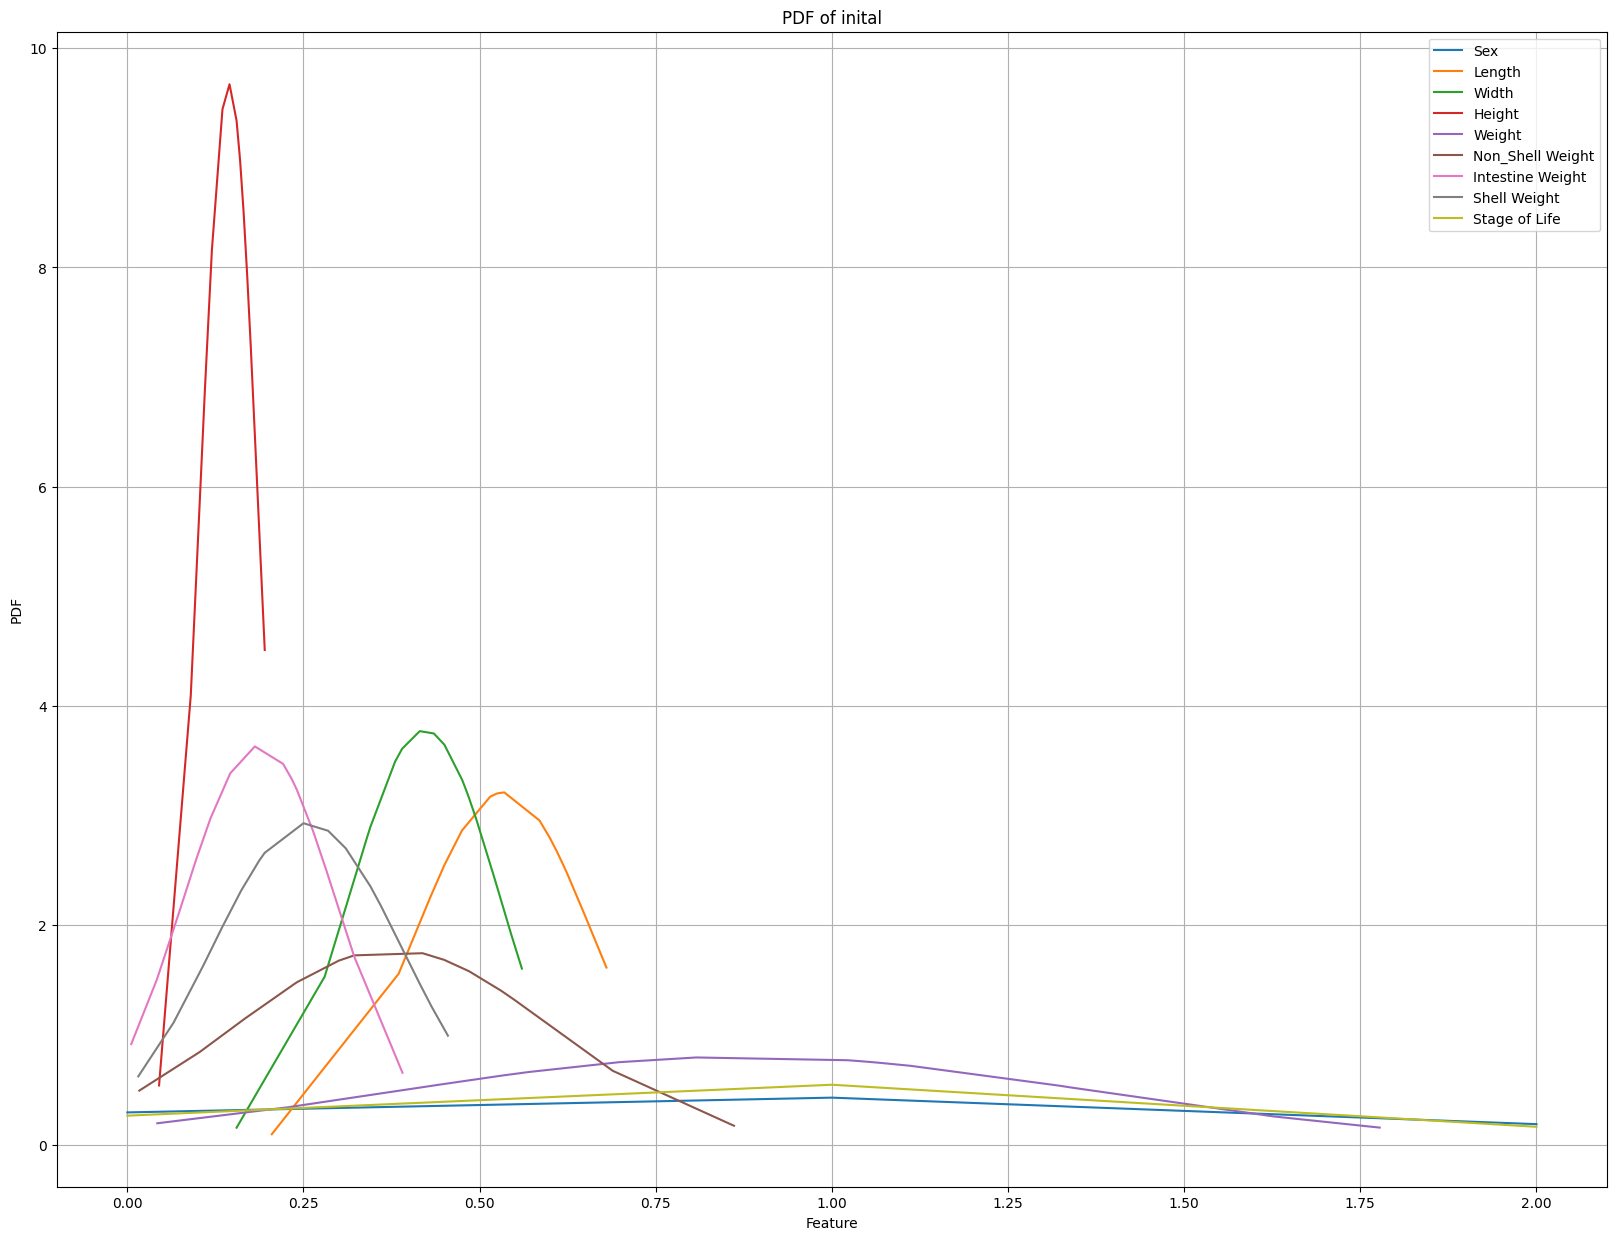

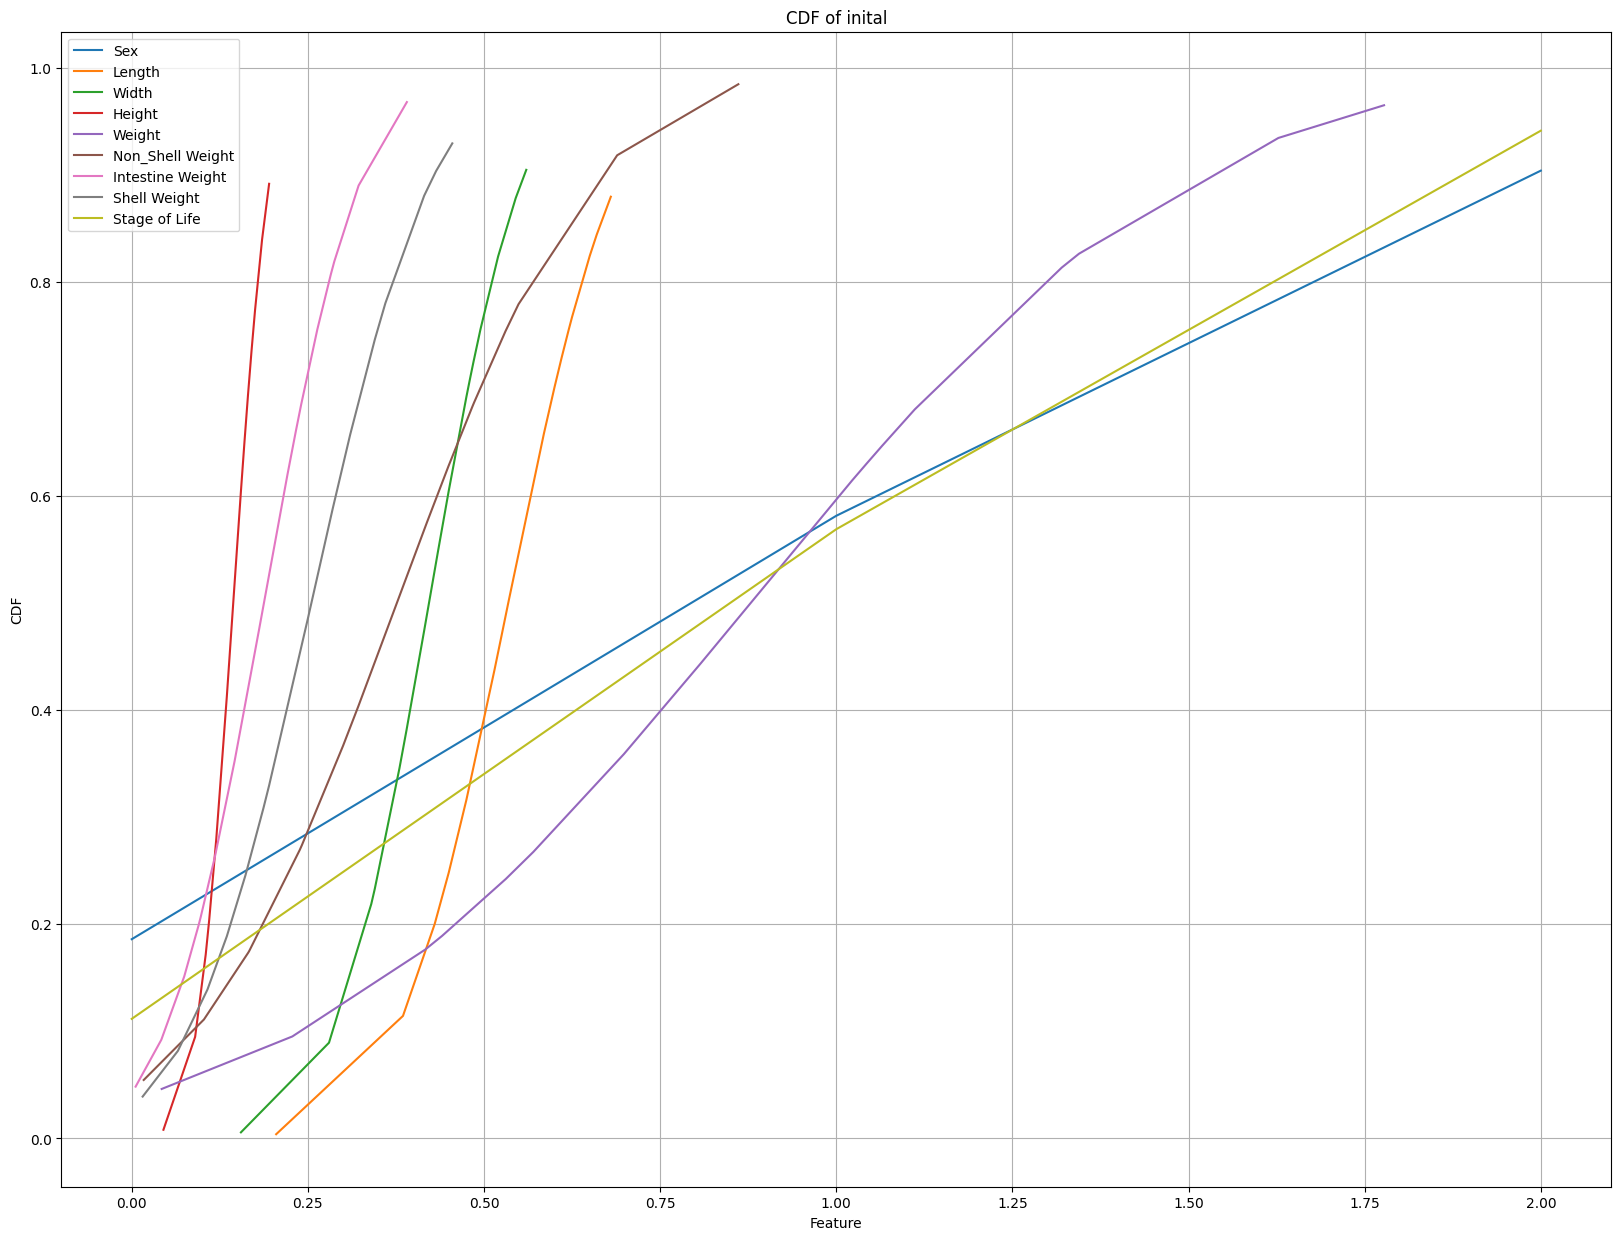

In [293]:
plot_distribution(molluscs_data, "inital", distribution_type="pdf")
plot_distribution(molluscs_data, "inital", distribution_type="cdf")

In [294]:
# Boxplot and Violinplot
def plot_box_violin(data, name="dataset", skip_features=None, subplot=False, plot_type="box"):
    """
    Plots boxplot or violinplot for each feature in a dictionary of datasets.

    Parameters
    ----------
    data : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to plot boxplot or violinplot for.
    name : str, optional
        Name of the dataset.
    skip_features : list, optional
        List of features to skip.
    subplot : bool, optional
        Whether to plot all features in one plot or each feature in a separate plot.
    plot_type : str, optional
        Type of plot to plot. Can be "box" for boxplot or "violin" for violinplot.
    """
    figsize = (20, 15)
    axs = None
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        if subplot:
            fig, axs = plt.subplots(len(data.columns) // 3, 3, figsize=figsize)
        else:
            fig = plt.figure(figsize=figsize)
        for idx, column in enumerate(data.columns):
            if skip_features is not None and column in skip_features:
                continue
            if subplot and axs is not None:
                ax = axs[idx // 3, idx % 3]
                ax.set_title(f"{plot_type.upper()} of {column} in {name}")
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel(plot_type.upper())
            else:
                plt.title(f"{plot_type.upper()} of {name}")
                plt.grid()
                plt.xlabel("Feature")
                plt.ylabel(plot_type.upper())
            if plot_type == "box":
                if subplot and axs is not None:
                    ax.boxplot(data[column])
                else:
                    plt.boxplot(data[column])
            elif plot_type == "violin":
                if subplot and axs is not None:
                    ax.violinplot(data[column])
                else:
                    plt.violinplot(data[column])
            else:
                raise ValueError("Invalid plot type. Must be 'box' or 'violin'.")
    elif type(data) == dict:
        if subplot:
            fig, axs = plt.subplots(
                len(next(iter(data.values())).columns), len(data.keys()), figsize=figsize
            )
        else:
            fig, axs = plt.subplots(len(data.keys()) // 3, 3, figsize=figsize)
            if len(axs.shape) == 1:
                axs = axs.reshape(1, -1)
        for idx, key in enumerate(data.keys()):
            for jdx, column in enumerate(data[key].columns):
                if skip_features is not None and column in skip_features:
                    continue
                ax = axs[jdx, idx] if subplot and axs is not None else axs[idx // 3, idx % 3]
                if plot_type == "box":
                    ax.boxplot(data[key][column])
                elif plot_type == "violin":
                    ax.violinplot(data[key][column])
                else:
                    raise ValueError("Invalid plot type. Must be 'box' or 'violin'.")
                ax.set_title(f"{plot_type.upper()} of {column} in {key}")
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel(plot_type.upper())
    plt.show()

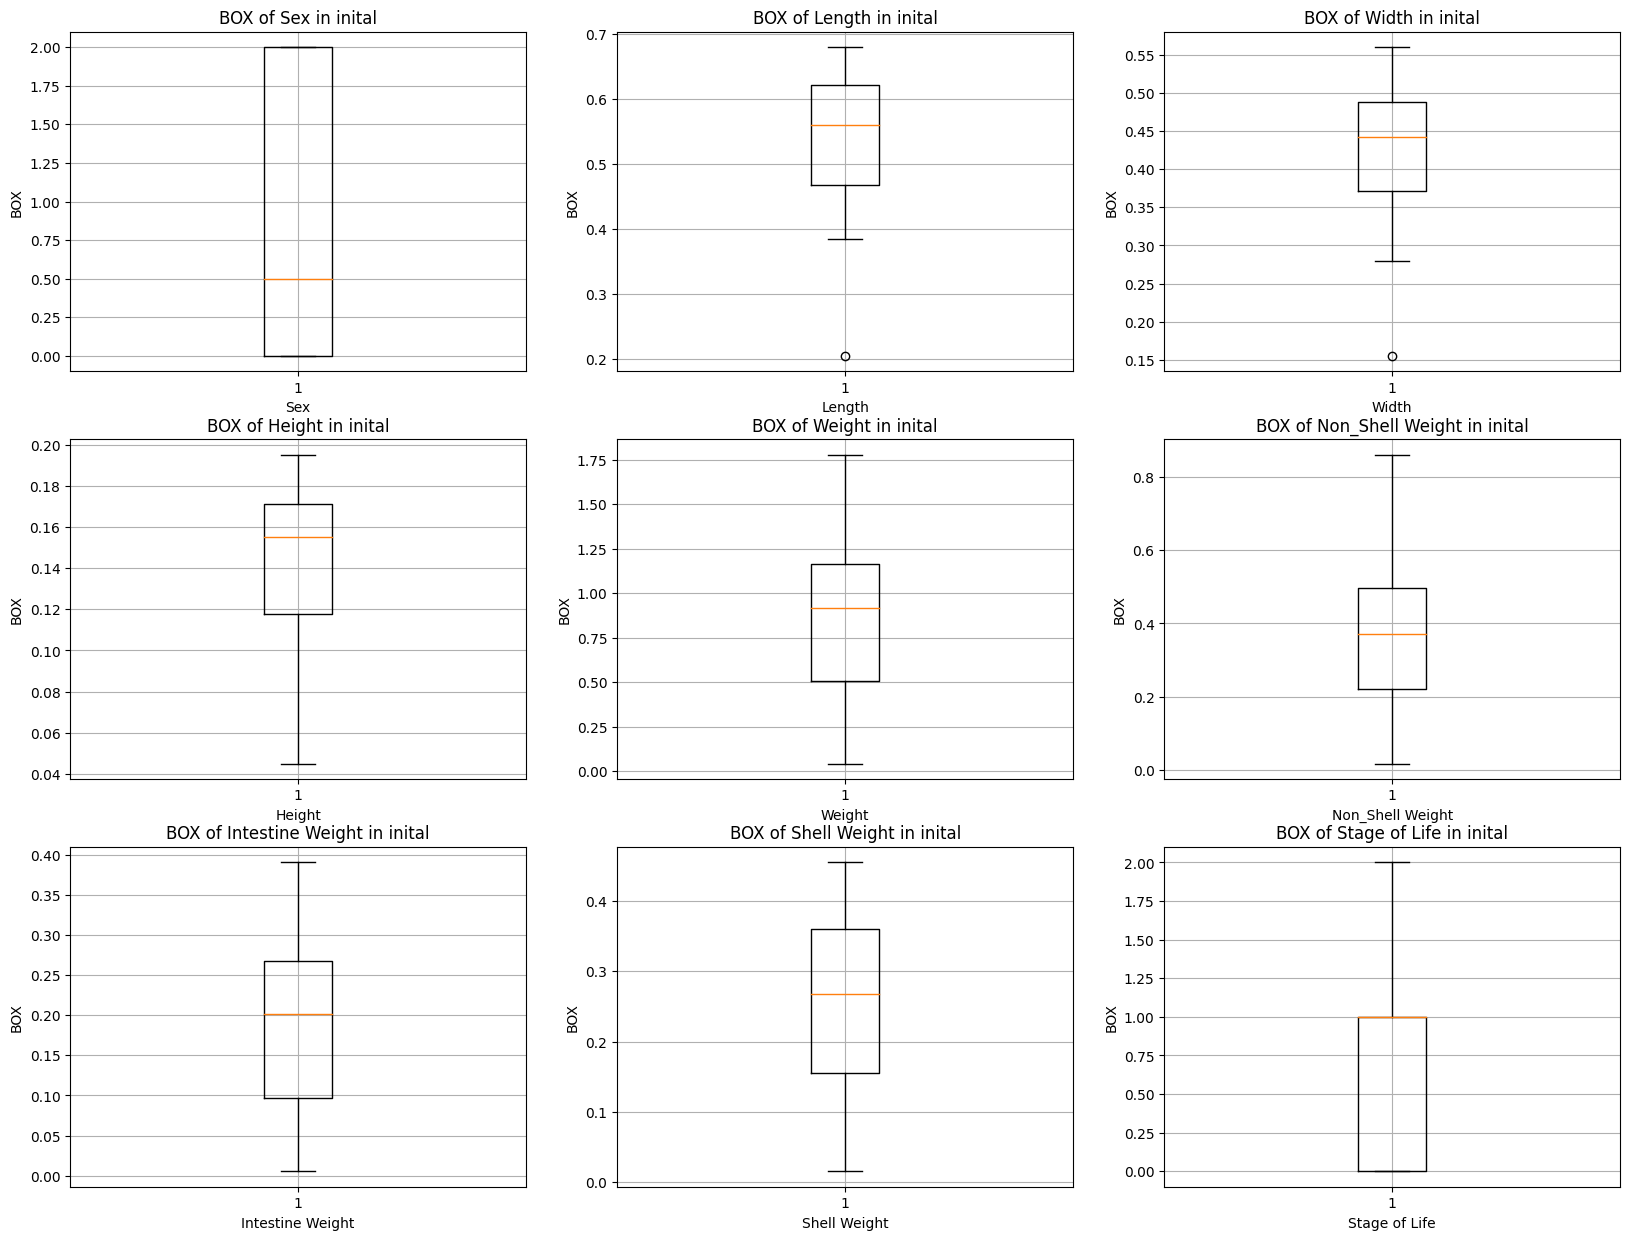

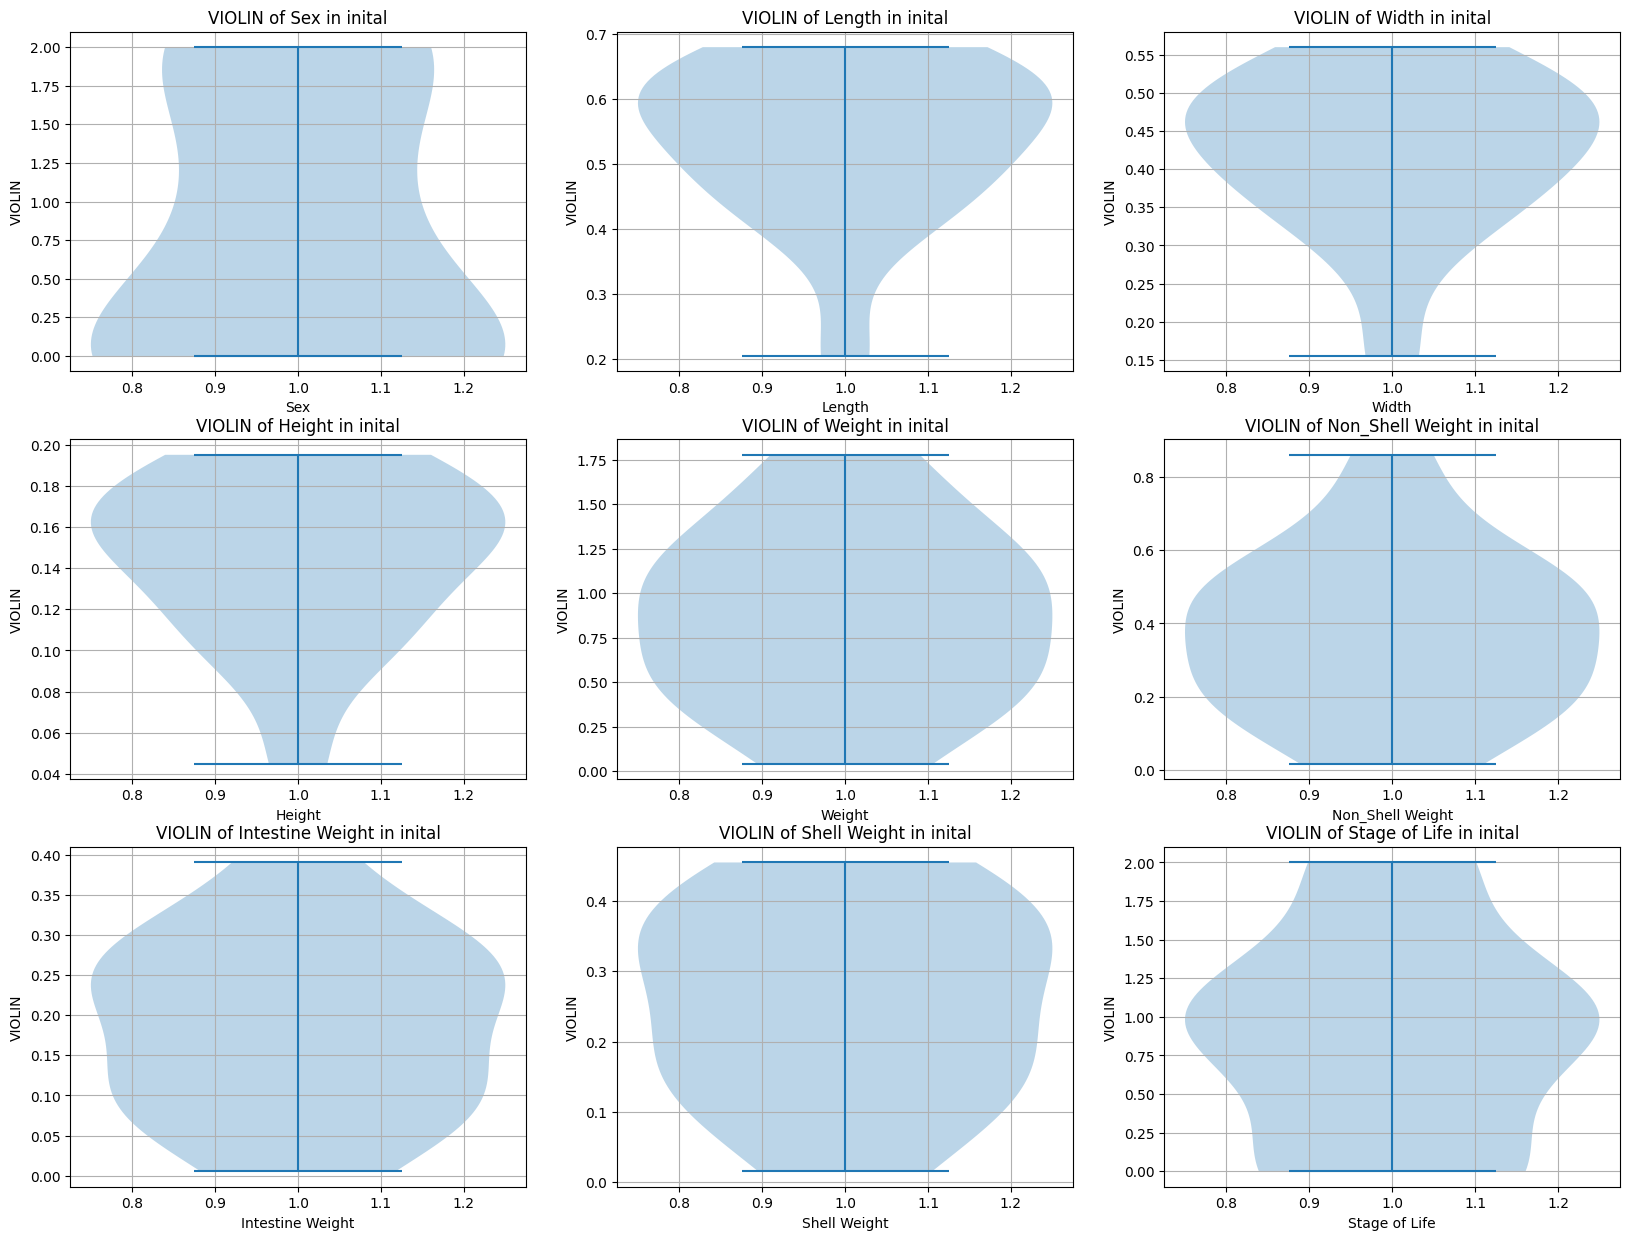

In [295]:
plot_box_violin(molluscs_data, "inital", plot_type="box", subplot=True)
plot_box_violin(molluscs_data, "inital", plot_type="violin", subplot=True)

In [296]:
# Splot histograms
def plot_histogram(data, name="dataset", skip_features=None, subplot=False):
    """
    Plots histogram for each feature in a dictionary of datasets.

    Parameters
    ----------
    data : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to plot histogram for.
    name : str, optional
        Name of the dataset.
    skip_features : list, optional
        List of features to skip.
    subplot : bool, optional
        Whether to plot all features in one plot or each feature in a separate plot.
    """
    figsize = (20, 15)
    axs = None
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        if subplot:
            fig, axs = plt.subplots(len(data.columns) // 3, 3, figsize=figsize)
        else:
            fig = plt.figure(figsize=figsize)
        for idx, column in enumerate(data.columns):
            if skip_features is not None and column in skip_features:
                continue
            if subplot and axs is not None:
                ax = axs[idx // 3, idx % 3]
                ax.hist(data[column])
                ax.set_title(f"Histogram of {column} in {name}")
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel("Frequency")
            else:
                plt.hist(data[column])
                plt.title(f"Histogram of {name}")
                plt.grid()
                plt.xlabel("Feature")
                plt.ylabel("Frequency")
    elif type(data) == dict:
        if subplot:
            fig, axs = plt.subplots(
                len(next(iter(data.values())).columns), len(data.keys()), figsize=figsize
            )
        else:
            fig, axs = plt.subplots(len(data.keys()) // 3, 3, figsize=figsize)
            if len(axs.shape) == 1:
                axs = axs.reshape(1, -1)
        for idx, key in enumerate(data.keys()):
            for jdx, column in enumerate(data[key].columns):
                if skip_features is not None and column in skip_features:
                    continue
                ax = axs[jdx, idx] if subplot and axs is not None else axs[idx // 3, idx % 3]
                ax.set_title(f"Histogram of {column} in {key}")
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel("Frequency")
                ax.hist(data[key][column])
    plt.show()

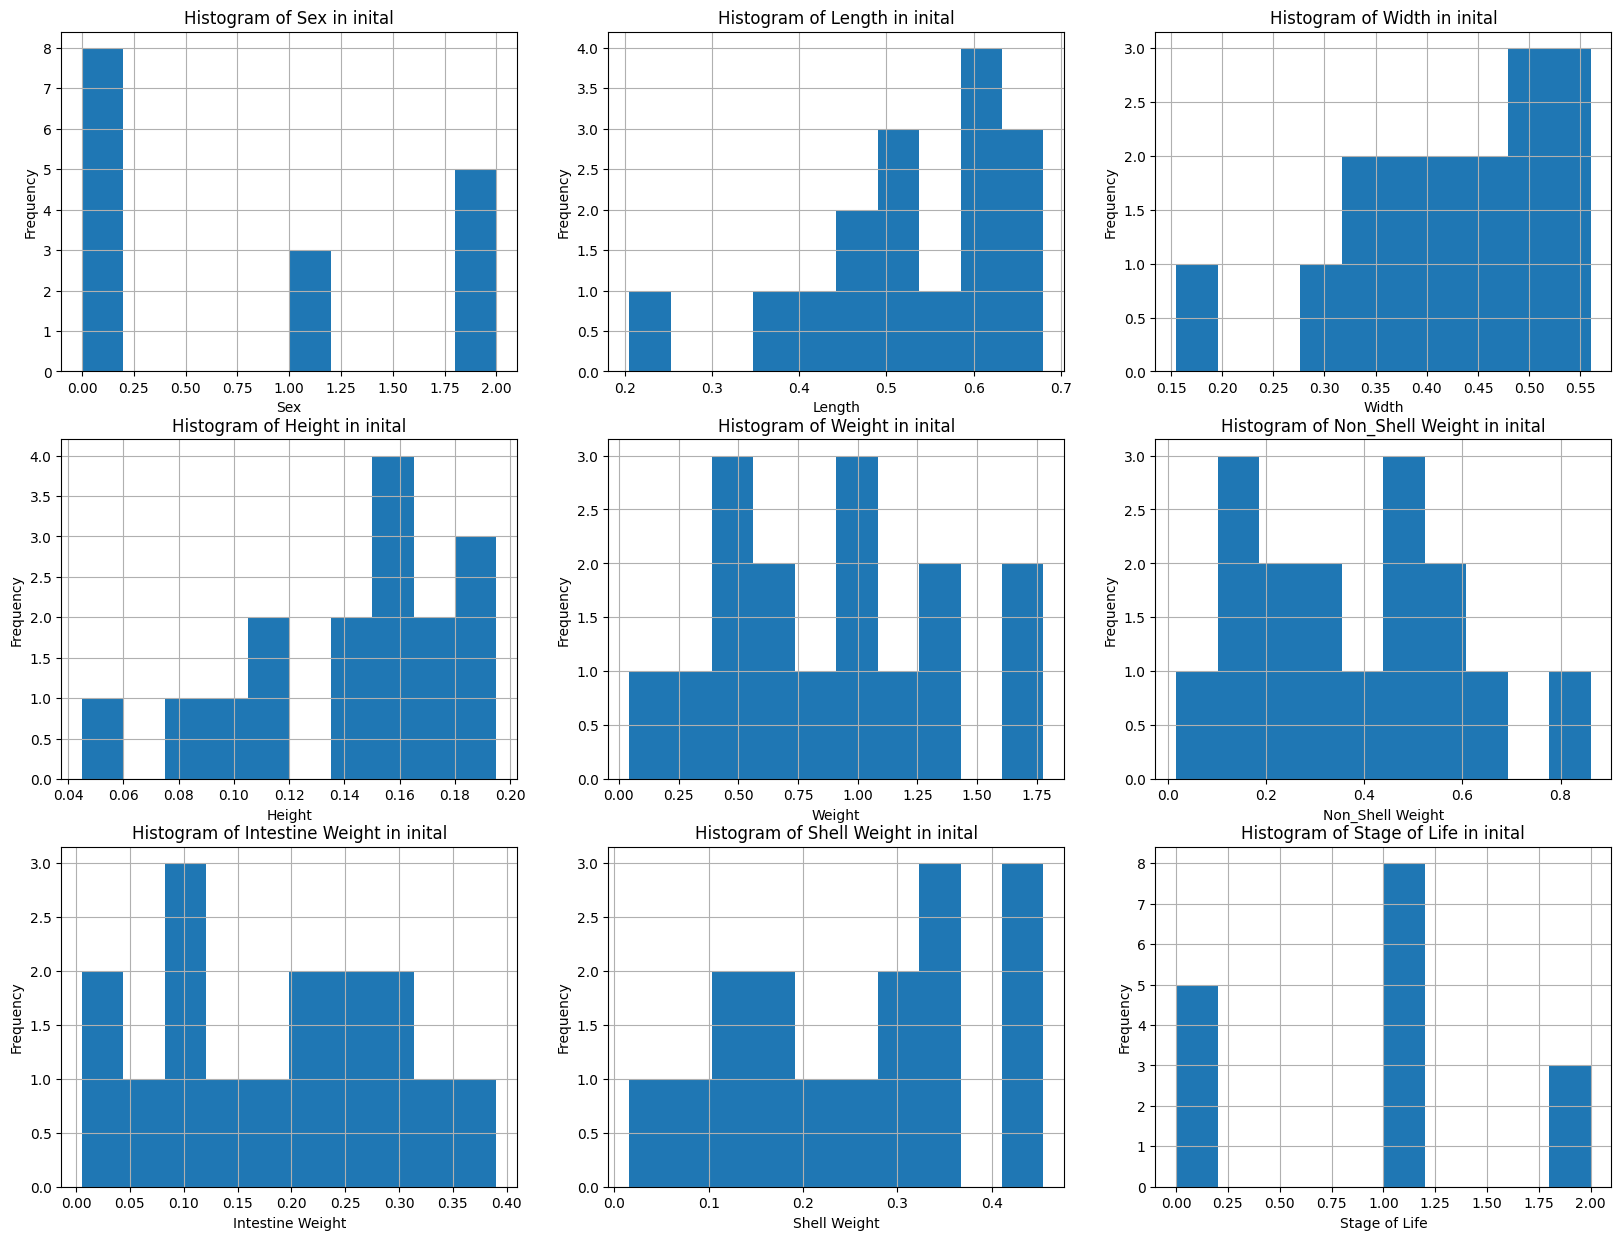

In [297]:
plot_histogram(molluscs_data, "inital", subplot=True)

In [298]:
# Kernel density and scatter plots
import seaborn as sns

def plot_kde(data, name="dataset", skip_features=None, subplot=False):
    """
    Plots kernel density estimation for each feature in a dictionary of datasets.

    Parameters
    ----------
    data : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to plot kernel density estimation for.
    name : str, optional
        Name of the dataset.
    skip_features : list, optional
        List of features to skip.
    subplot : bool, optional
        Whether to plot all features in one plot or each feature in a separate plot.
    """
    figsize = (20, 15)
    axs = None
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        if subplot:
            fig, axs = plt.subplots(len(data.columns) // 3, 3, figsize=figsize)
        else:
            fig = plt.figure(figsize=figsize)
        for idx, column in enumerate(data.columns):
            if skip_features is not None and column in skip_features:
                continue
            if subplot and axs is not None:
                ax = axs[idx // 3, idx % 3]
                sns.kdeplot(data[column], ax=ax)
                ax.set_title(f"Kernel density estimation plot of {column} in {name}")
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel("Frequency")
            else:
                sns.kdeplot(data[column])
                plt.title(f"Kernel density estimation plot of {name}")
                plt.grid()
                plt.xlabel("Feature")
                plt.ylabel("Frequency")
    elif type(data) == dict:
        if subplot:
            fig, axs = plt.subplots(
                len(next(iter(data.values())).columns), len(data.keys()), figsize=figsize
            )
        else:
            fig, axs = plt.subplots(len(data.keys()) // 3, 3, figsize=figsize)
            if len(axs.shape) == 1:
                axs = axs.reshape(1, -1)
        for idx, key in enumerate(data.keys()):
            for jdx, column in enumerate(data[key].columns):
                if skip_features is not None and column in skip_features:
                    continue
                ax = axs[jdx, idx] if subplot and axs is not None else axs[idx // 3, idx % 3]
                sns.kdeplot(data[key][column], ax=ax)
                ax.set_title(f"Kernel density estimation plot of {column} in {key}")
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel("Frequency")
    plt.show()

def plot_scatter(data, name="dataset", skip_features=None, subplot=False):
    """
    Plots scatter plot matrix for each feature in a dictionary of datasets.

    Parameters
    ----------
    data : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to plot scatter plot matrix for.
    name : str, optional
        Name of the dataset.
    skip_features : list, optional
        List of features to skip.
    subplot : bool, optional
        Whether to plot all features in one plot or each feature in a separate plot.
    """
    figsize = (20, 15)
    axs = None
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        if subplot:
            fig, axs = plt.subplots(len(data.columns) // 3, 3, figsize=figsize)
        else:
            fig = plt.figure(figsize=figsize)
        for idx, column in enumerate(data.columns):
            if skip_features is not None and column in skip_features:
                continue
            if subplot and axs is not None:
                ax = axs[idx // 3, idx % 3]
                sns.scatterplot(data=data[column], ax=ax)
                ax.set_title(f"Scatter plot of {column} in {name}")
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel("Frequency")
            else:
                sns.scatterplot(data=data[column])
                plt.title(f"Scatter plot of {name}")
                plt.grid()
                plt.xlabel("Feature")
                plt.ylabel("Frequency")
    elif type(data) == dict:
        if subplot:
            fig, axs = plt.subplots(
                len(next(iter(data.values())).columns), len(data.keys()), figsize=figsize
            )
        else:
            fig, axs = plt.subplots(len(data.keys()) // 3, 3, figsize=figsize)
            if len(axs.shape) == 1:
                axs = axs.reshape(1, -1)
        for idx, key in enumerate(data.keys()):
            for jdx, column in enumerate(data[key].columns):
                if skip_features is not None and column in skip_features:
                    continue
                ax = axs[jdx, idx] if subplot and axs is not None else axs[idx // 3, idx % 3]
                ax.set_title(f"Scatter plot of {column} in {key}")
                ax.grid()
                ax.set_xlabel(column)
                ax.set_ylabel("Frequency")
                sns.scatterplot(data=data[key][column], ax=ax)
    plt.show()

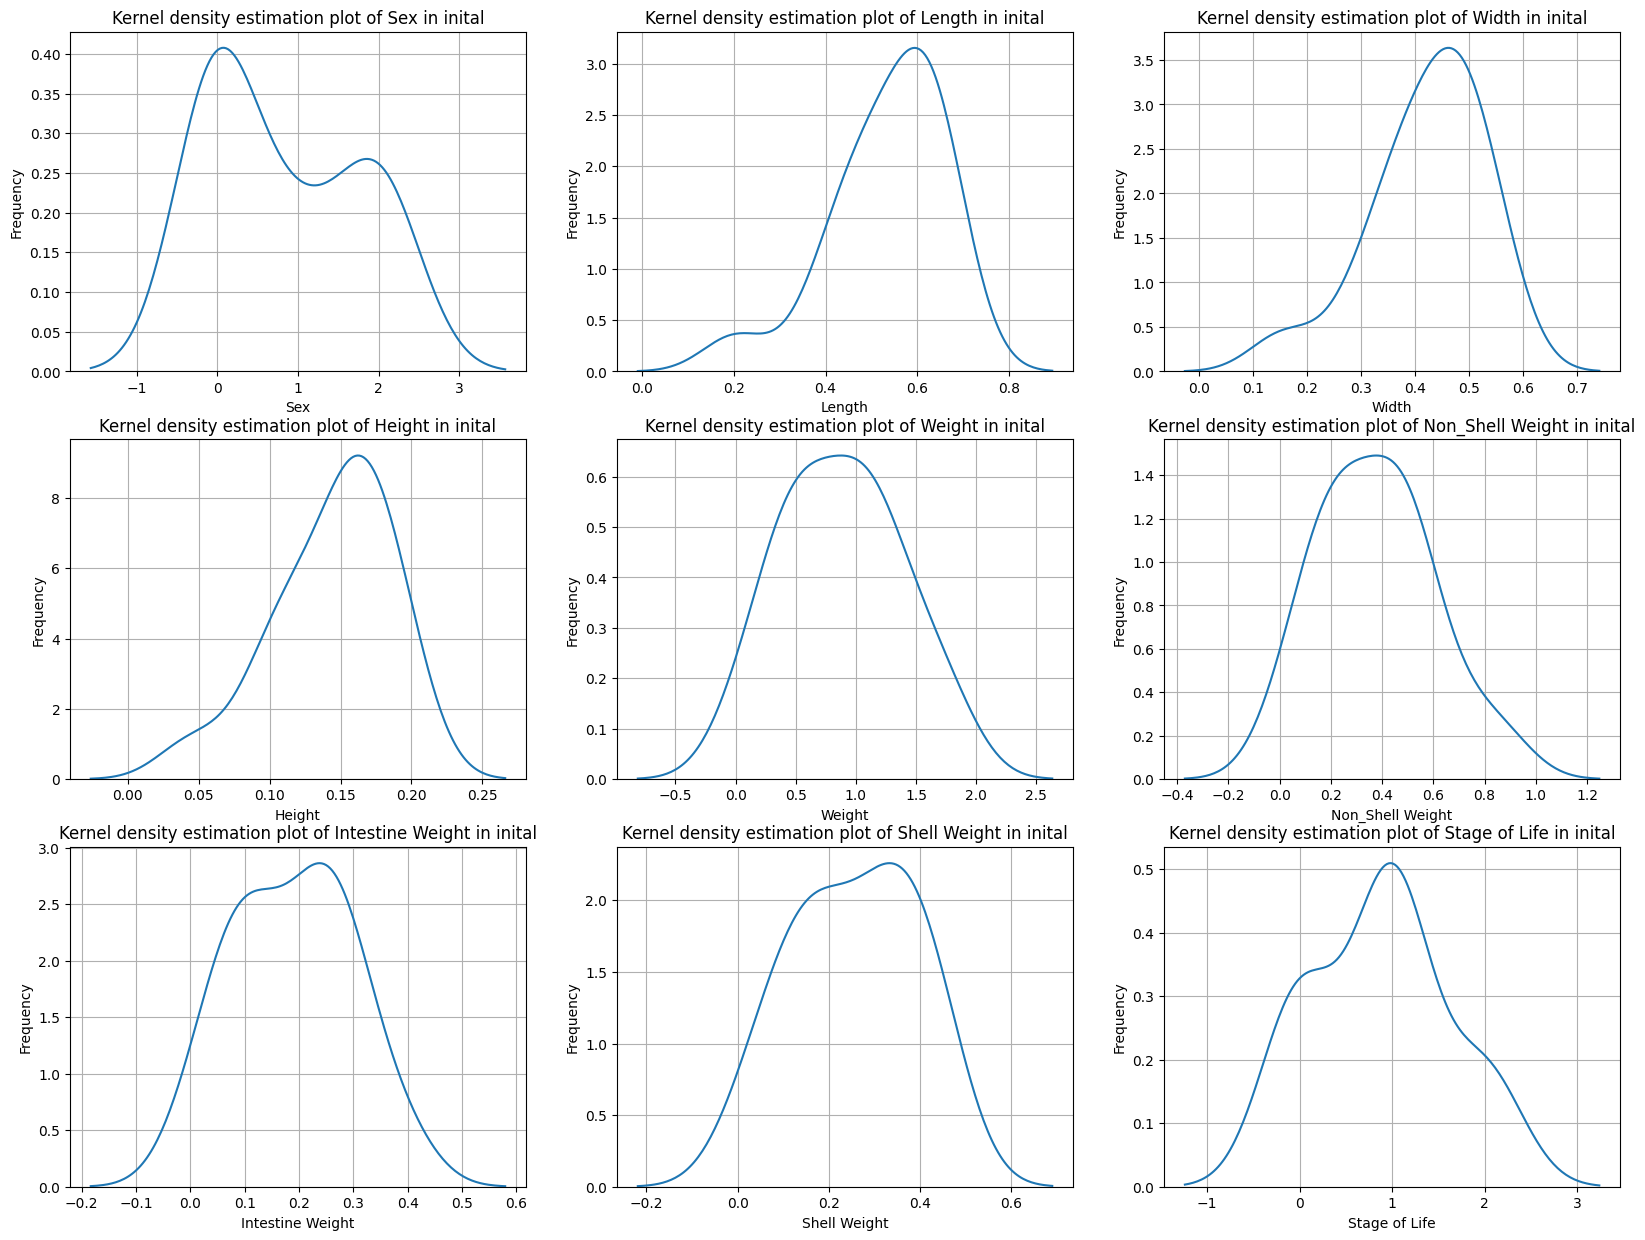

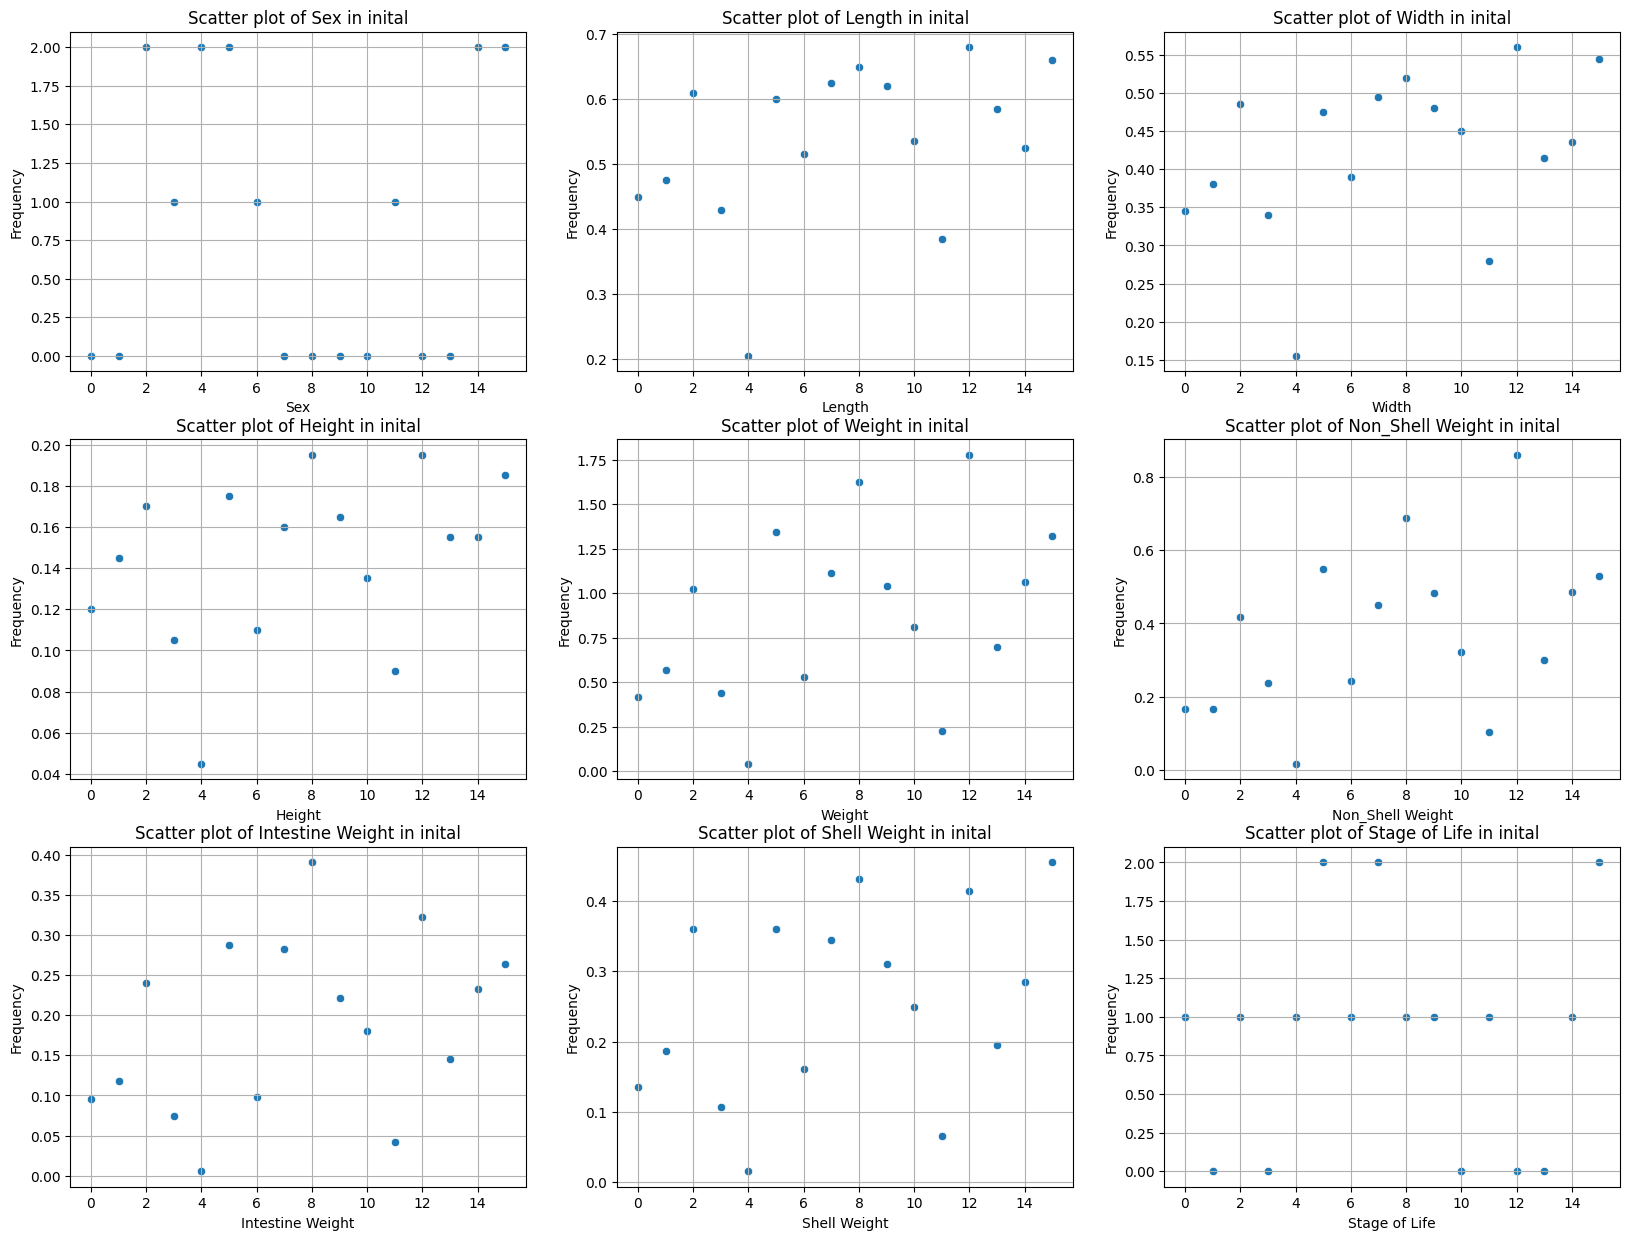

In [299]:
plot_kde(molluscs_data, "inital", subplot=True)
plot_scatter(molluscs_data, "inital", subplot=True)

In [300]:
# Correlation matrix
def plot_correlation_matrix(data, name="dataset", skip_features=None):
    """
    Plots correlation matrix for each feature in a dictionary of datasets.

    Parameters
    ----------
    data : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to plot correlation matrix for.
    name : str, optional
        Name of the dataset.
    skip_features : list, optional
        List of features to skip.
    """
    figsize = (20, 15)
    if type(data) == pd.Series or type(data) == pd.DataFrame:
        fig = plt.figure(figsize=figsize)
        sns.heatmap(data.corr(), annot=True)
        plt.title(f"Correlation matrix of {name}")
        plt.show()
    elif type(data) == dict:
        fig, axs = plt.subplots(len(data.keys()) // 3, 3, figsize=figsize)
        if len(axs.shape) == 1:
            axs = axs.reshape(1, -1)
        for idx, key in enumerate(data.keys()):
            sns.heatmap(data[key].corr(), annot=True, ax=axs[idx // 3, idx % 3])
            axs[idx // 3, idx % 3].set_title(f"Correlation matrix of {key}")
        plt.show()

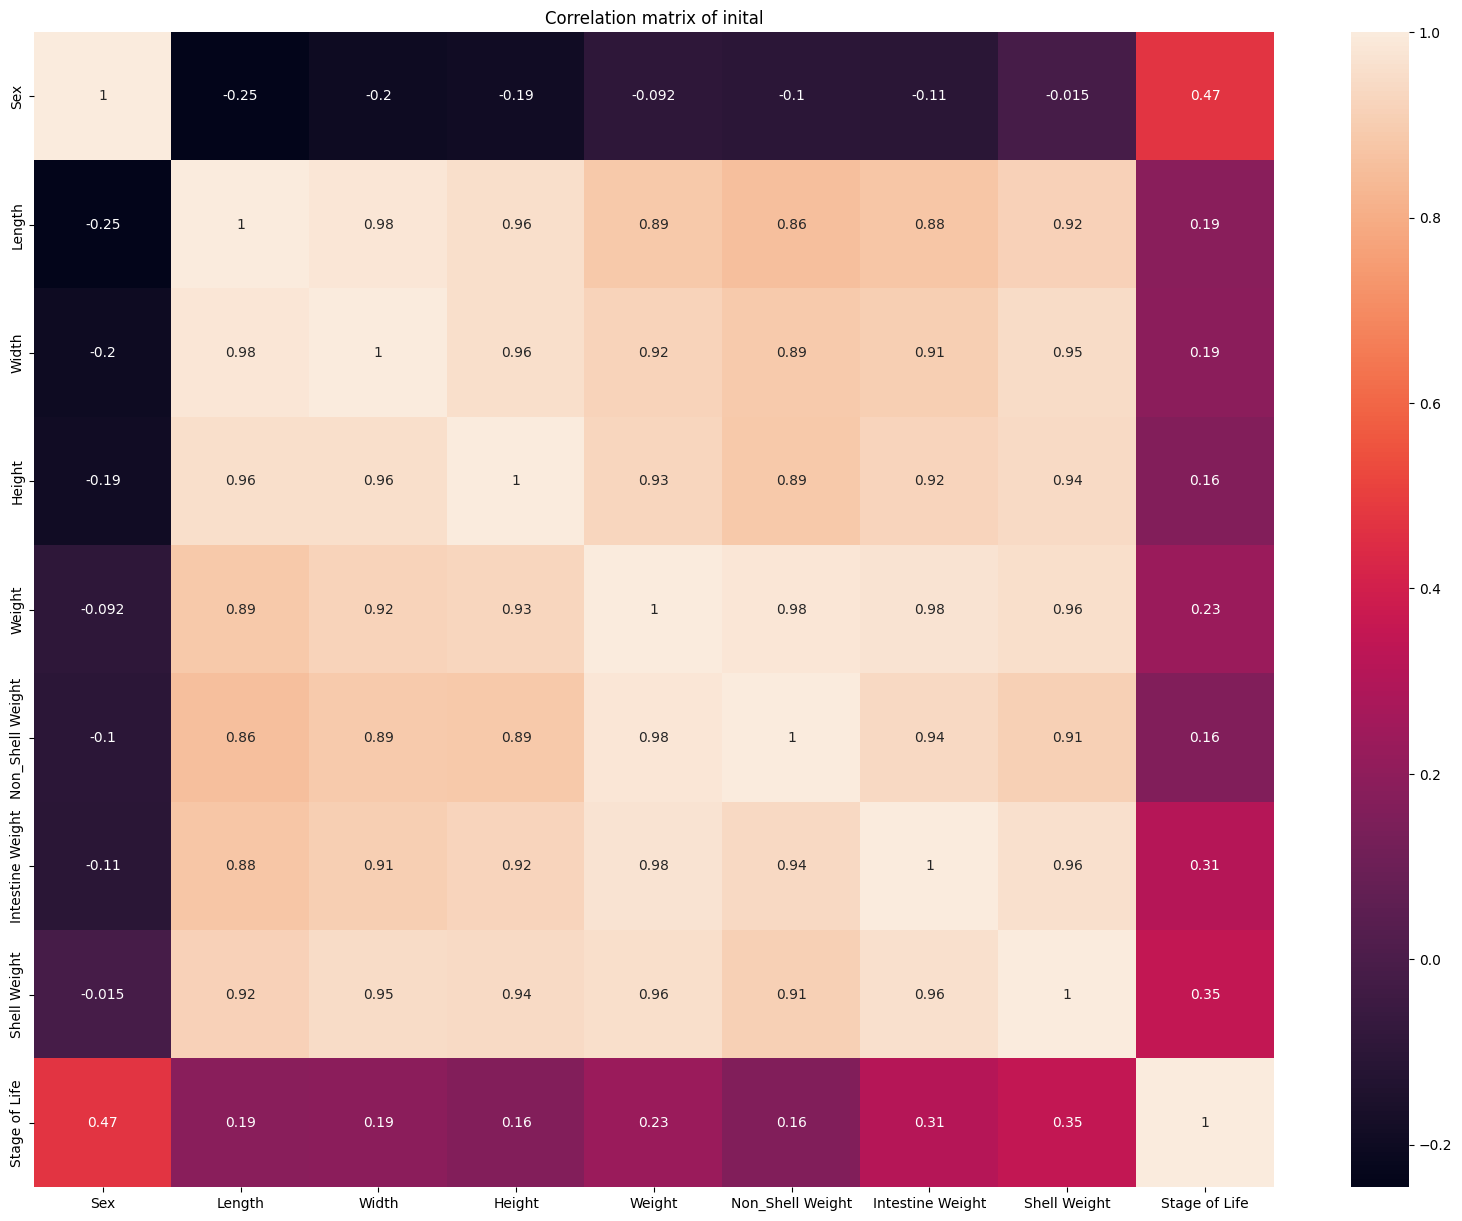

In [301]:
plot_correlation_matrix(molluscs_data, "inital")

In [338]:
# Plot all plots
def plot_all(data, name="dataset", skip_features=None, subplot=False):
    """
    Plots all plots for each feature in a dictionary of datasets.

    Parameters
    ----------
    data : dict, pandas.DataFrame, pandas.Series
        Dictionary of datasets or whole dataset to plot all plots for.
    name : str, optional
        Name of the dataset.
    skip_features : list, optional
        List of features to skip.
    subplot : bool, optional
        Whether to plot all features in one plot or each feature in a separate plot.
    """
    try:
        plot_histogram(data, name, skip_features, subplot)
    except:
        print("Error plotting histogram")
    try:
        plot_distribution(data, name, skip_features, subplot, "pdf")
    except:
        print("Error plotting pdf")
    try:
        plot_distribution(data, name, skip_features, subplot, "cdf")
    except:
        print("Error plotting cdf")
    try:
        plot_box_violin(data, name, skip_features, subplot, "box")
    except:
        print("Error plotting box")
    try:
        plot_box_violin(data, name, skip_features, subplot, "violin")
    except:
        print("Error plotting violin")
    try:
        plot_kde(data, name, skip_features, subplot)
    except:
        print("Error plotting kde")
    try:
        plot_scatter(data, name, skip_features, subplot)
    except:
        print("Error plotting scatter")
    try:
        plot_correlation_matrix(data, name, skip_features)
    except:
        print("Error plotting correlation matrix")

In [303]:
# Calculate datapoint count for 6 days
datapoint_count_period_1 = calculate_datapoint_count(duration_days=6)
datapoint_count_period_1

288

##### Helper functions for generating data using latin hypercubes based on the initial data

In [304]:
from e2ml.experimentation import lat_hyp_cube, lat_hyp_cube_norm_dist

# Generate 288 new rows of data using Latin hypercube sampling


def generate_lat_hyp_cube_datareq(datapoint_count=288, random_state=42):
    """
    Generates new data request using Latin hypercube sampling
    The data request is generated using the initial data as a reference
    It contains the same features as the initial data, except for the "Stage of Life" feature

    Parameters
    ----------
    datapoint_count : int
        Number of datapoints to generate
    random_state : int
        Random state to use for the generation

    Returns
    -------
    new_data : pandas.DataFrame
        New data request generated using Latin hypercube sampling
    """
    new_data = pd.DataFrame(columns=initial_molluscs_data.columns).drop(
        columns=["Stage of Life"]
    )

    if datapoint_count == 0:
        return new_data

    new_data = pd.DataFrame(
        lat_hyp_cube(datapoint_count, len(initial_molluscs_data.columns) - 2),
        columns=initial_molluscs_data.columns.drop(["Stage of Life", "Sex"]),
    )

    sex_values = encode_labels(["F", "M", "I"], label_encoders, key="Sex")[0]

    # Assign a sex to each row of data make sure that data is balanced
    new_data["Sex"] = np.append(
        np.repeat(sex_values, datapoint_count // 3),
        np.random.choice(sex_values, datapoint_count % 3),
    )

    row_num = {x: -1 for x in sex_values}

    for idx, row in new_data.iterrows():
        sex = row["Sex"]
        for feature in initial_molluscs_data.columns.drop(["Stage of Life", "Sex"]):
            row_num[sex] += 1
            if row_num[sex] == 0:
                val = molluscs_data_dict[sex][feature].min() - molluscs_data_sex_ms[sex][feature]["std"]
                new_data.at[idx, feature] = val if val > 0 else molluscs_data_sex_ms[sex][feature]["std"]
            elif row_num[sex] == 1:
                new_data.at[idx, feature] = (
                    molluscs_data_dict[sex][feature].max() + molluscs_data_sex_ms[sex][feature]["std"]
                )
            else:
                dist = np.random.normal(
                    molluscs_data_sex_ms[sex][feature]["mean"],
                    2 * molluscs_data_sex_ms[sex][feature]["std"],
                    size=datapoint_count * 2,
                )
                min_val = min(dist[dist > 0])
                max_val = max(dist)
                # min_val = max(means_dict[sex][feature] - 2 * stds_dict[sex][feature], molluscs_data_dict[sex][feature].min())
                # max_val = means_dict[sex][feature] + 2 * stds_dict[sex][feature]
                # new_data.at[idx, feature] = new_data.at[idx, feature] * (molluscs_data_dict[sex][feature].max() - molluscs_data_dict[sex][feature].min()) + molluscs_data_dict[sex][feature].min()
                # new_val = 0
                # while new_val <= 0:
                #    new_val = np.random.normal(
                #        means_dict[sex][feature], stds_dict[sex][feature]
                #    )
                # new_data.at[idx, feature] = new_val
                val = 0
                while val <= 0:
                    val = new_data.at[idx, feature] * (max_val - min_val) + min_val
                new_data.at[idx, feature] = val
            while new_data.at[idx, feature] <= 0:
                new_data.at[idx, feature] = np.random.normal(
                    molluscs_data_sex_ms[sex][feature]["mean"], 2 * molluscs_data_sex_ms[sex][feature]["std"]
                )
            if new_data.at[idx, feature] <= 0:
                print(
                    "WARNING: Generated value for feature {} is negative".format(
                        feature
                    )
                )

    return new_data



def generate_lat_hyp_cube_norm_dist_datareq(datapoint_count=288):
    """
    Generates new data request using Latin hypercube sampling
    The data request is generated using the initial data as a reference
    It contains the same features as the initial data, except for the "Stage of Life" feature

    Parameters
    ----------
    datapoint_count : int
        Number of datapoints to generate

    Returns
    -------
    new_data : pandas.DataFrame
        New data request generated using Latin hypercube sampling
    """
    new_data = pd.DataFrame(columns=initial_molluscs_data.columns).drop(
        columns=["Stage of Life"]
    )

    if datapoint_count == 0:
        return new_data

    new_data = pd.DataFrame(
        np.zeros((datapoint_count, len(initial_molluscs_data.columns) - 2)),
        columns=initial_molluscs_data.columns.drop(["Stage of Life", "Sex"]),
    )

    sex_values = encode_labels(["F", "M", "I"], label_encoders, key="Sex")[0]

    # Assign a sex to each row of data make sure that data is balanced
    new_data["Sex"] = np.append(
        np.repeat(sex_values, datapoint_count // 3),
        np.random.choice(sex_values, datapoint_count % 3),
    )

    bounds = np.array([[0, None] for _ in range(len(new_data.drop(columns=["Sex"]).columns))])

    for sex in sex_values:	
        data = new_data[new_data["Sex"] == sex]
        
        mus = molluscs_data_means[sex]
        mus.pop("Stage of Life", None)
        mus.pop("Sex", None)
        sigmas = {x: molluscs_data_stds[sex][x] * 10 for x in molluscs_data_stds[sex].keys()}
        sigmas.pop("Stage of Life", None)
        sigmas.pop("Sex", None)
        
        lat_hyp = lat_hyp_cube_norm_dist(
                data.shape[0] - 1,
                len(new_data.drop(columns=["Sex"]).columns),
                mus,
                sigmas,
                new_data.drop(columns=["Sex"]).columns,
                bounds,
                True,
                datapoint_count * 2,
            )
        for idx, feature in enumerate(new_data.drop(columns=["Sex"]).columns):
            #print(feature)
            #print(lat_hyp[:, idx])
            new_data.loc[new_data["Sex"] == sex, feature] = lat_hyp[:, idx]
     

    return new_data

#### Generate datarequest for first batch

In [305]:
# data_req_period_1 = generate_lat_hyp_cube_datareq(datapoint_count_period_1)
# data_req_period_1.to_csv("../results/data_requests/data_req_period_1.csv", index=False)
data_req_period_1 = encode_labels(pd.read_csv("../results/data_requests/data_req_period_1.csv"), label_encoders)[0]
data_req_period_1_norm = generate_lat_hyp_cube_norm_dist_datareq(
    datapoint_count_period_1
)
data_req_period_1.describe(), data_req_period_1_norm.describe()

(           Length       Width      Height      Weight  Non_Shell Weight  \
 count  288.000000  288.000000  288.000000  288.000000        288.000000   
 mean     0.600365    0.503418    0.174205    1.542079          0.810837   
 std      0.387486    0.316872    0.122141    1.214504          0.572164   
 min      0.003884    0.019546    0.003886    0.001626          0.005884   
 25%      0.301679    0.234468    0.077858    0.592120          0.342597   
 50%      0.546048    0.456292    0.140382    1.120747          0.593013   
 75%      0.803952    0.696572    0.252859    2.342415          1.312439   
 max      1.856583    1.420338    0.560663    4.770716          2.162847   
 
        Intestine Weight  Shell Weight         Sex  
 count        288.000000    288.000000  288.000000  
 mean           0.355107      0.451117    1.000000  
 std            0.277439      0.321942    0.817918  
 min            0.000493      0.004019    0.000000  
 25%            0.109560      0.205406    0.00000

In [306]:
data_req_period_1_dict = split_dataset(data_req_period_1, "Sex")
data_req_period_1_norm_dict = split_dataset(data_req_period_1_norm, "Sex")

In [307]:
def plot_samples(*samples, titles=None, initiaL_data=False, include_stage_of_life=False):
    """
    Plots the samples of the features of the initial data and the data request
    """
    feature_count = len(initial_molluscs_data.columns) - 1 if not include_stage_of_life else len(initial_molluscs_data.columns)
    fig, axs = plt.subplots(feature_count, 3, figsize=(15, 30))
    
    if titles is None:
        titles = []
    titles = titles + ["Sample {}".format(i) for i in range(len(titles), len(samples))]

    sex_values = list(encode_labels(["F", "M", "I"], label_encoders, key="Sex")[0])

    for idx, feature in enumerate(initial_molluscs_data.columns if include_stage_of_life else initial_molluscs_data.columns.drop("Stage of Life")):
        for i_idx, sex in enumerate(sex_values):
            bins = 50
            ax = axs[idx, i_idx]
            if feature != "Stage of Life" or include_stage_of_life:
                for j_idx, sample in enumerate(samples):
                    (n, bins, patches) = ax.hist(
                        sample[sex][feature],
                        alpha=0.5,
                        stacked=True,
                        label=(str(sex) + " " + titles[j_idx]),
                    ) if bins is None else ax.hist(
                        sample[sex][feature],
                        alpha=0.5,
                        stacked=True,
                        label=(str(sex) + " " + titles[j_idx]),
                        bins = bins
                    )


            if initiaL_data:
                ax.hist(
                    molluscs_data_dict[sex][feature],
                    alpha=0.5,
                    stacked=True,
                    label=(str(sex) + " initial"),
                    bins=bins,
                ) if bins is not None else ax.hist(
                    molluscs_data_dict[sex][feature],
                    alpha=0.5,
                    stacked=True,
                    label=(str(sex) + " initial"),
                )

            #ax.set_title(feature)
            ax.set_xlabel(feature)
            ax.set_ylabel("Frequency")
            ax.legend()
            #ax.set_yscale("log")
    plt.show()

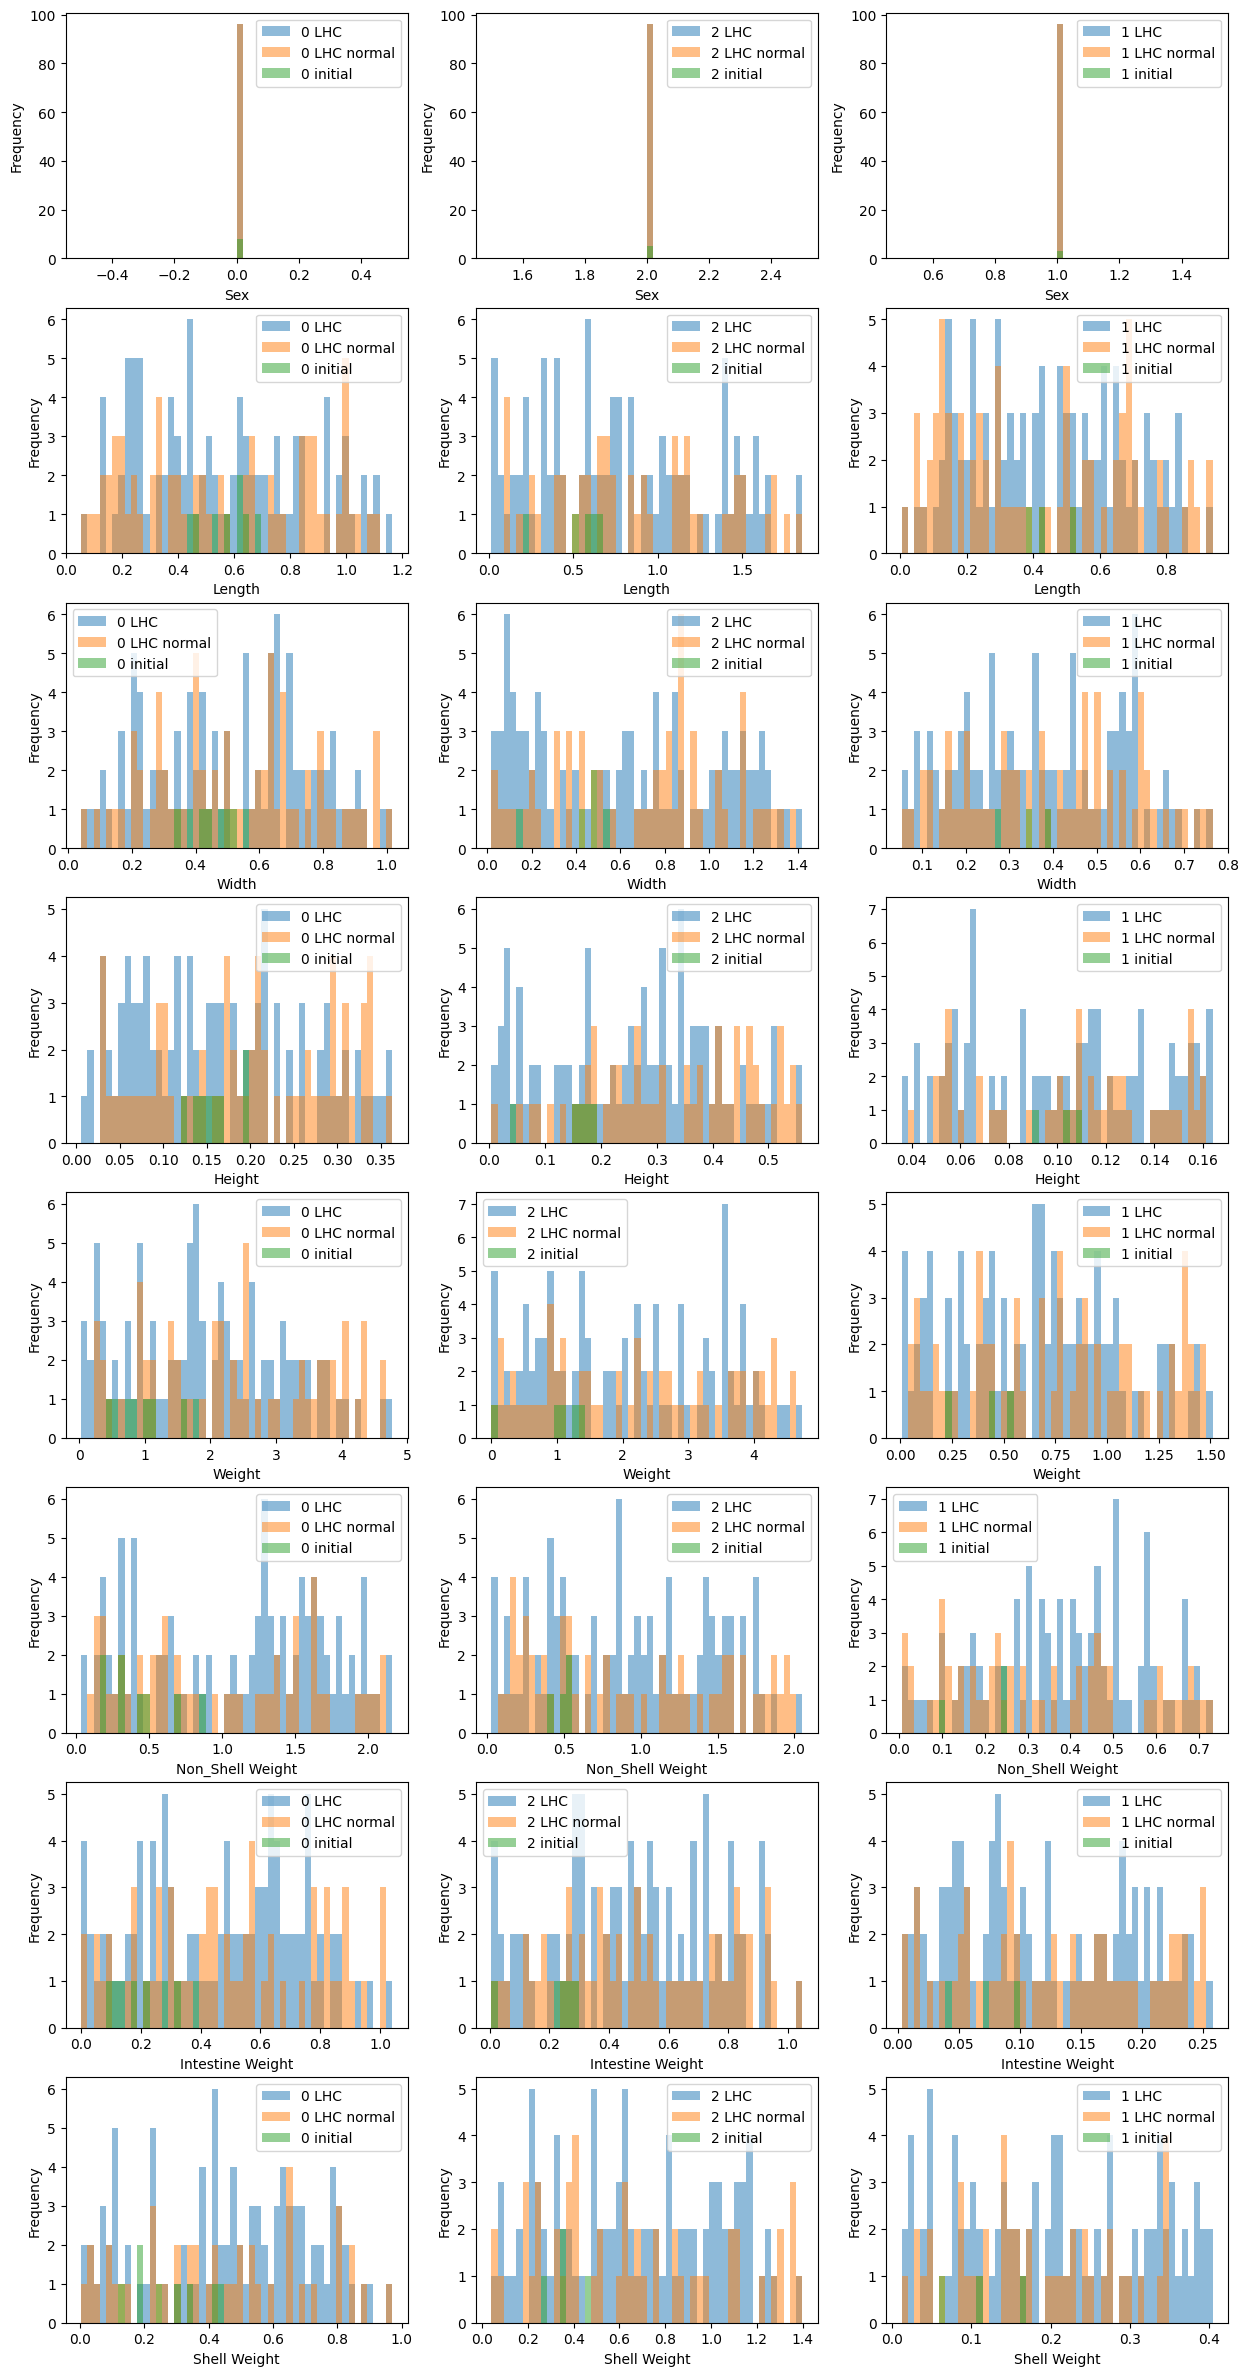

In [308]:
plot_samples(data_req_period_1_dict, data_req_period_1_norm_dict, titles=["LHC", "LHC normal"], initiaL_data=True)

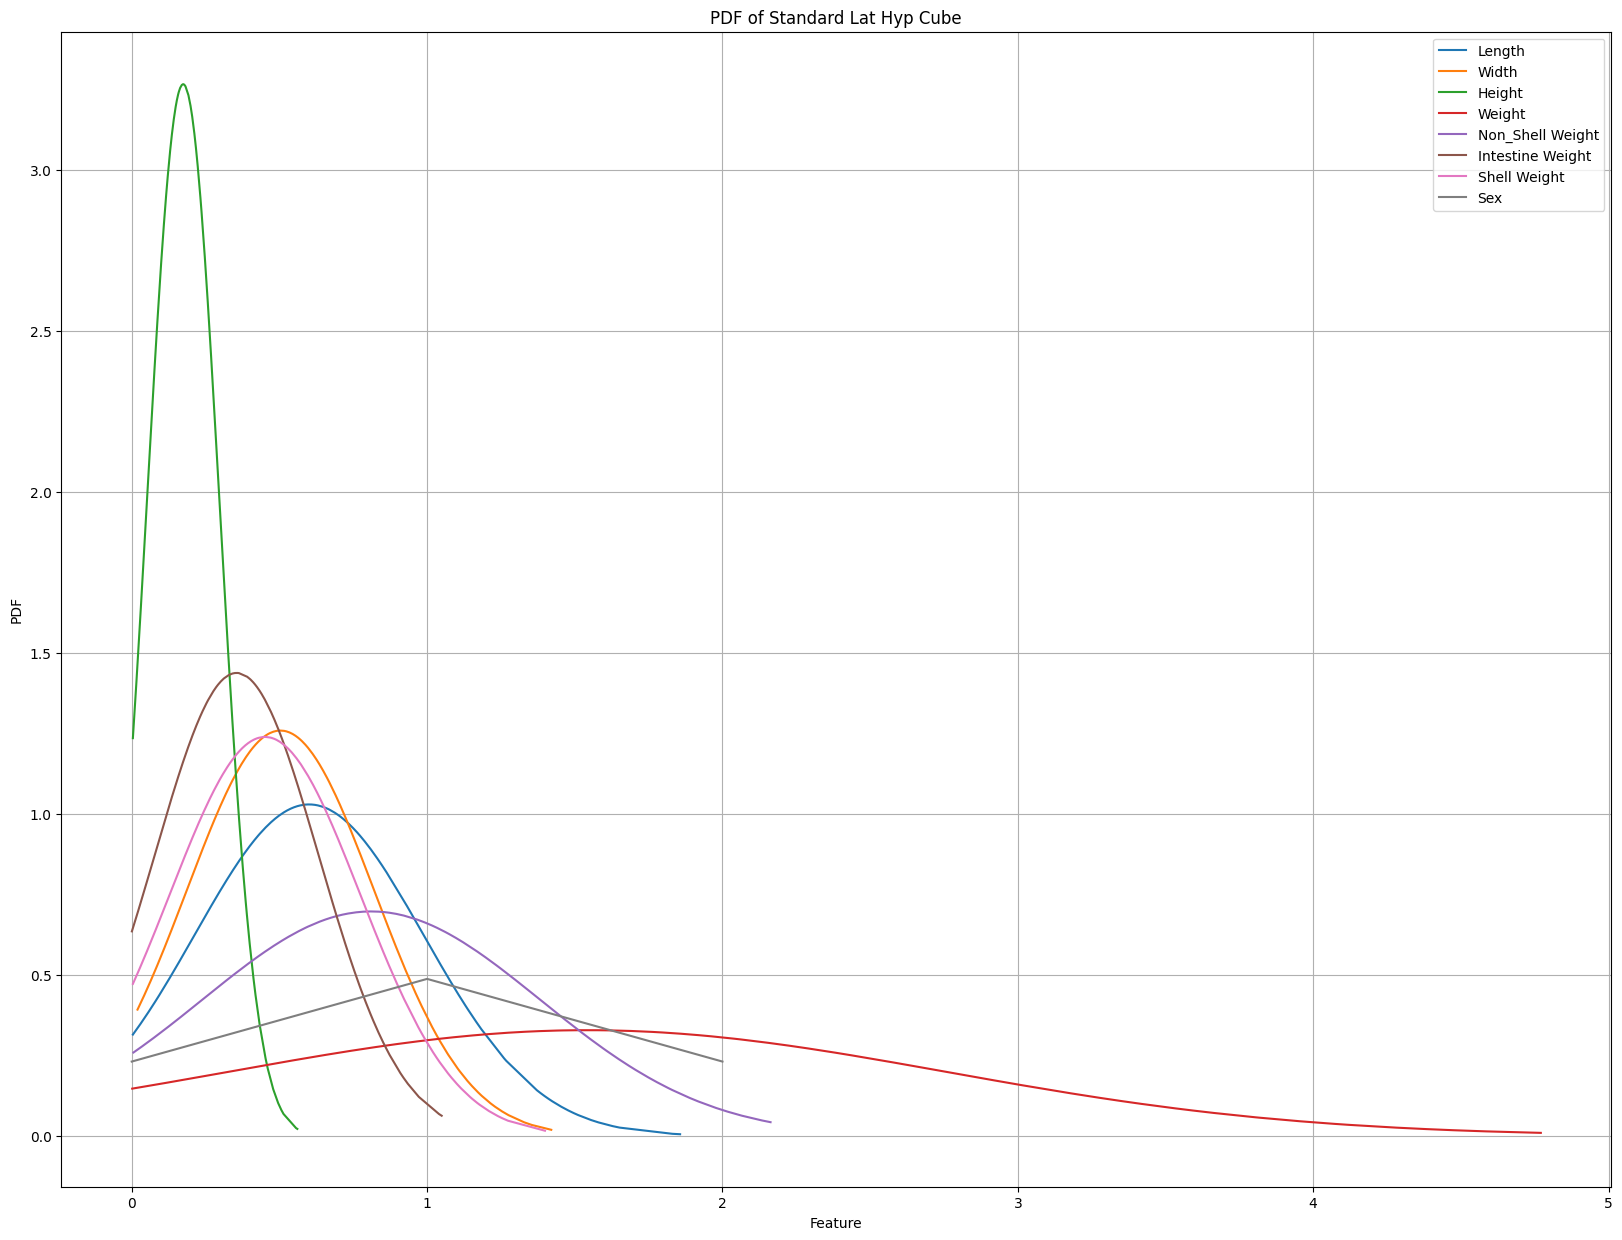

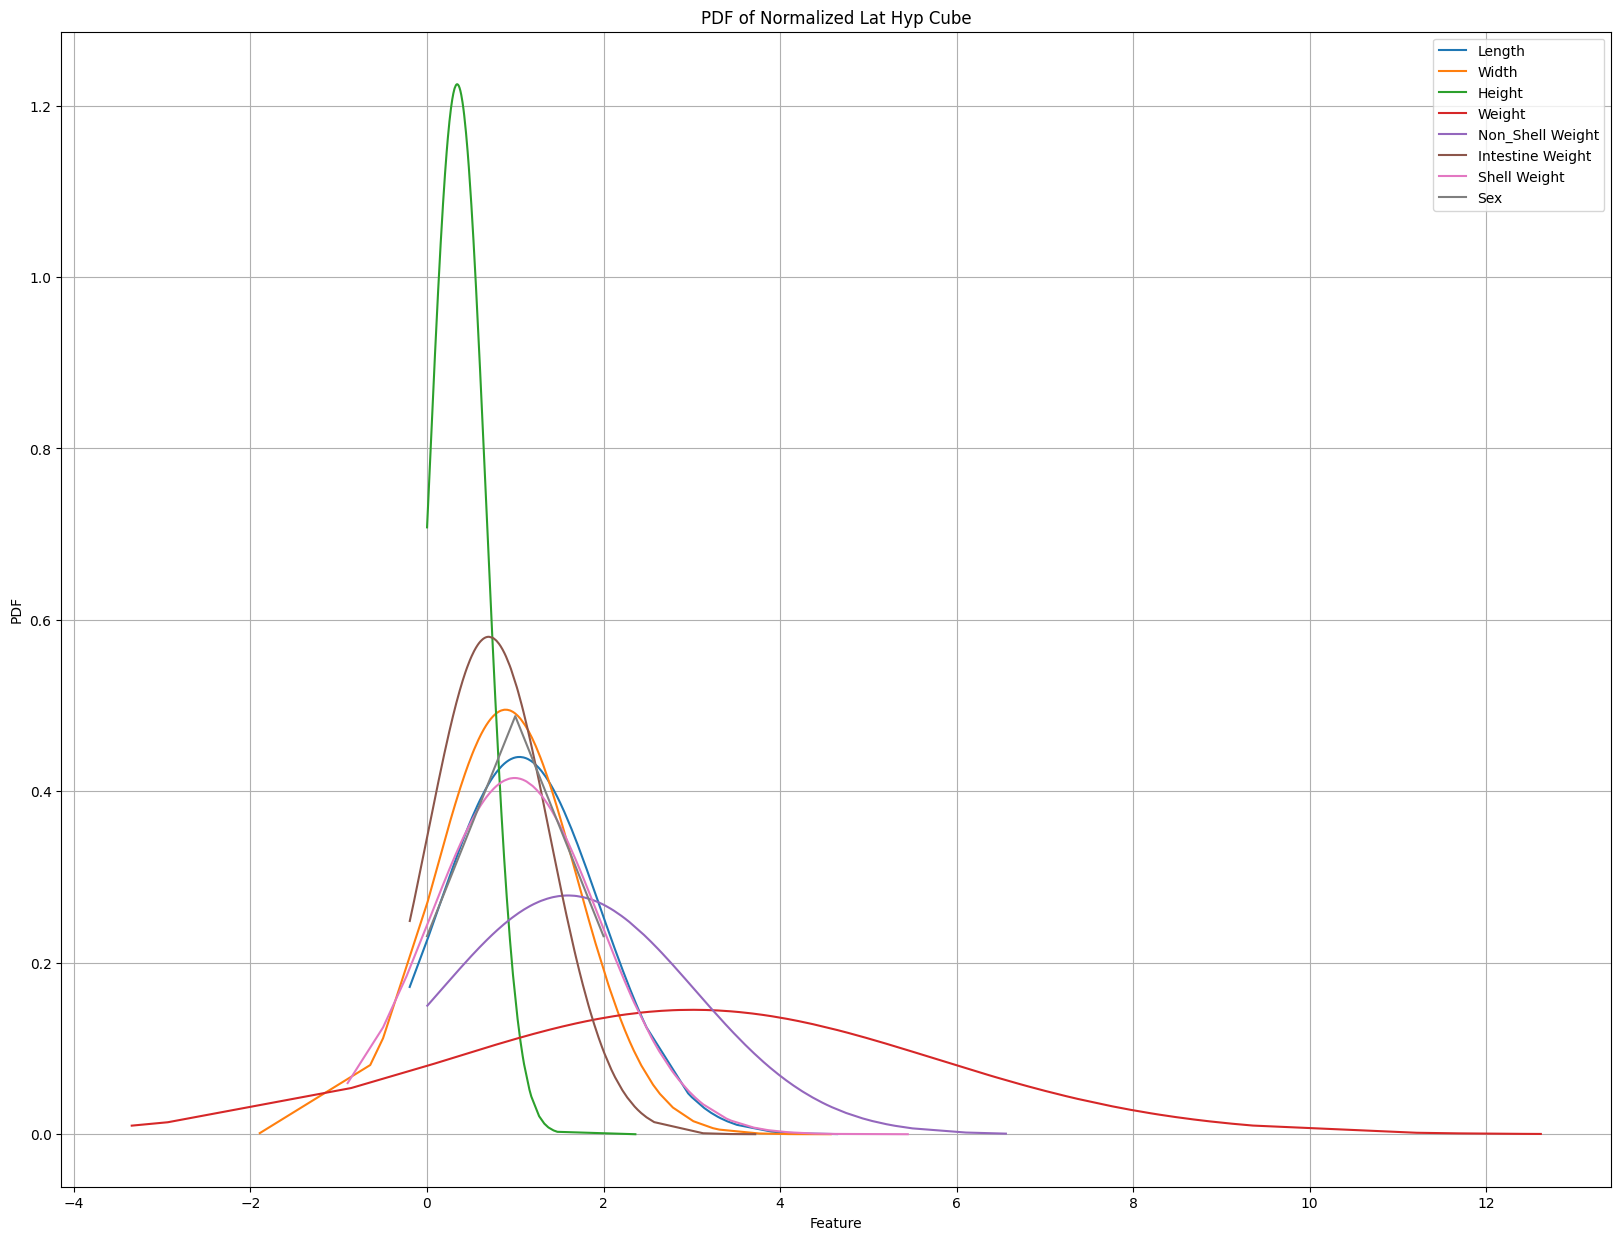

In [309]:
# Calculate the mean and standard deviation for each feature for each Sex in the data request
plot_distribution(data_req_period_1, "Standard Lat Hyp Cube")
plot_distribution(data_req_period_1_norm, "Normalized Lat Hyp Cube")

#### First batch of data

In [310]:
first_batch_data = pd.read_csv("../data/batch1_laskowicz_labels.csv")
first_batch_data

Sex    Length     Width    Height    Weight  Non_Shell Weight  \
0     F  0.366805  0.632528  0.059695  1.765412          1.705881   
1     F  0.290436  0.641400  0.151900  3.351605          1.648159   
2     F  0.840416  0.595753  0.049704  2.196816          0.399504   
3     F  0.193700  0.291330  0.032835  0.409752          1.188451   
4     F  0.695774  0.804412  0.334535  2.261121          0.034191   
..   ..       ...       ...       ...       ...               ...   
283   I  0.751048  0.295386  0.130423  0.712826          0.310398   
284   I  0.471578  0.451786  0.108877  0.759138          0.298701   
285   I  0.286663  0.254839  0.062179  0.765363          0.005884   
286   I  0.511169  0.352952  0.161621  1.086248          0.247395   
287   I  0.297210  0.249291  0.091494  1.015784          0.141060   

     Intestine Weight  Shell Weight Stage of Life  
0            0.389397      0.699273         Adult  
1            0.282120      0.517538         Child  
2            0.806156      0.557890         Adult  
3            0.363125      0.789095         Adult  
4            0.679762      0.473274         Adult  
..                ...           ...           ...  
283          0.056996      0.226844         Adole  
284          0.110289      0.323359         Adult  
285          0.225110      0.272711         Adult  
286          0.258118      0.297818         Adult  
287          0.117376      0.092959         Adult  

[288 rows x 9 columns]

In [311]:
molluscs_data = encode_labels(pd.concat([initial_molluscs_data, first_batch_data], ignore_index=True), label_encoders)[0]
molluscs_data

Sex    Length     Width    Height    Weight  Non_Shell Weight  \
0      0  0.450000  0.345000  0.120000  0.416500          0.165500   
1      0  0.475000  0.380000  0.145000  0.570000          0.167000   
2      2  0.610000  0.485000  0.170000  1.022500          0.419000   
3      1  0.430000  0.340000  0.105000  0.440500          0.238500   
4      2  0.205000  0.155000  0.045000  0.042500          0.017000   
..   ...       ...       ...       ...       ...               ...   
299    1  0.751048  0.295386  0.130423  0.712826          0.310398   
300    1  0.471578  0.451786  0.108877  0.759138          0.298701   
301    1  0.286663  0.254839  0.062179  0.765363          0.005884   
302    1  0.511169  0.352952  0.161621  1.086248          0.247395   
303    1  0.297210  0.249291  0.091494  1.015784          0.141060   

     Intestine Weight  Shell Weight  Stage of Life  
0            0.095000      0.135000              1  
1            0.118000      0.187000              0  
2            0.240500      0.360000              1  
3            0.074500      0.107500              0  
4            0.005500      0.015500              1  
..                ...           ...            ...  
299          0.056996      0.226844              0  
300          0.110289      0.323359              1  
301          0.225110      0.272711              1  
302          0.258118      0.297818              1  
303          0.117376      0.092959              1  

[304 rows x 9 columns]

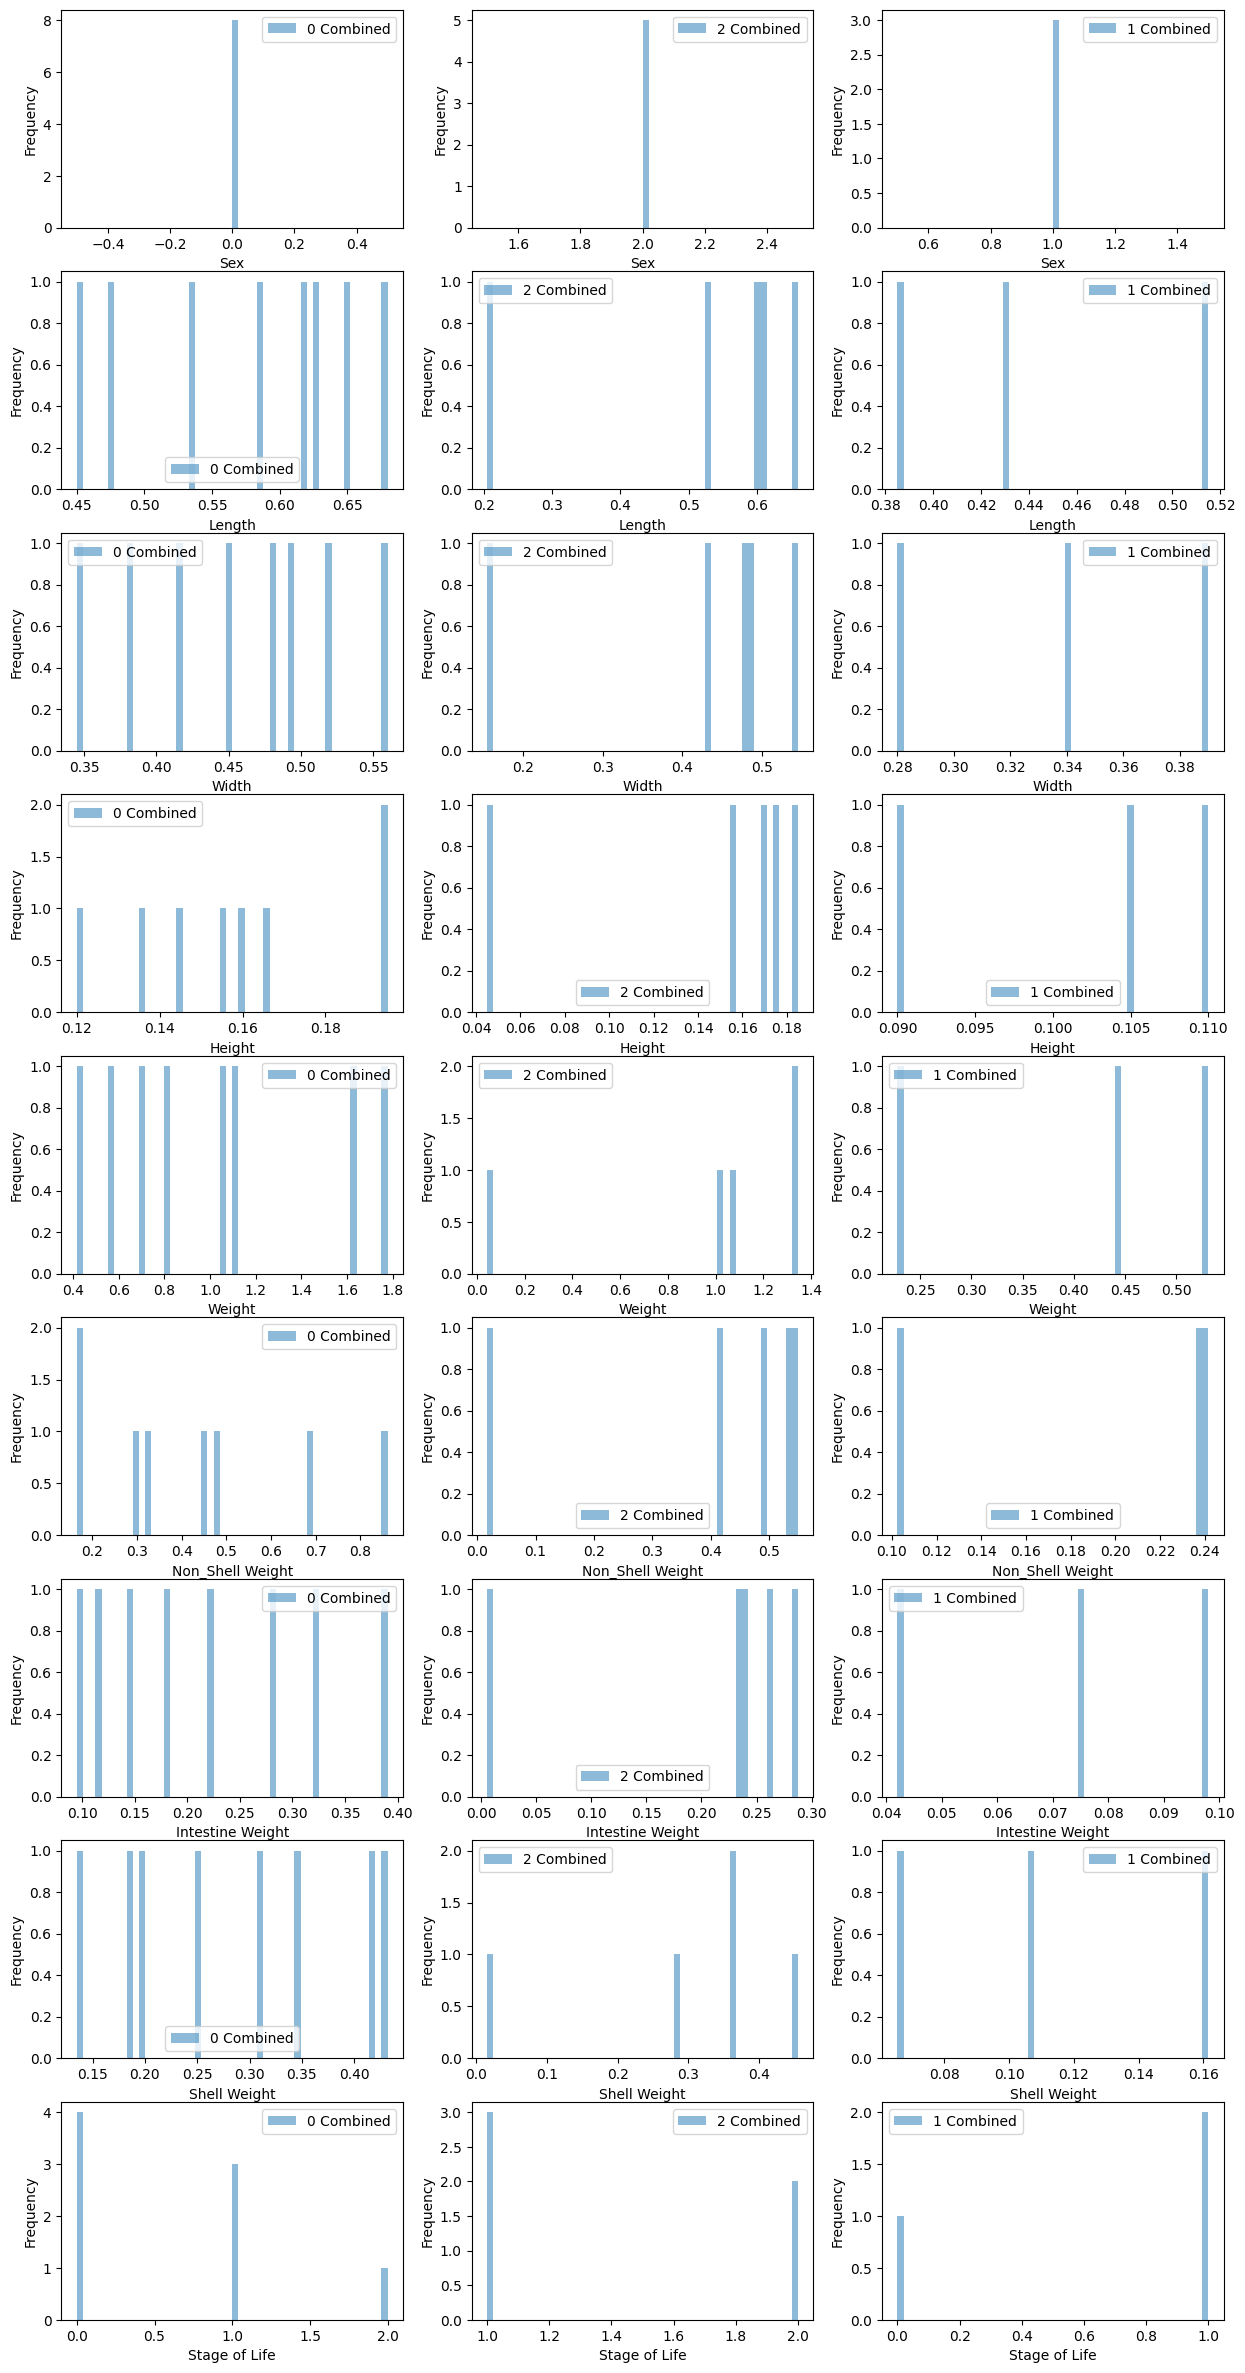

In [312]:
plot_samples(molluscs_data_dict, titles=["Combined"], include_stage_of_life=True)

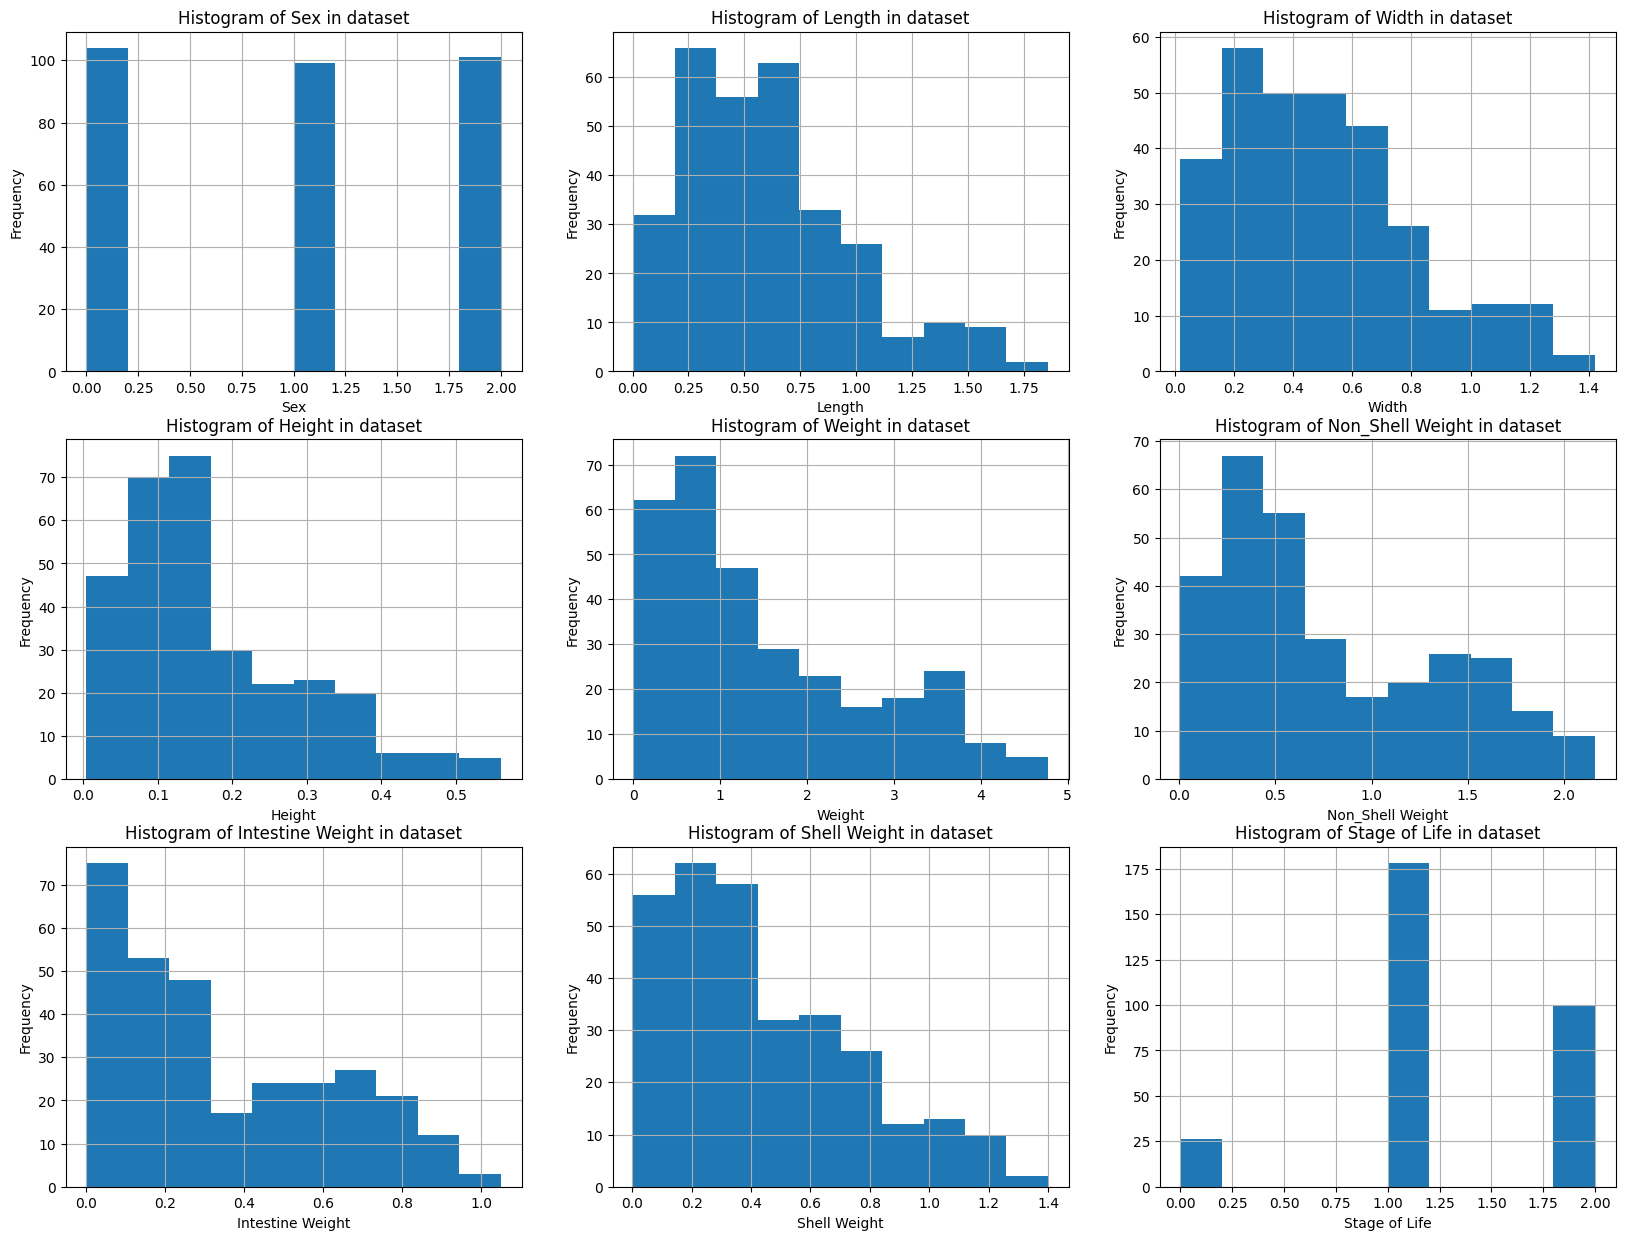

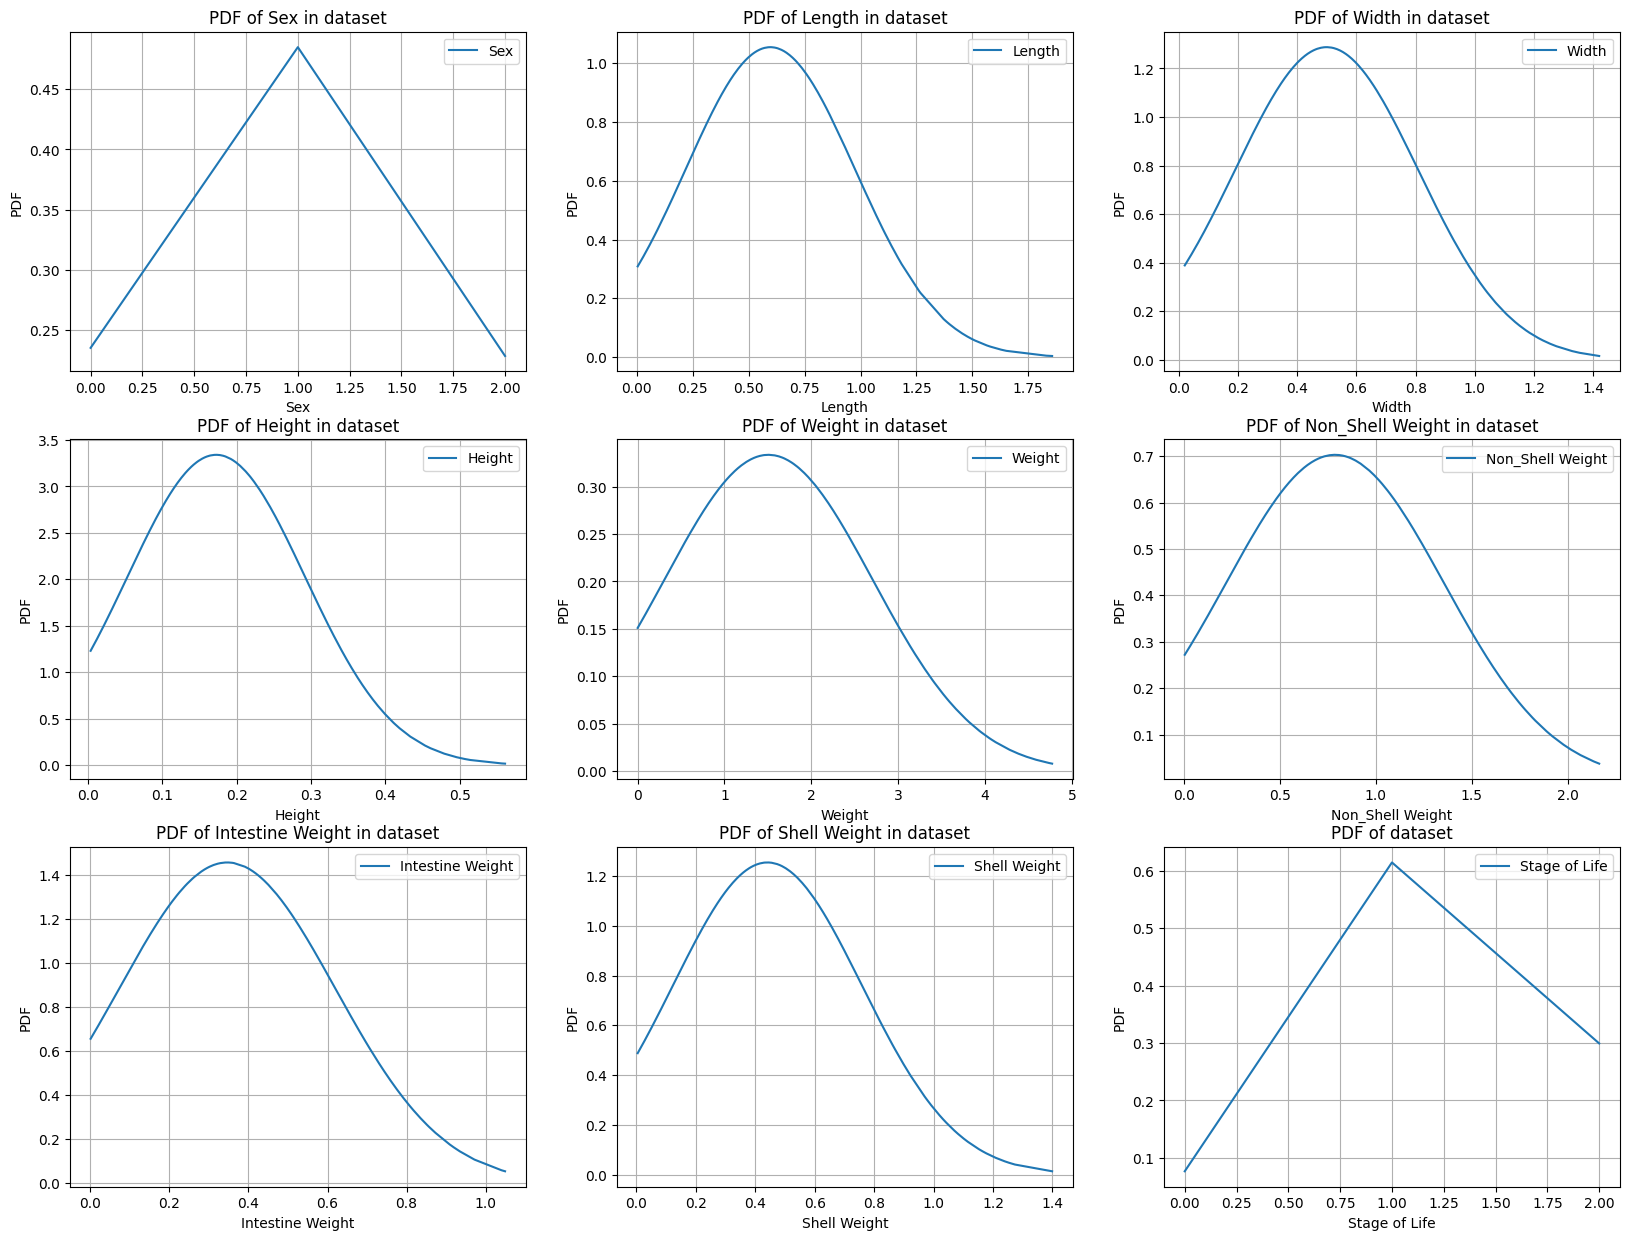

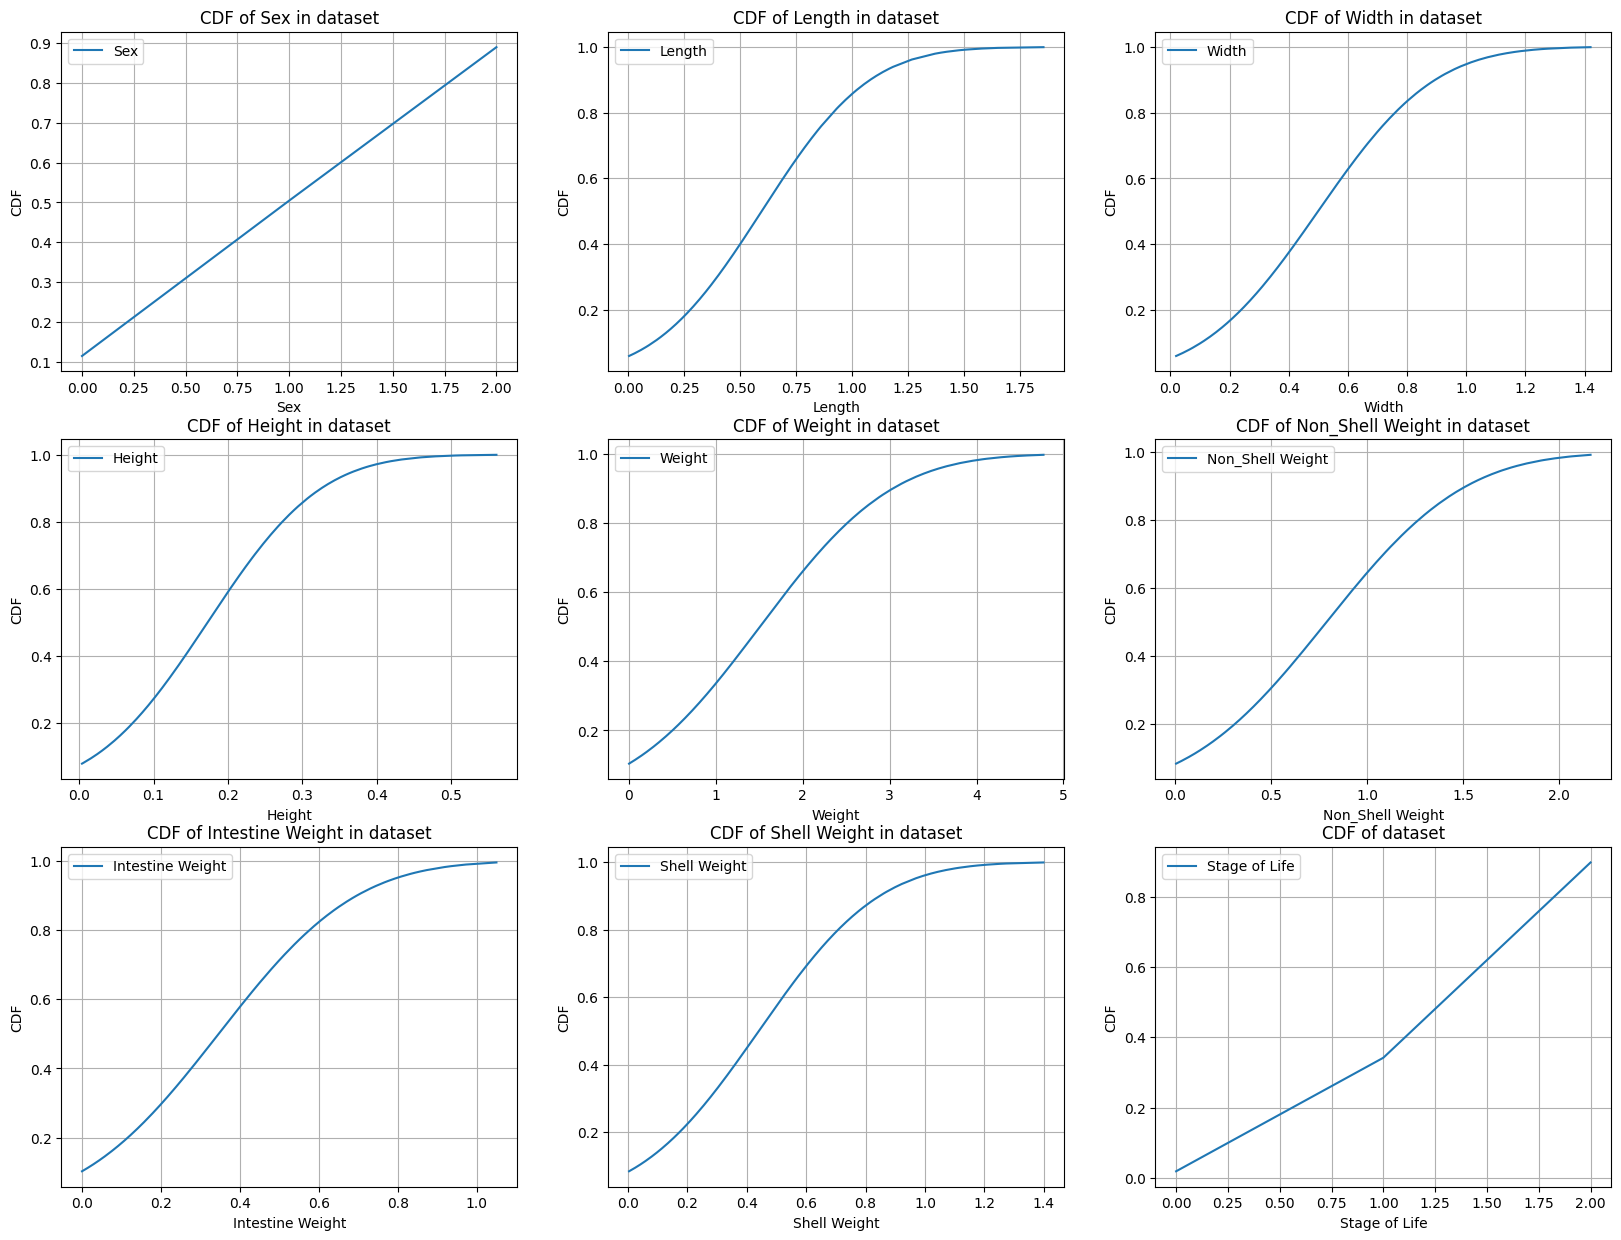

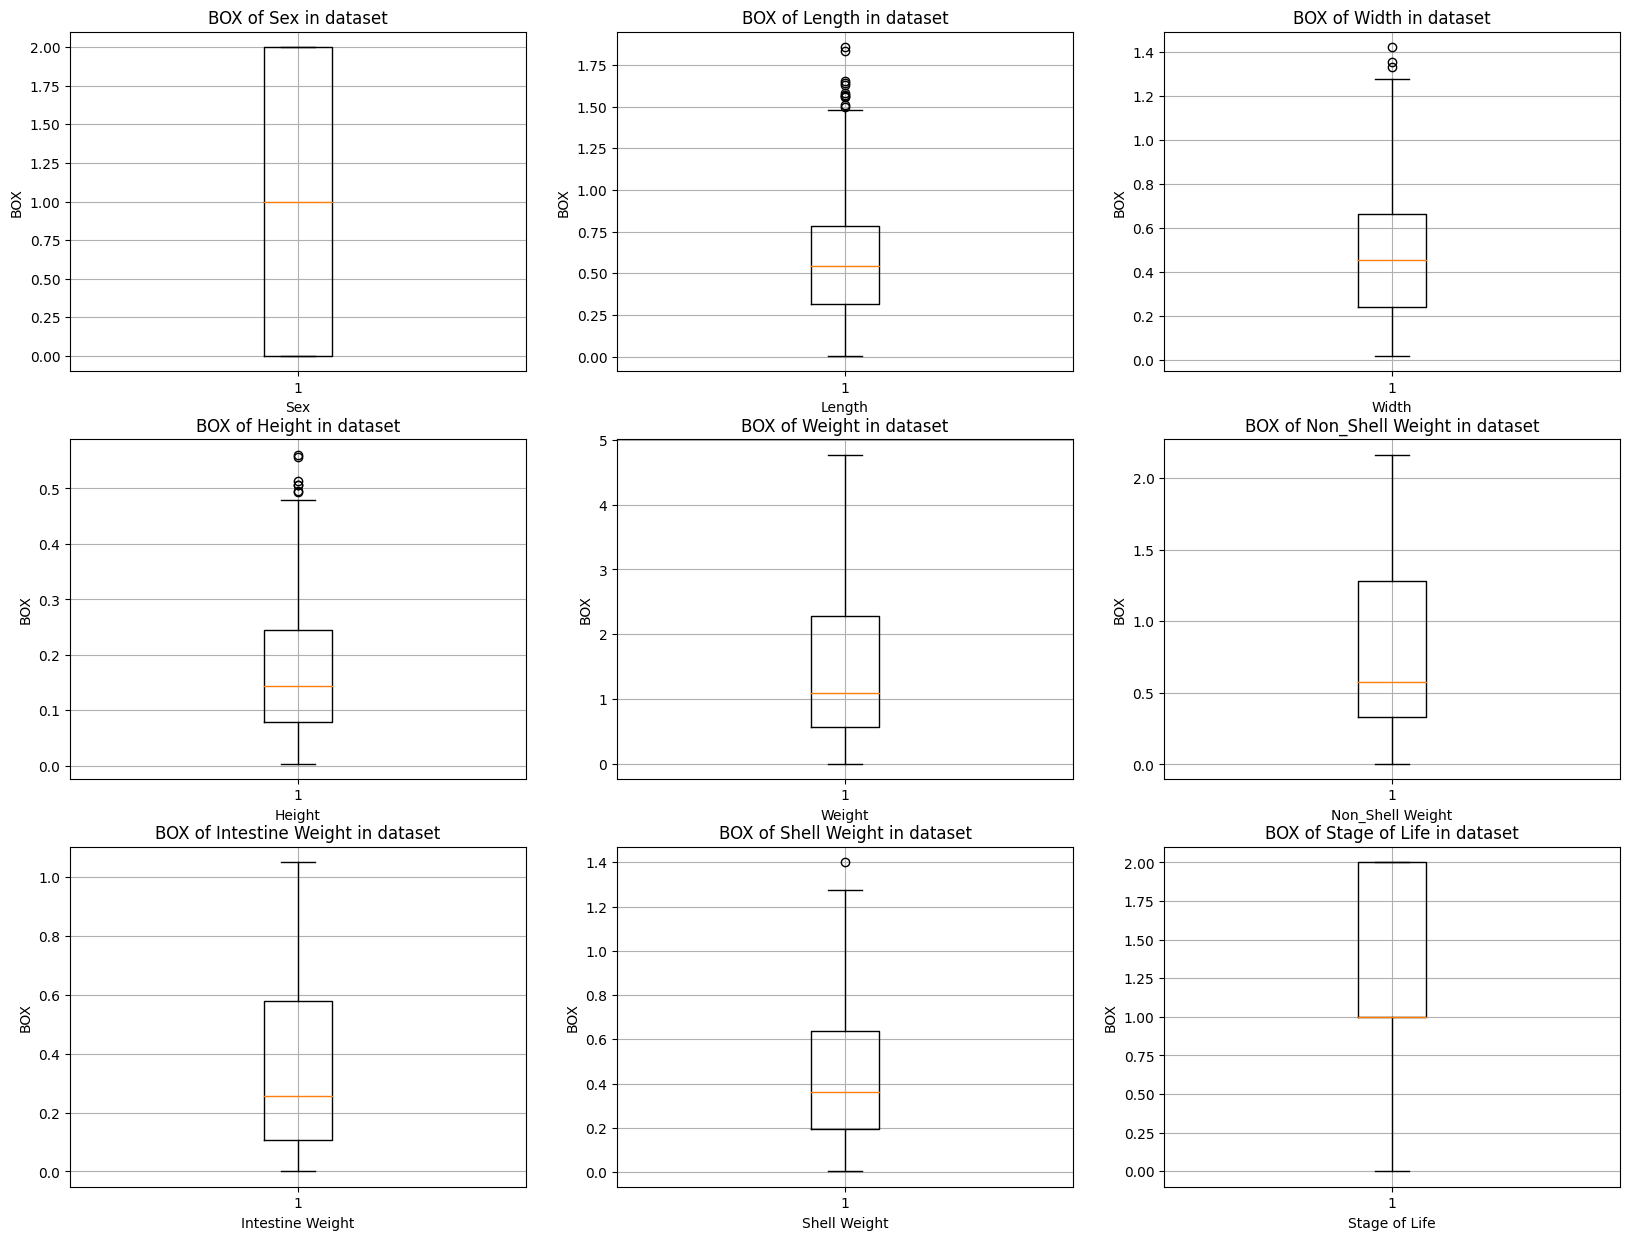

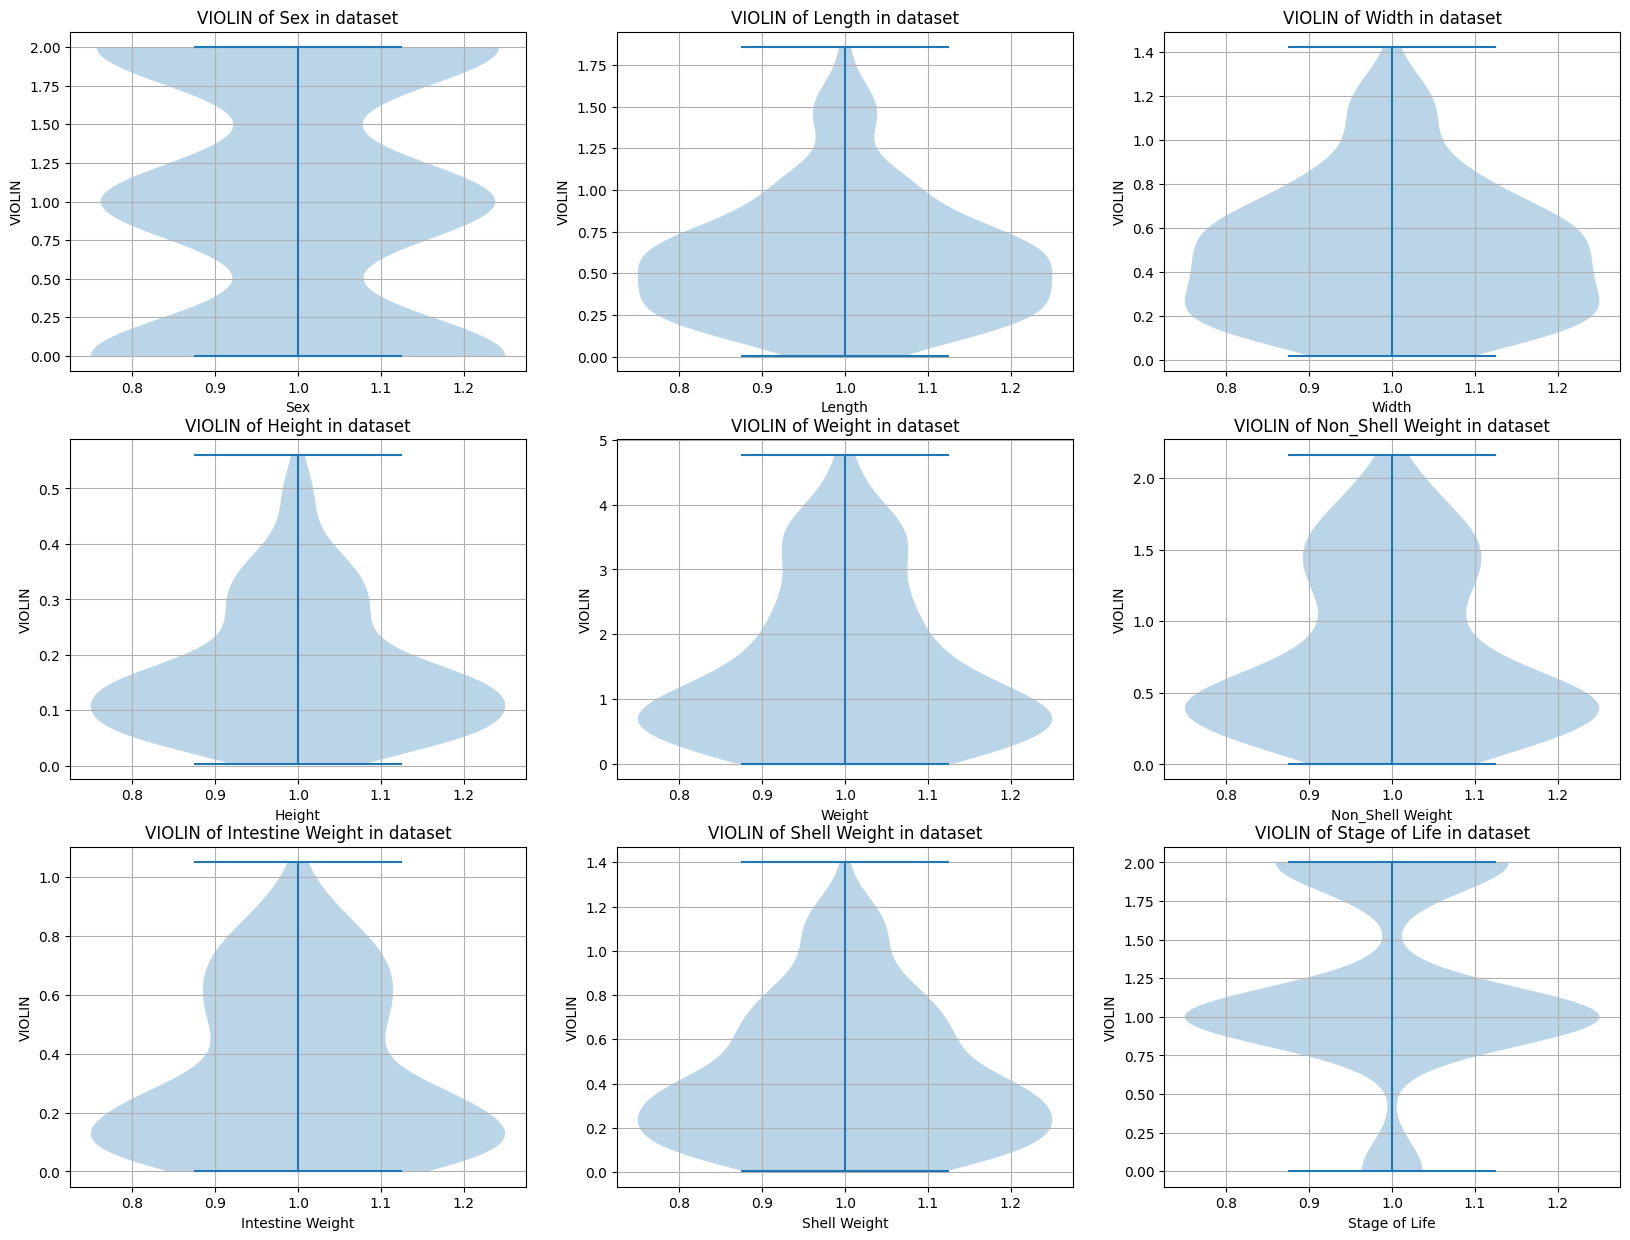

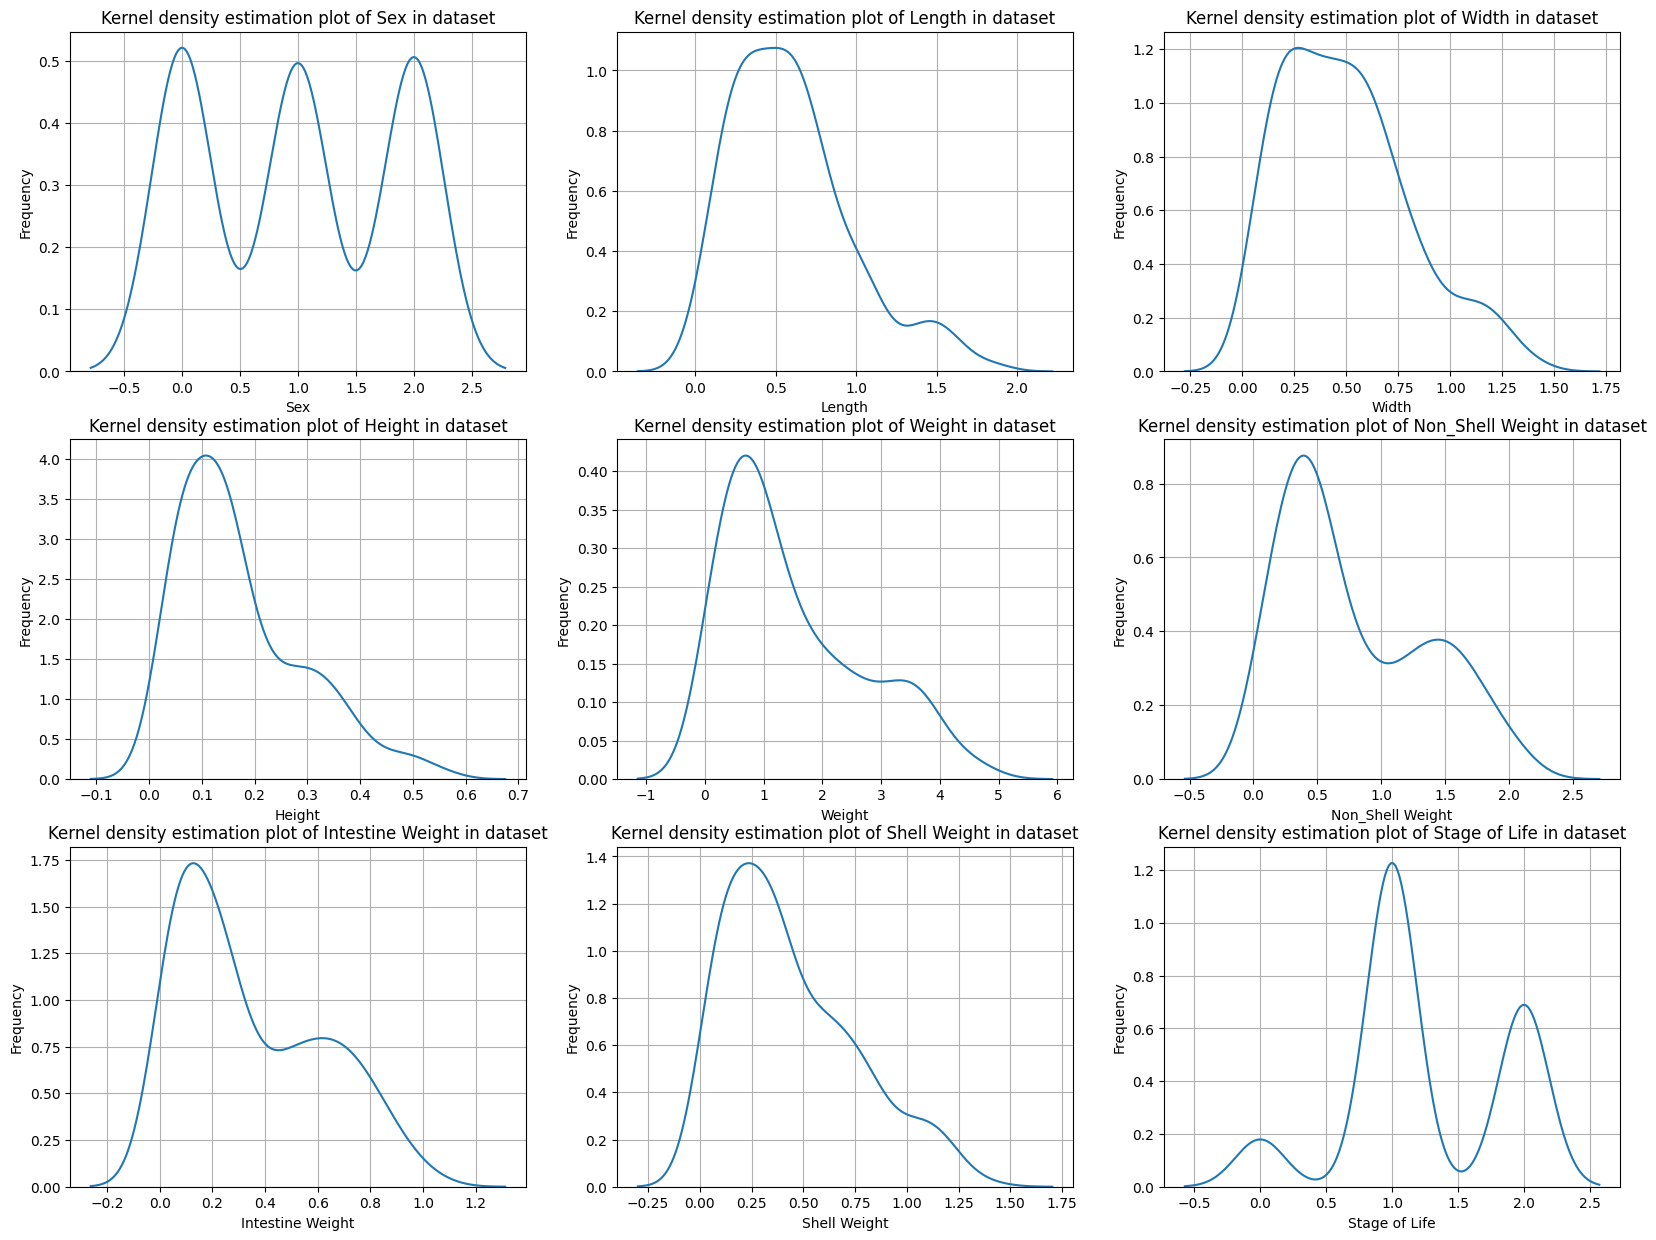

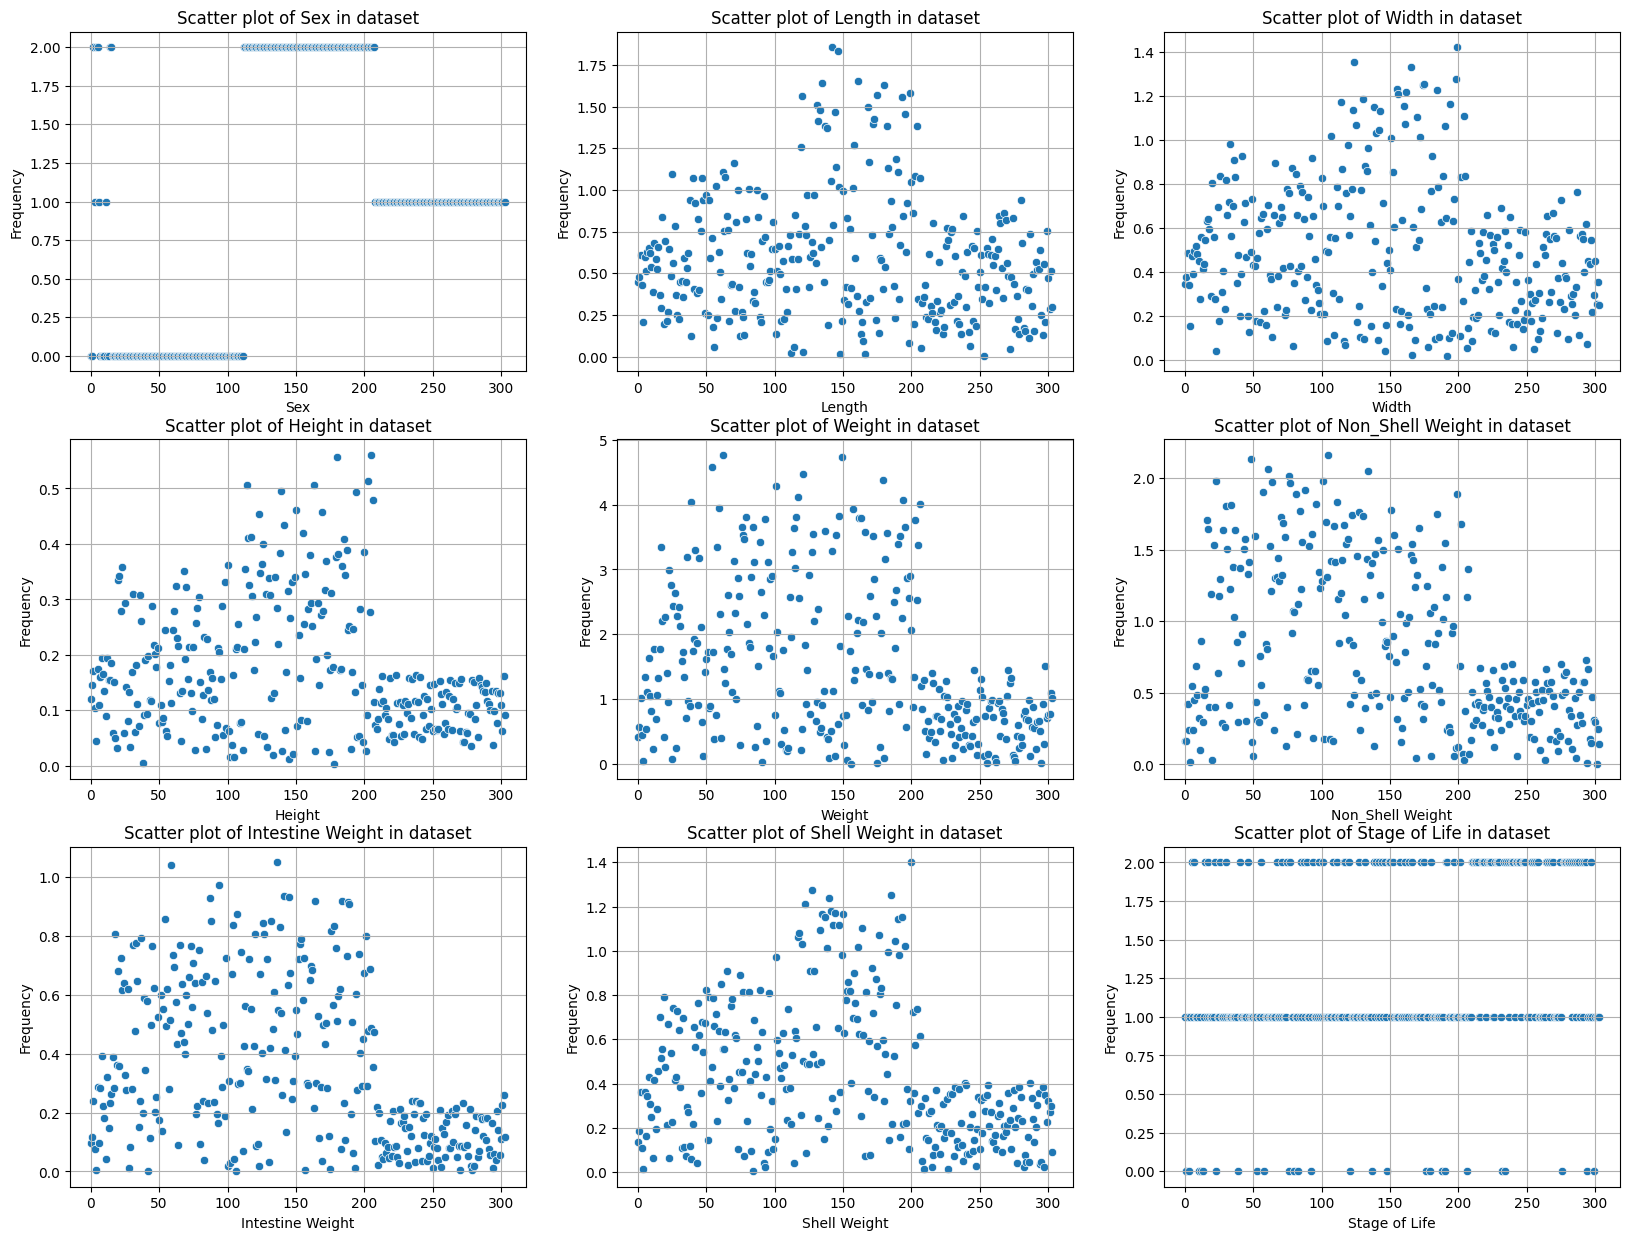

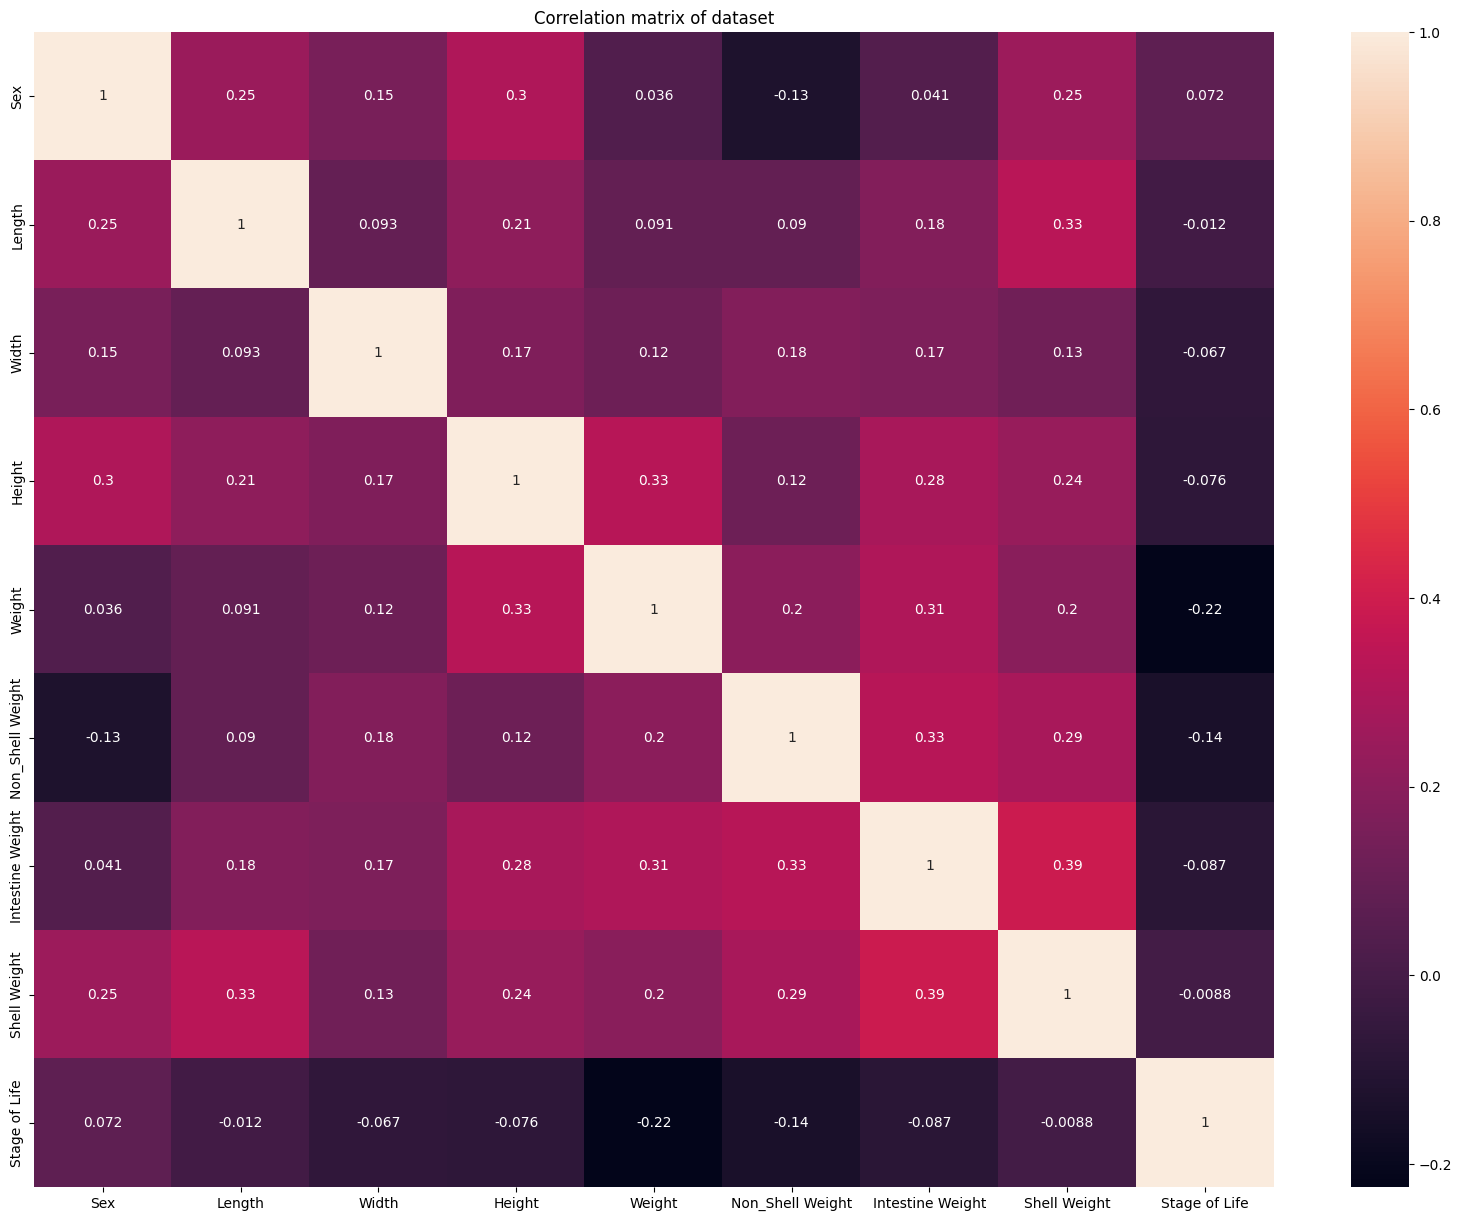

In [313]:
plot_all(molluscs_data, subplot=True)

#### Create second data request

In [314]:
# Data for 5 days
data_point_count_req_2 = calculate_datapoint_count(duration_days=5)

In [315]:
# Check if new data is already in the dataset

def check_for_duplicates(data, dataset):
    """
    Checks if the data is already in the dataset
    """
    return data[~data.isin(dataset.drop(columns=["Stage of Life"]))].dropna()

In [316]:
check_for_duplicates(data_req_period_1, molluscs_data)

Length     Width    Height    Weight  Non_Shell Weight  \
2    0.840416  0.595753  0.049704  2.196816          0.399504   
3    0.193700  0.291330  0.032835  0.409752          1.188451   
4    0.695774  0.804412  0.334535  2.261121          0.034191   
5    0.213050  0.557525  0.342323  1.397271          1.529638   
6    0.270667  0.279773  0.279835  0.949060          0.398580   
11   0.785549  0.308080  0.080028  2.640634          0.290527   
14   0.226405  0.819702  0.168912  2.419660          1.801923   
15   0.448821  0.658244  0.310605  2.128592          1.508438   
96   0.022414  0.697742  0.210125  1.963735          1.159109   
97   0.587034  0.278187  0.354680  3.277142          0.849753   
98   0.056331  1.172394  0.505502  3.646777          1.196999   
99   0.847402  0.868504  0.410529  3.015802          1.426276   
100  0.403945  0.086636  0.326549  3.804664          1.671552   
101  0.587742  0.068266  0.412198  4.120663          1.047276   
102  0.737818  0.759438  0.306430  2.556410          1.536687   
103  1.260635  0.978452  0.173433  0.205289          1.578298   
104  1.564219  0.569983  0.223404  0.535709          0.871882   
105  0.029490  0.653866  0.268554  4.477498          0.419799   
106  0.780908  0.775464  0.057179  1.837568          1.744809   
107  0.732614  1.136343  0.453186  0.917035          0.836180   
108  0.971266  1.354480  0.347828  1.448934          0.486344   
109  0.414980  1.068431  0.363109  2.920419          0.640886   
110  0.596396  0.172736  0.399269  0.764017          1.458752   
111  0.687951  0.244204  0.053012  3.276284          1.763200   
192  0.318982  0.445076  0.072980  0.845651          0.073897   
193  0.360389  0.588091  0.065616  1.287024          0.173203   
194  0.427472  0.089775  0.085021  0.504484          0.503647   
195  0.236360  0.197931  0.139151  0.153550          0.278754   
196  0.225470  0.318586  0.113757  0.667152          0.425303   
197  0.615680  0.192032  0.161495  0.393407          0.307595   
198  0.302364  0.203490  0.117433  0.483900          0.438508   
199  0.260641  0.534083  0.091904  1.406678          0.416220   
200  0.802517  0.488172  0.104162  1.253396          0.673409   
201  0.210303  0.363771  0.085089  0.334711          0.276956   
202  0.160302  0.582430  0.047414  0.736954          0.377480   
203  0.332096  0.381818  0.157908  0.741019          0.404748   
204  0.565348  0.454335  0.055125  1.154153          0.565879   
205  0.260397  0.661195  0.055975  0.502802          0.512518   
206  0.278217  0.324196  0.042953  0.694858          0.472435   
207  0.138078  0.567049  0.164006  0.055681          0.225476   

     Intestine Weight  Shell Weight  Sex  
2            0.806156      0.557890  0.0  
3            0.363125      0.789095  0.0  
4            0.679762      0.473274  0.0  
5            0.358580      0.215213  0.0  
6            0.724008      0.667166  0.0  
11           0.618181      0.415566  0.0  
14           0.281191      0.641432  0.0  
15           0.767327      0.384057  0.0  
96           0.424430      0.215931  2.0  
97           0.562923      0.529363  2.0  
98           0.349412      0.040921  2.0  
99           0.341059      0.638235  2.0  
100          0.720765      0.604656  2.0  
101          0.550409      1.063810  2.0  
102          0.212469      1.082346  2.0  
103          0.424695      0.257213  2.0  
104          0.807833      1.032224  2.0  
105          0.085019      0.501447  2.0  
106          0.094679      1.209466  2.0  
107          0.019563      0.088736  2.0  
108          0.670625      0.490120  2.0  
109          0.400560      0.490029  2.0  
110          0.843261      0.910195  2.0  
111          0.808068      1.273925  2.0  
192          0.102446      0.048915  1.0  
193          0.219024      0.012177  1.0  
194          0.021710      0.333467  1.0  
195          0.198276      0.152931  1.0  
196          0.106978      0.144632  1.0  
197          0.048018      0.265217  1.0  
198     

In [317]:
"""
# Find areas of the dataset where the distance between samples with different labels is small
label_F, label_M, label_I = encode_labels(["F", "M", "I"], label_encoders)[0]

# Find the distance between each sample and the nearest sample with a different label
def find_nearest_different_label(sample, data):
    # Find the nearest sample with a different label
    nearest_different_label = (
        data[data["Stage of Life"] != sample["Stage of Life"]]
        .drop(columns=["Stage of Life"])
        .sub(sample.drop(columns=["Stage of Life"]), axis=1)
        .abs()
        .sum(axis=1)
        .idxmin()
    )
    # Find the distance between the two samples
    distance = np.linalg.norm(
        data.loc[nearest_different_label].drop(columns=["Stage of Life"]) - sample.drop(columns=["Stage of Life"])
    )
    return distance


# Find the distance between each sample and the nearest sample with a different label
def find_nearest_same_label(sample, data):
    # Find the nearest sample with a different label
    nearest_same_label = (
        data[data["Stage of Life"] == sample["Stage of Life"]]
        .drop(columns=["Stage of Life"])
        .sub(sample.drop(columns=["Stage of Life"]), axis=1)
        .abs()
        .sum(axis=1)
        .idxmin()
    )
    # Find the distance between the two samples
    distance = np.linalg.norm(
        np.array(data.loc[nearest_same_label].drop(columns=["Stage of Life"])
        - sample.drop(columns=["Stage of Life"]))
    )
    return distance

data = molluscs_data.copy()
data["nearest_different_label"] = data.drop(columns=["Sex"]).apply(
    lambda row: find_nearest_different_label(row, data.drop(columns=["Sex"])), axis=1
)
data["nearest_same_label"] = data.drop(columns=["Sex", "nearest_different_label"]).apply(
    lambda row: find_nearest_same_label(row, data.drop(columns=["Sex", "nearest_different_label"])), axis=1
)

# Split data request by sex
data__female =          data[data["Sex"] == label_F]
data__male =            data[data["Sex"] == label_M]
data__indeterminate =   data[data["Sex"] == label_I]
data__dict = {
    "F": data__female,
    "M": data__male,
    "I": data__indeterminate,
}

# Plot the distances
data__dict = encode_labels(data__dict, label_encoders)[0]
plot_samples(data__dict, include_stage_of_life=False)
"""

'\n# Find areas of the dataset where the distance between samples with different labels is small\nlabel_F, label_M, label_I = encode_labels(["F", "M", "I"], label_encoders)[0]\n\n# Find the distance between each sample and the nearest sample with a different label\ndef find_nearest_different_label(sample, data):\n    # Find the nearest sample with a different label\n    nearest_different_label = (\n        data[data["Stage of Life"] != sample["Stage of Life"]]\n        .drop(columns=["Stage of Life"])\n        .sub(sample.drop(columns=["Stage of Life"]), axis=1)\n        .abs()\n        .sum(axis=1)\n        .idxmin()\n    )\n    # Find the distance between the two samples\n    distance = np.linalg.norm(\n        data.loc[nearest_different_label].drop(columns=["Stage of Life"]) - sample.drop(columns=["Stage of Life"])\n    )\n    return distance\n\n\n# Find the distance between each sample and the nearest sample with a different label\ndef find_nearest_same_label(sample, data):\n    # 

In [318]:
"""
data_point_count_req_2 = calculate_datapoint_count(duration_days=5)
data.sort_values(by=["nearest_different_label"], ascending=True, inplace=True)
new_request = data.iloc[:data_point_count_req_2]
new_request.drop(columns=["nearest_different_label", "nearest_same_label", "Stage of Life", "Stage_Num", "Sex_Num"], inplace=True)

for col in new_request.columns.drop("Sex"):
    new_request[col] = np.array(new_request[col]).astype(float) + -1 * np.random.uniform(-0.1, 0, new_request[col].shape)

new_request.to_csv("../results/data_requests/data_req_period_2.csv", index=False)
"""

'\ndata_point_count_req_2 = calculate_datapoint_count(duration_days=5)\ndata.sort_values(by=["nearest_different_label"], ascending=True, inplace=True)\nnew_request = data.iloc[:data_point_count_req_2]\nnew_request.drop(columns=["nearest_different_label", "nearest_same_label", "Stage of Life", "Stage_Num", "Sex_Num"], inplace=True)\n\nfor col in new_request.columns.drop("Sex"):\n    new_request[col] = np.array(new_request[col]).astype(float) + -1 * np.random.uniform(-0.1, 0, new_request[col].shape)\n\nnew_request.to_csv("../results/data_requests/data_req_period_2.csv", index=False)\n'

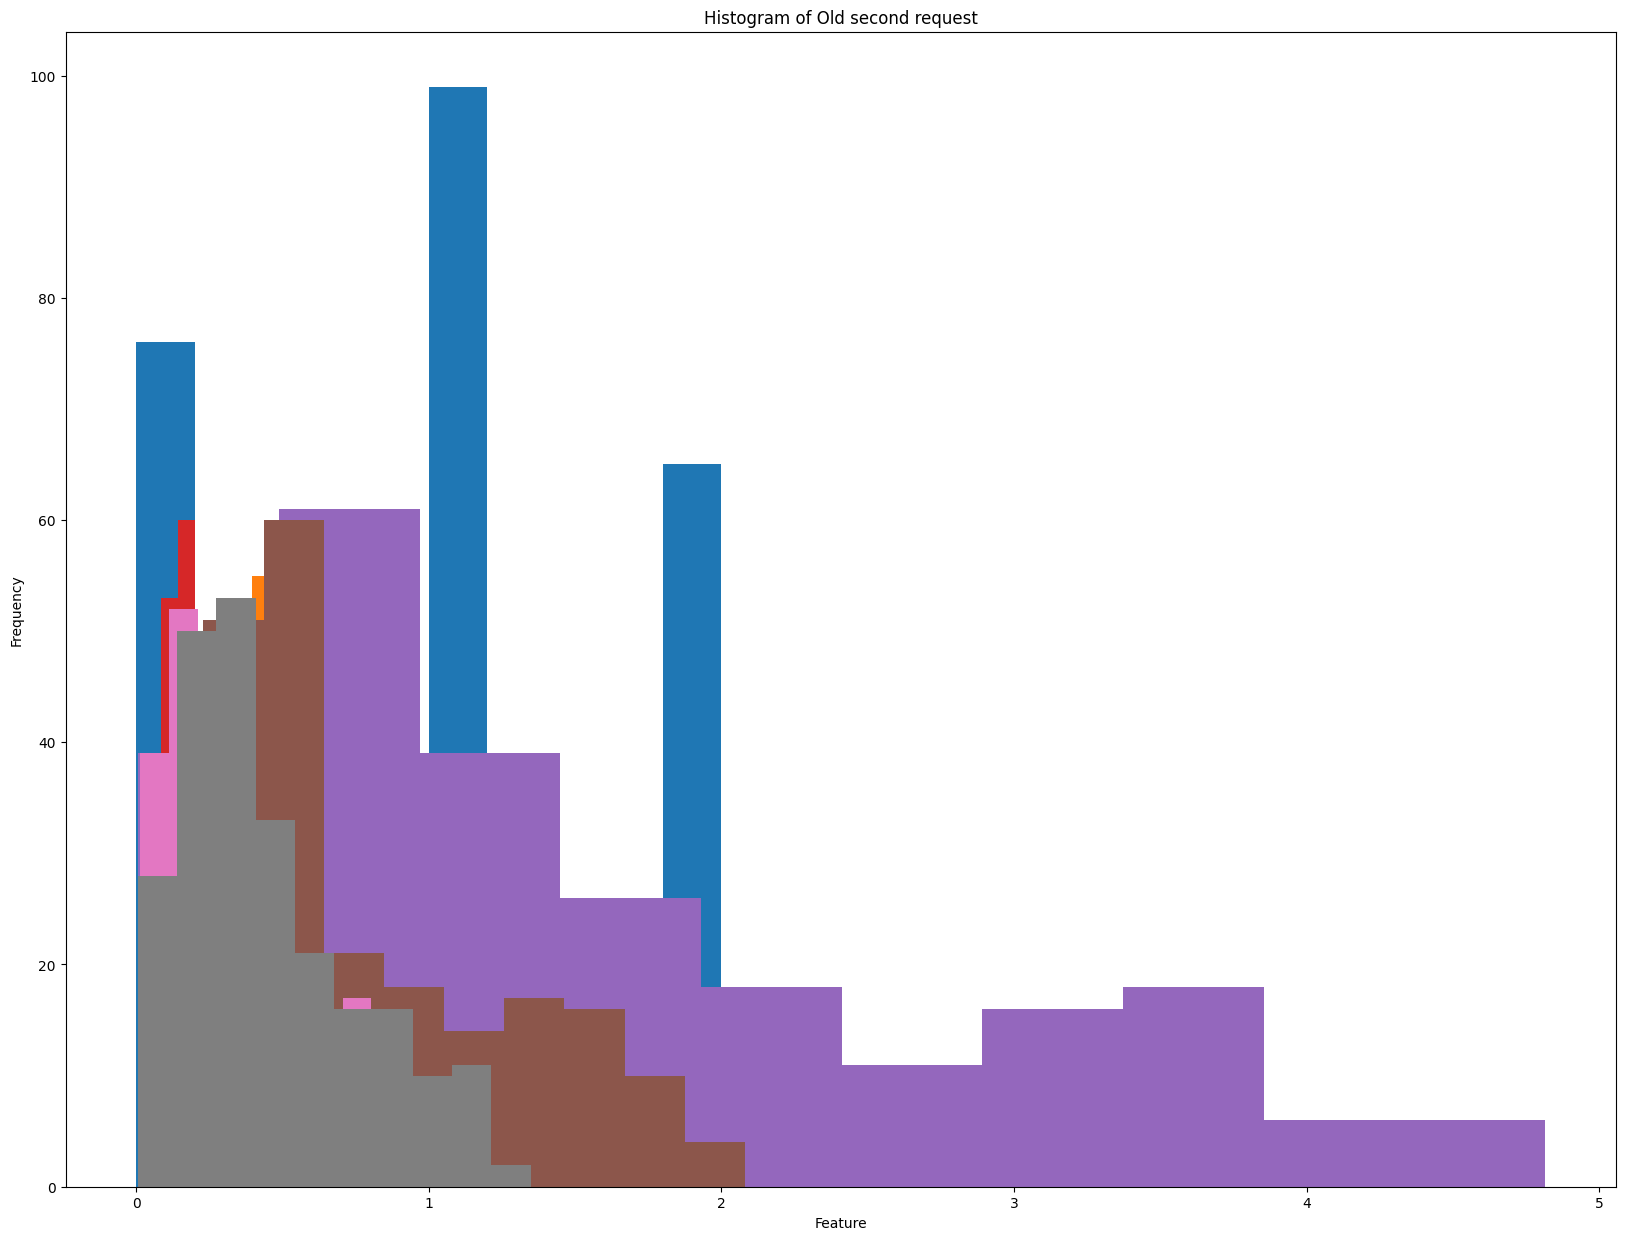

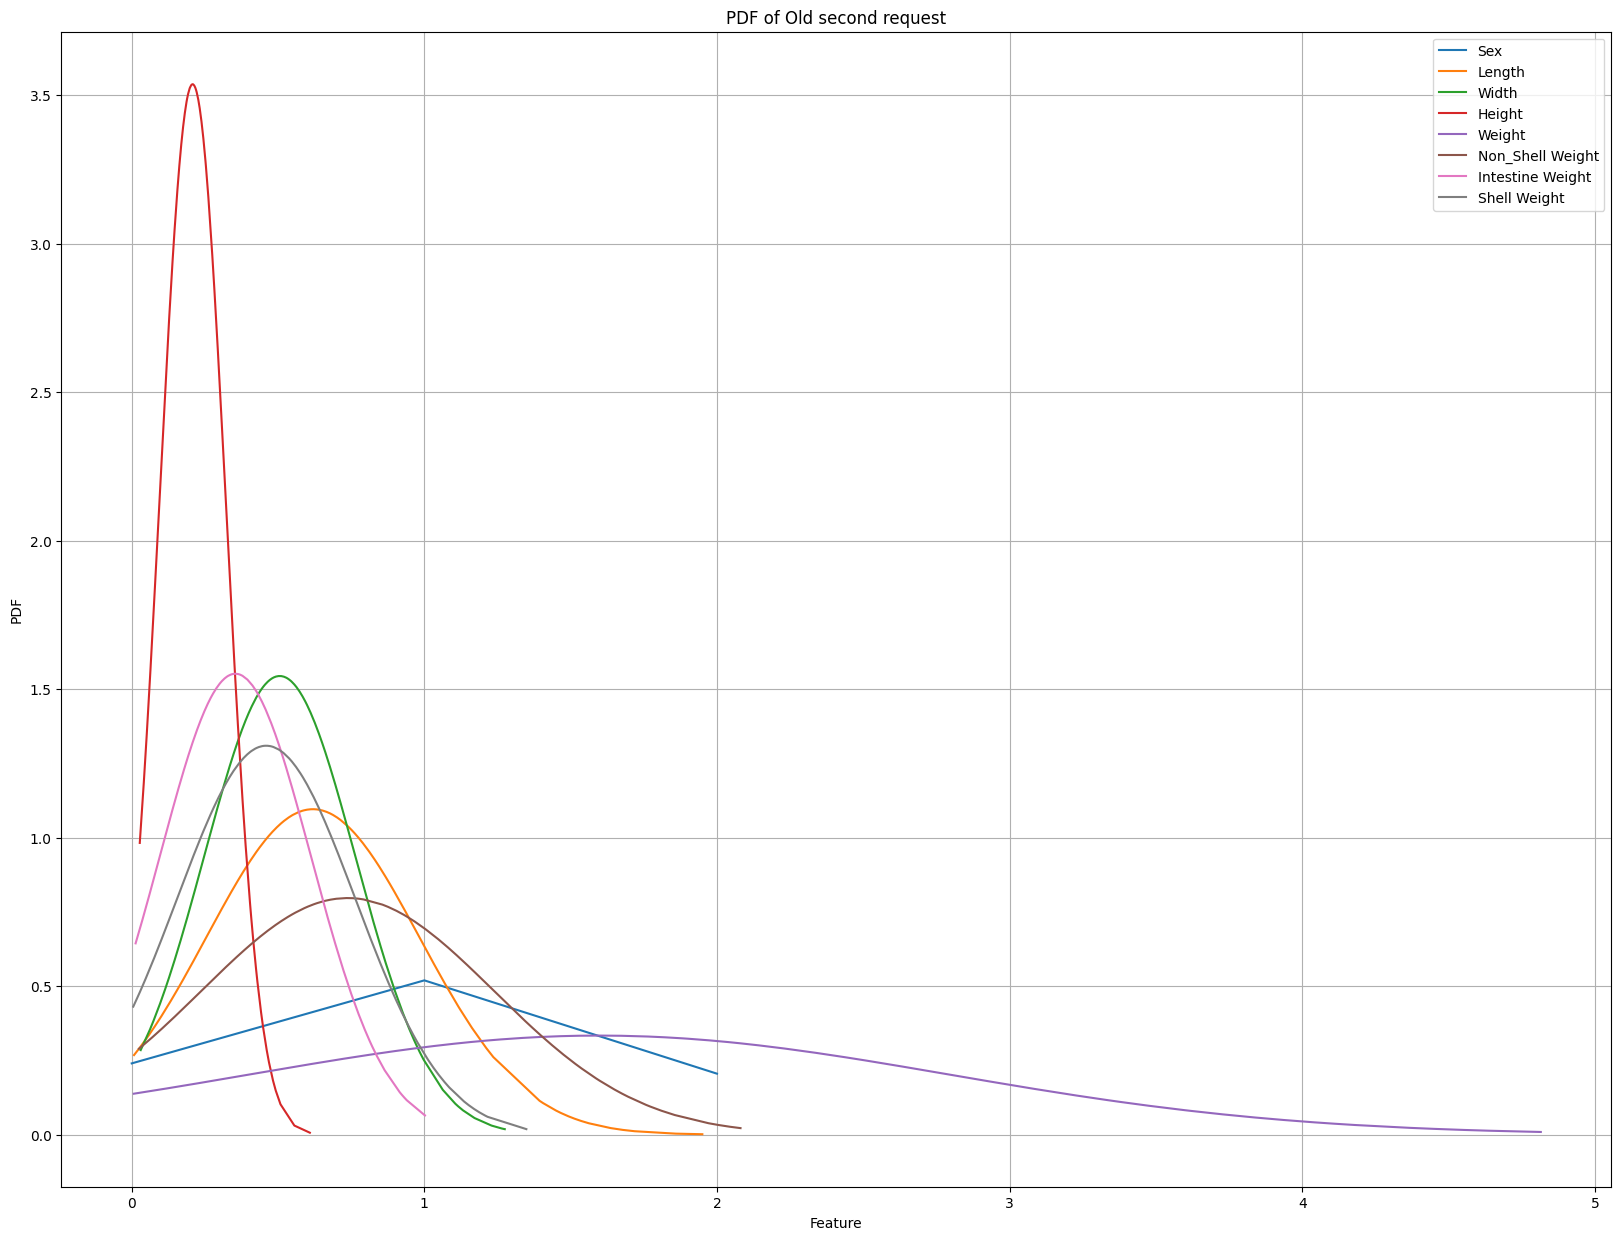

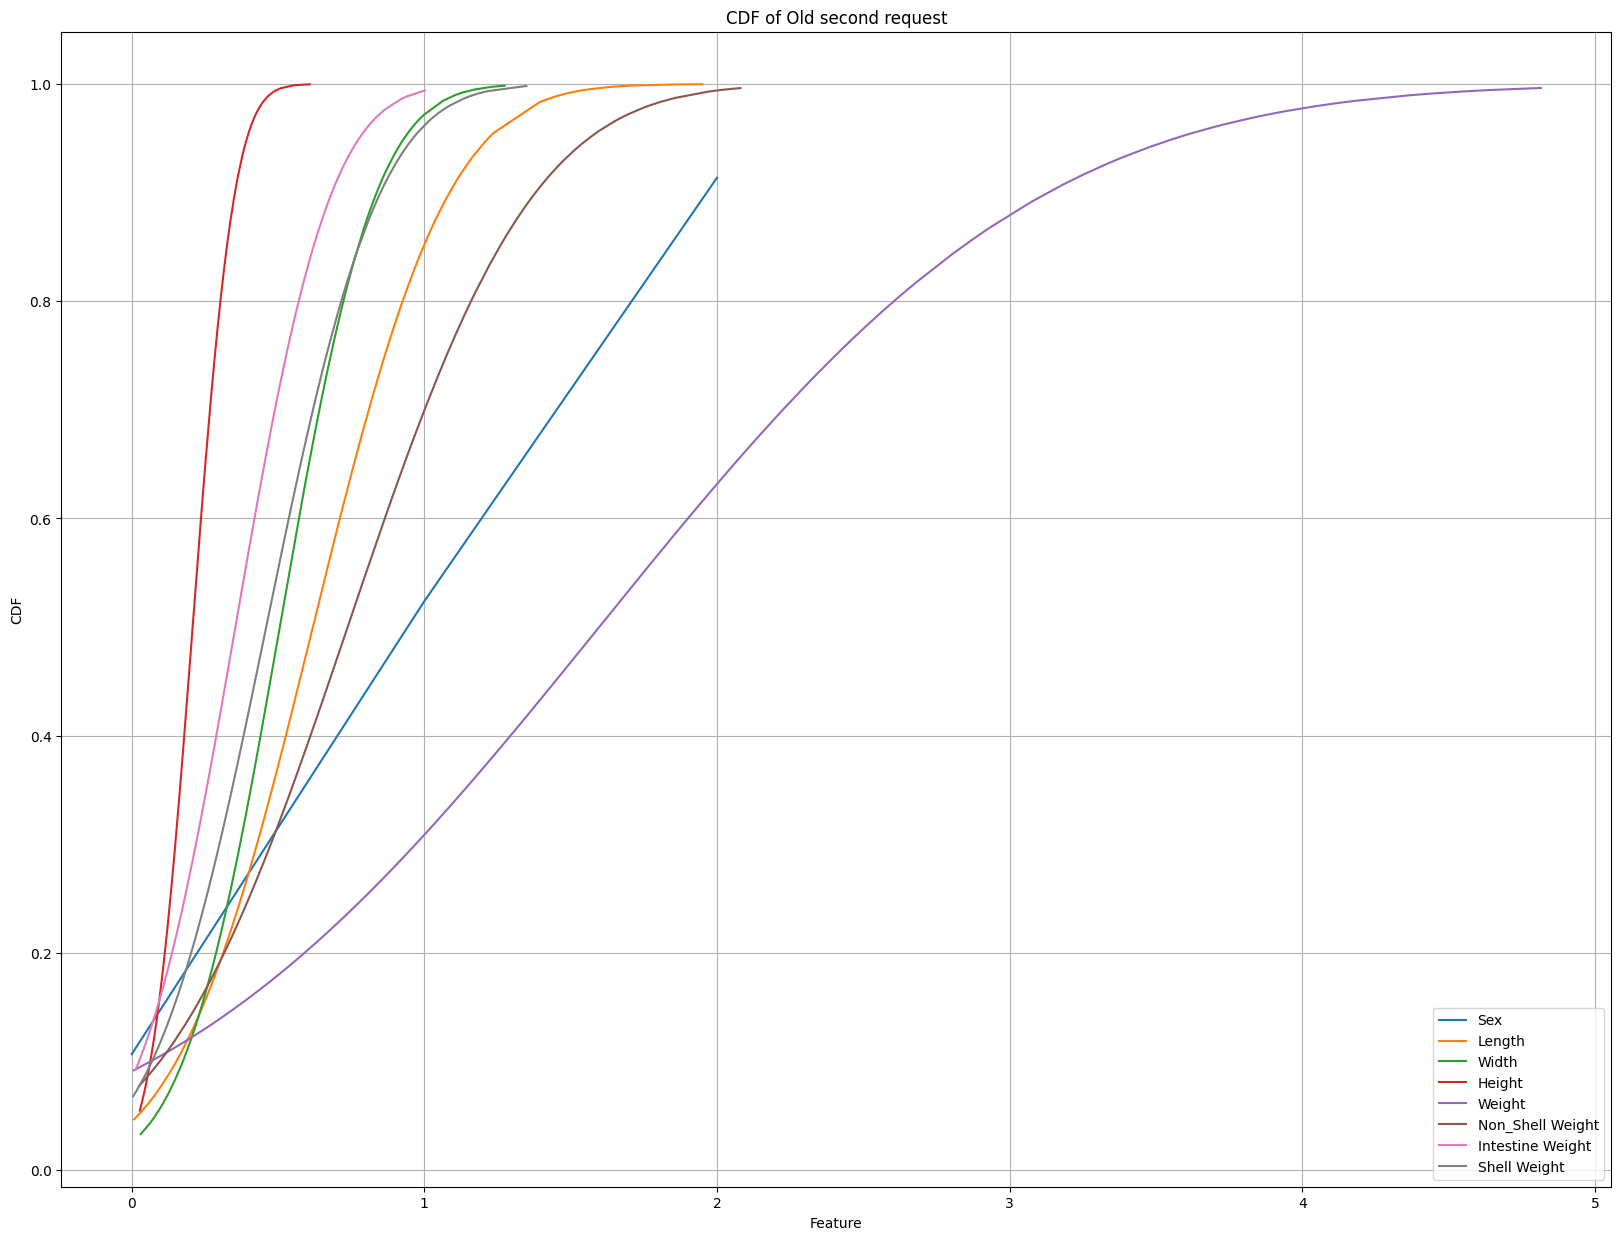

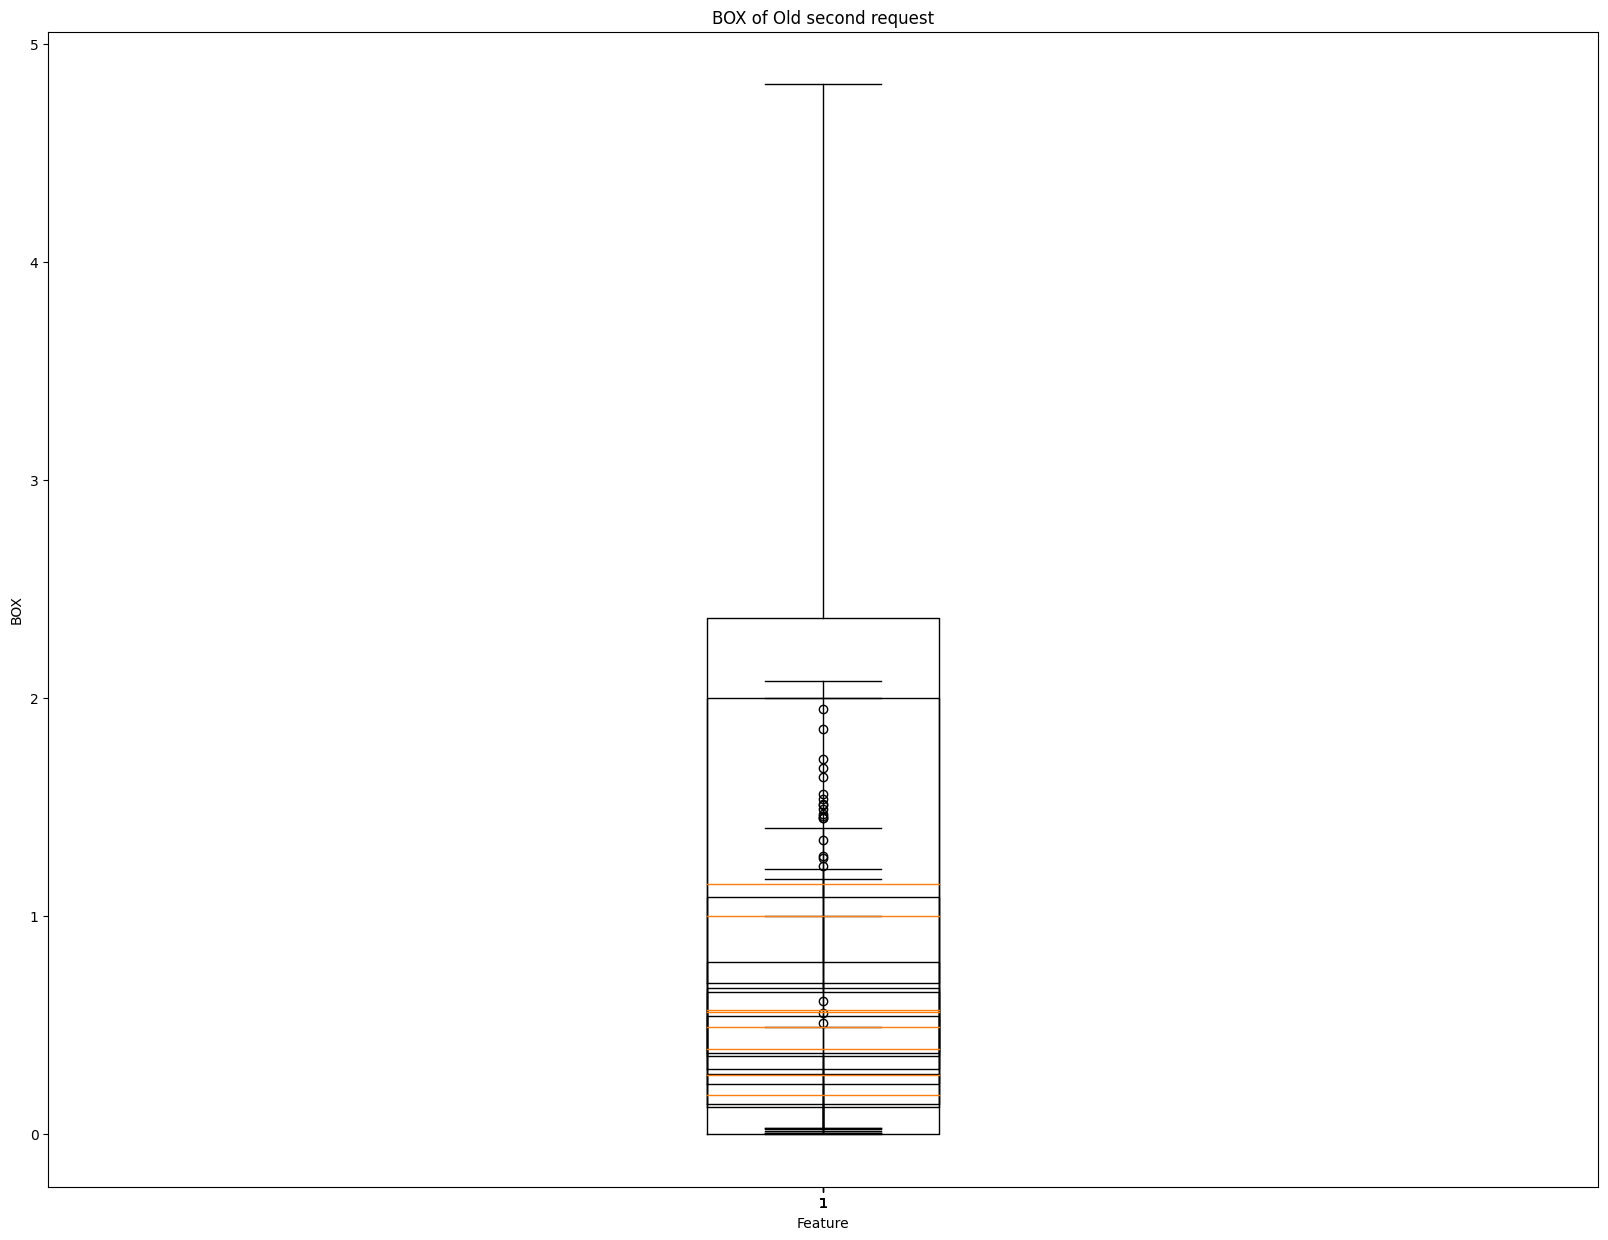

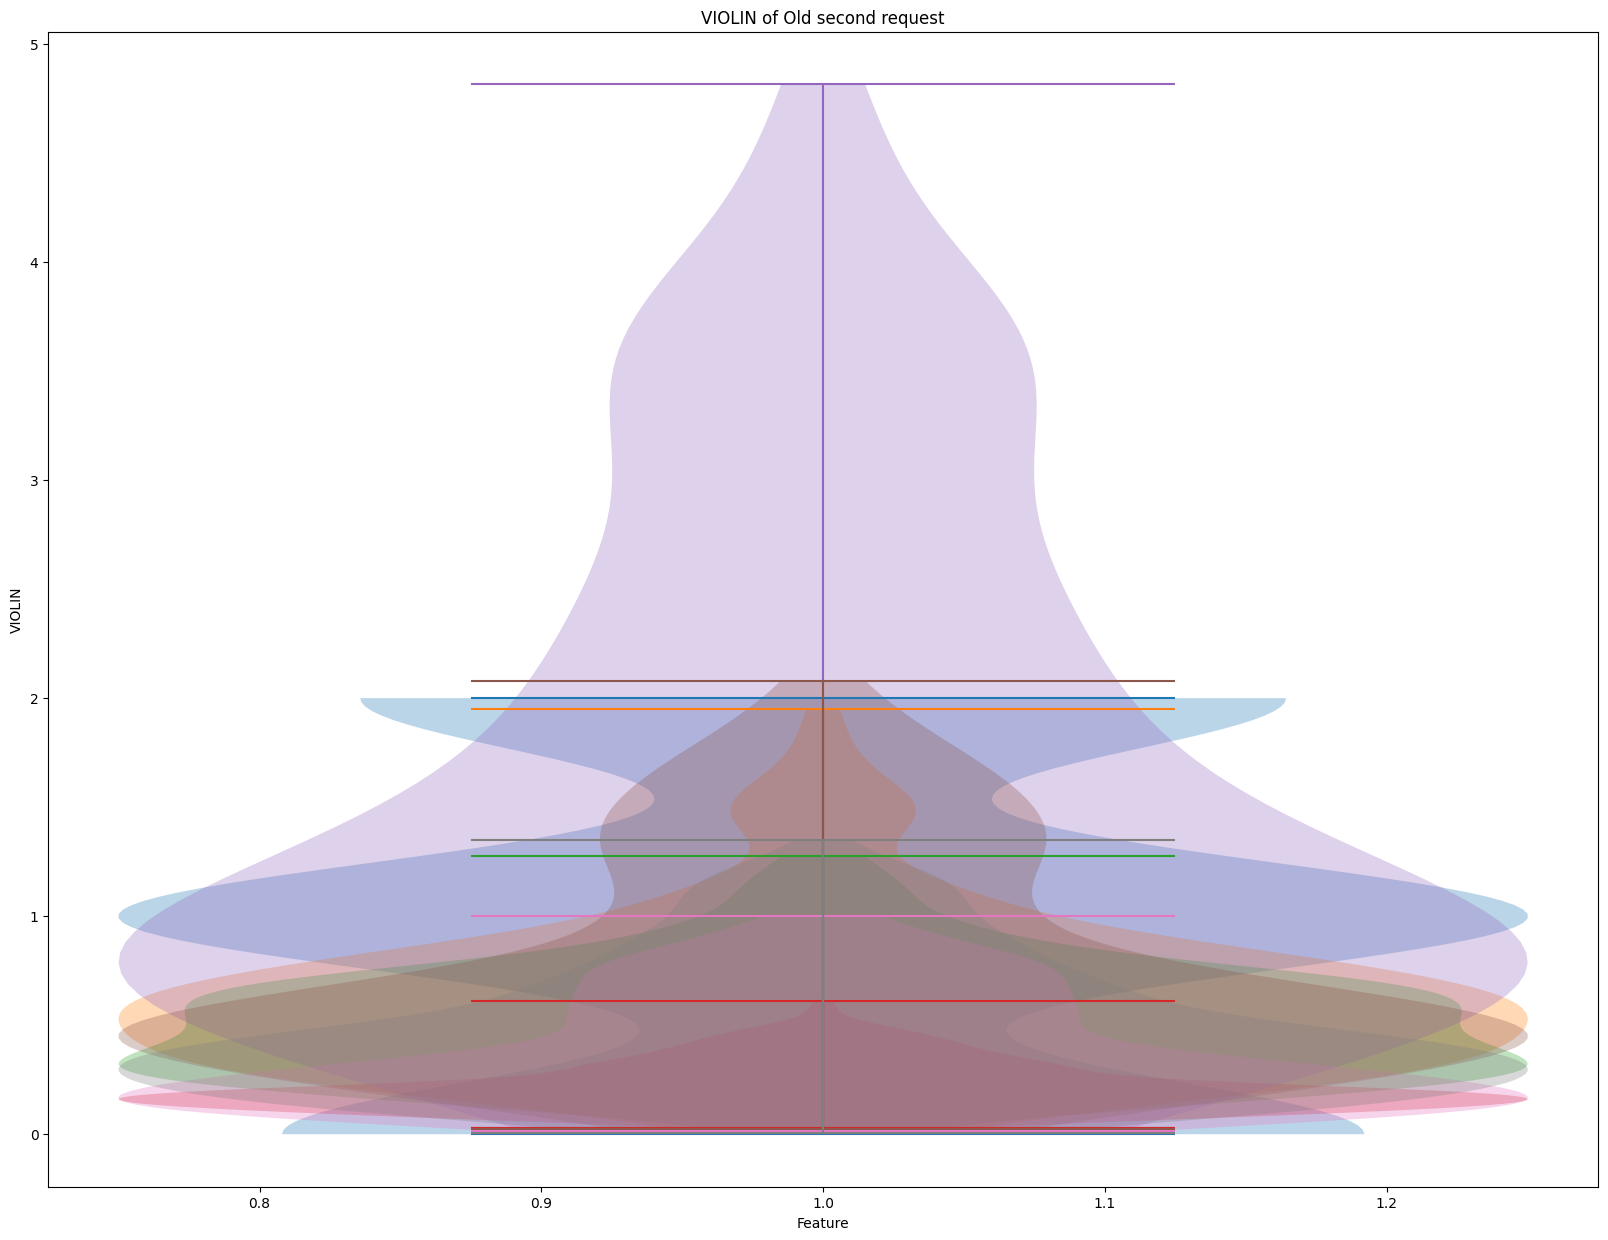

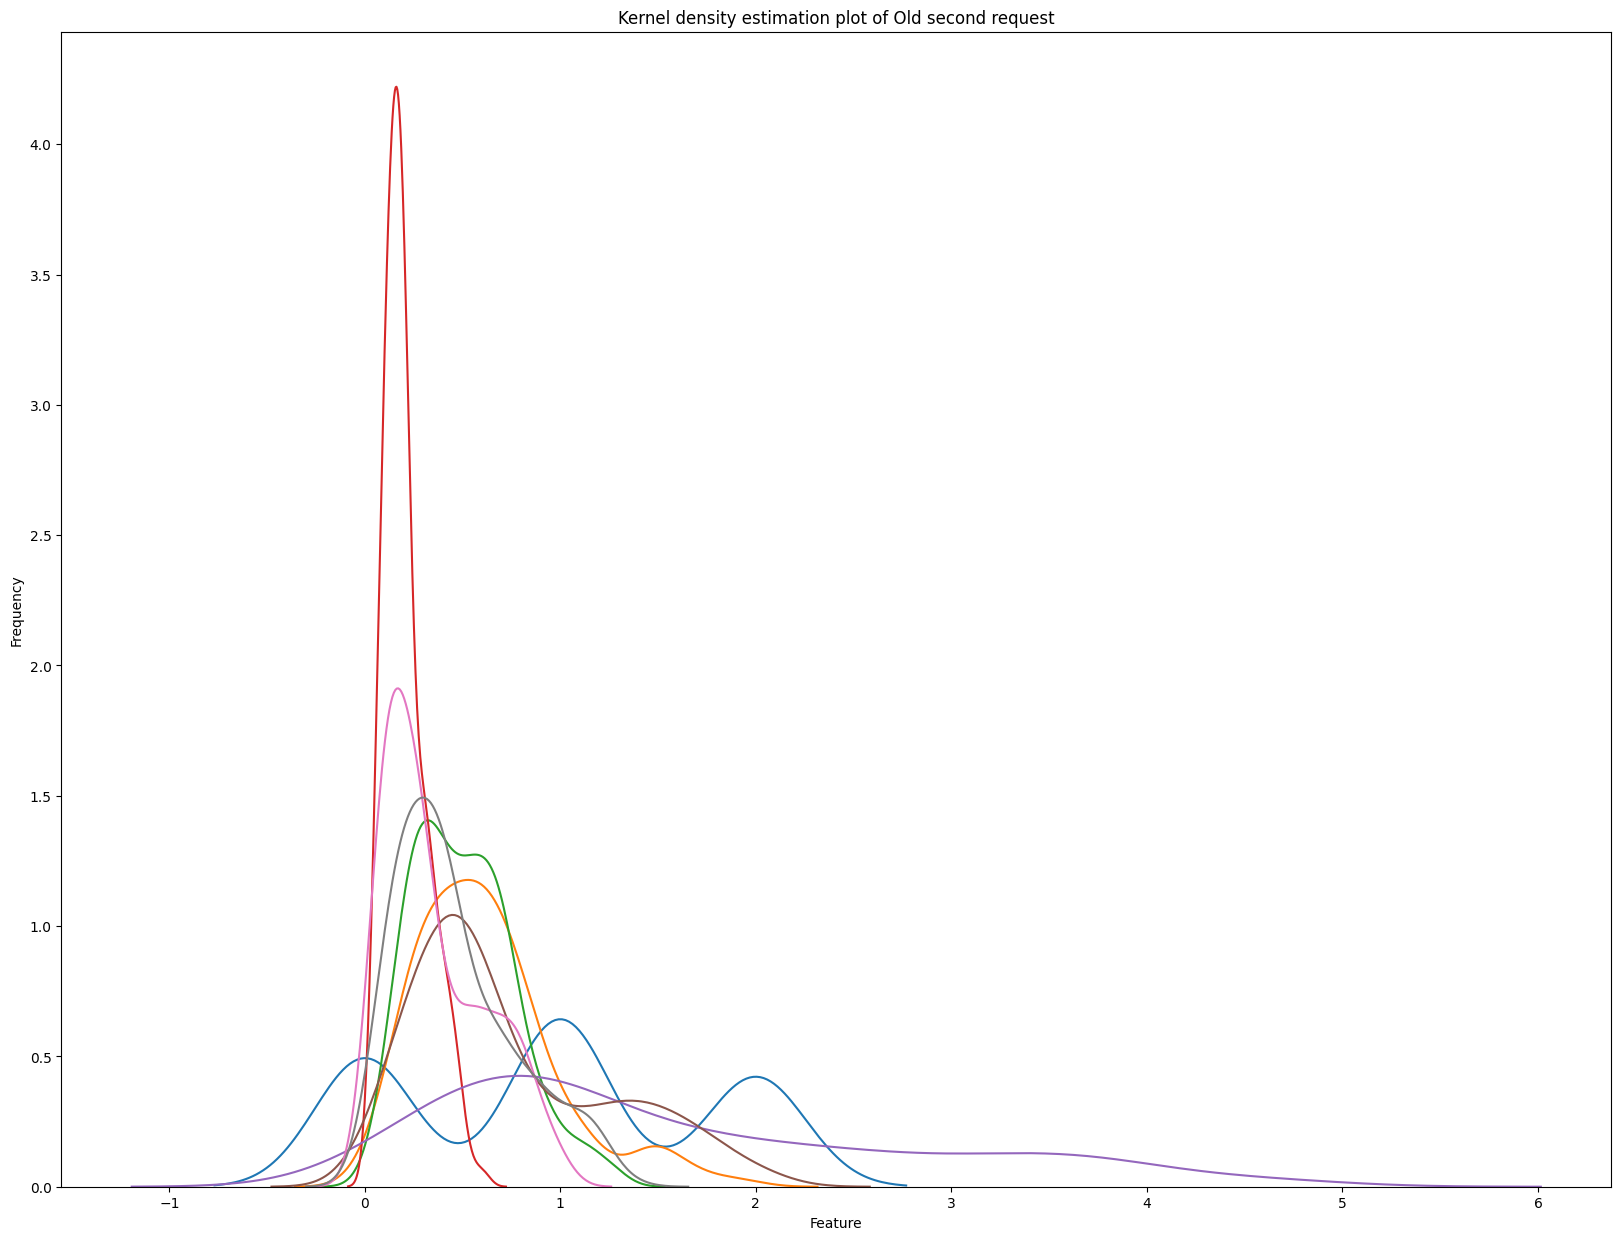

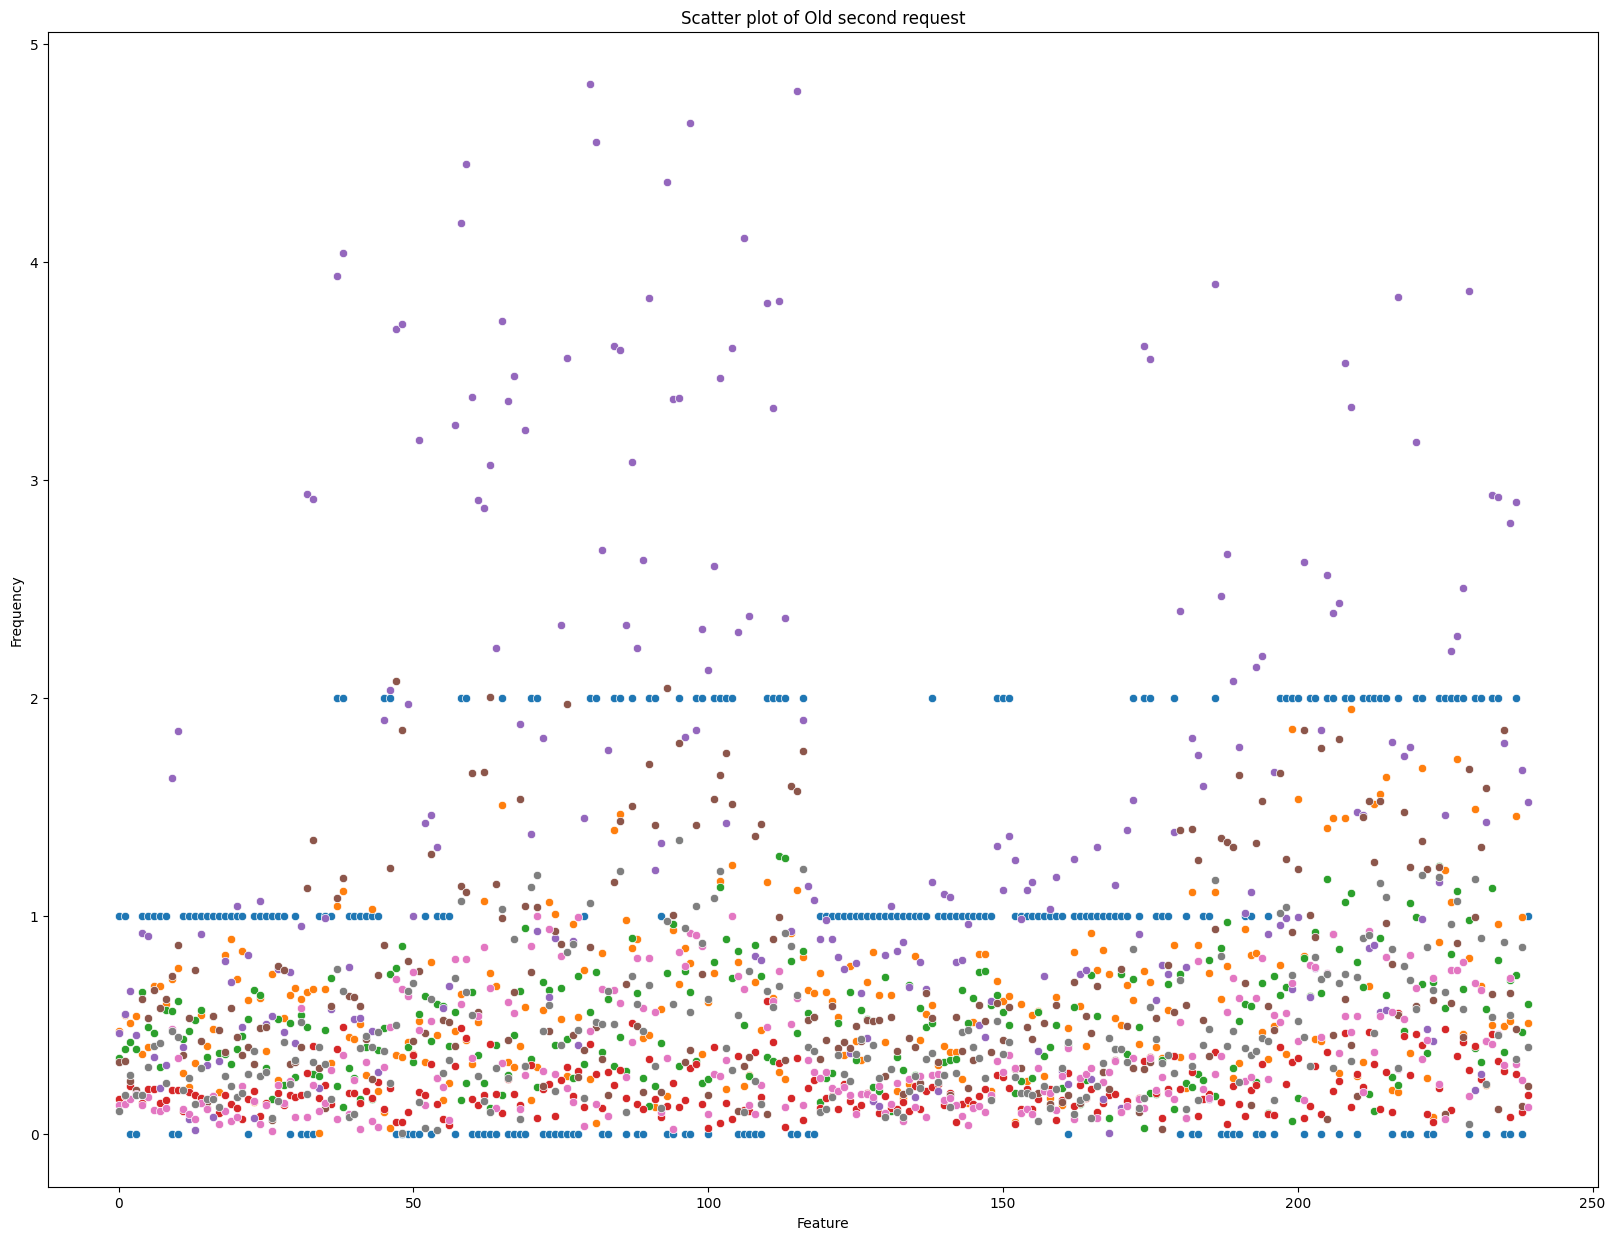

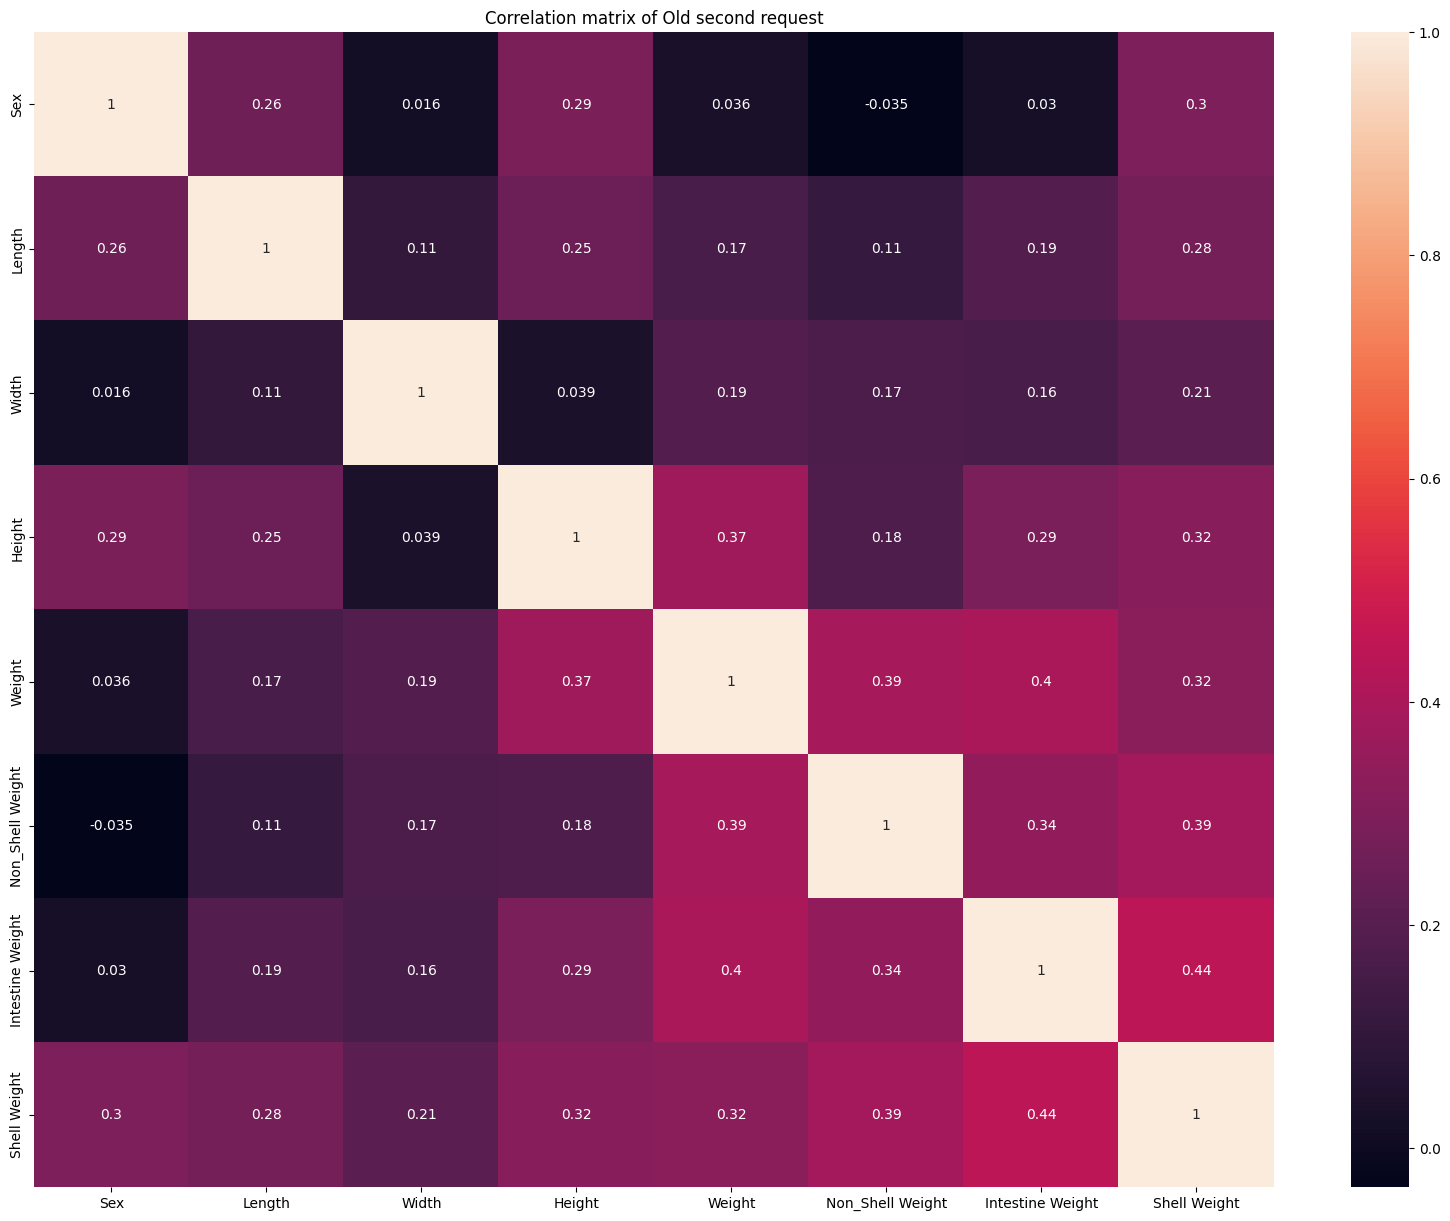

In [319]:
req_2_old = encode_labels(pd.read_csv("../results/data_requests/data_req_period_2_old.csv"), label_encoders)[0]
plot_all(req_2_old, "Old second request")

In [320]:
#data_req_period_2 = generate_lat_hyp_cube_datareq(data_point_count_req_2)
data_req_period_2 = encode_labels(pd.read_csv("../results/data_requests/data_req_period_2.csv"), label_encoders)[0]
data_req_period_2

Sex    Length     Width    Height    Weight  Non_Shell Weight  \
0      0  1.091125  0.157233  0.291152  2.004450          1.367294   
1      2  1.109583  0.465898  0.257994  2.495312          1.380527   
2      0  0.206904  0.275851  0.031522  0.410644          1.180181   
3      0  0.238467  0.647132  0.162869  2.389487          1.294790   
4      1  0.632384  0.264879  0.135572  0.138659          0.563649   
..   ...       ...       ...       ...       ...               ...   
283    1  0.332959  0.778686  0.279794  0.452047          2.217901   
284    1  0.948125  0.530982  0.242824  0.878386          2.029550   
285    1  1.059968  0.776553  0.223956  0.655251          2.108560   
286    1  0.825682  1.162848  0.302918  1.345248          2.104372   
287    0  0.578015  0.527076  0.219806  0.356673          2.165066   

     Intestine Weight  Shell Weight  
0            0.222351      0.513790  
1            0.457474      0.992621  
2            0.353468      0.781642  
3            0.500283      0.617061  
4            0.007389      0.381633  
..                ...           ...  
283          0.433007      0.404685  
284          0.574289      0.366081  
285          0.125320      0.259794  
286          0.242048      0.412497  
287          0.326329      0.355300  

[288 rows x 8 columns]

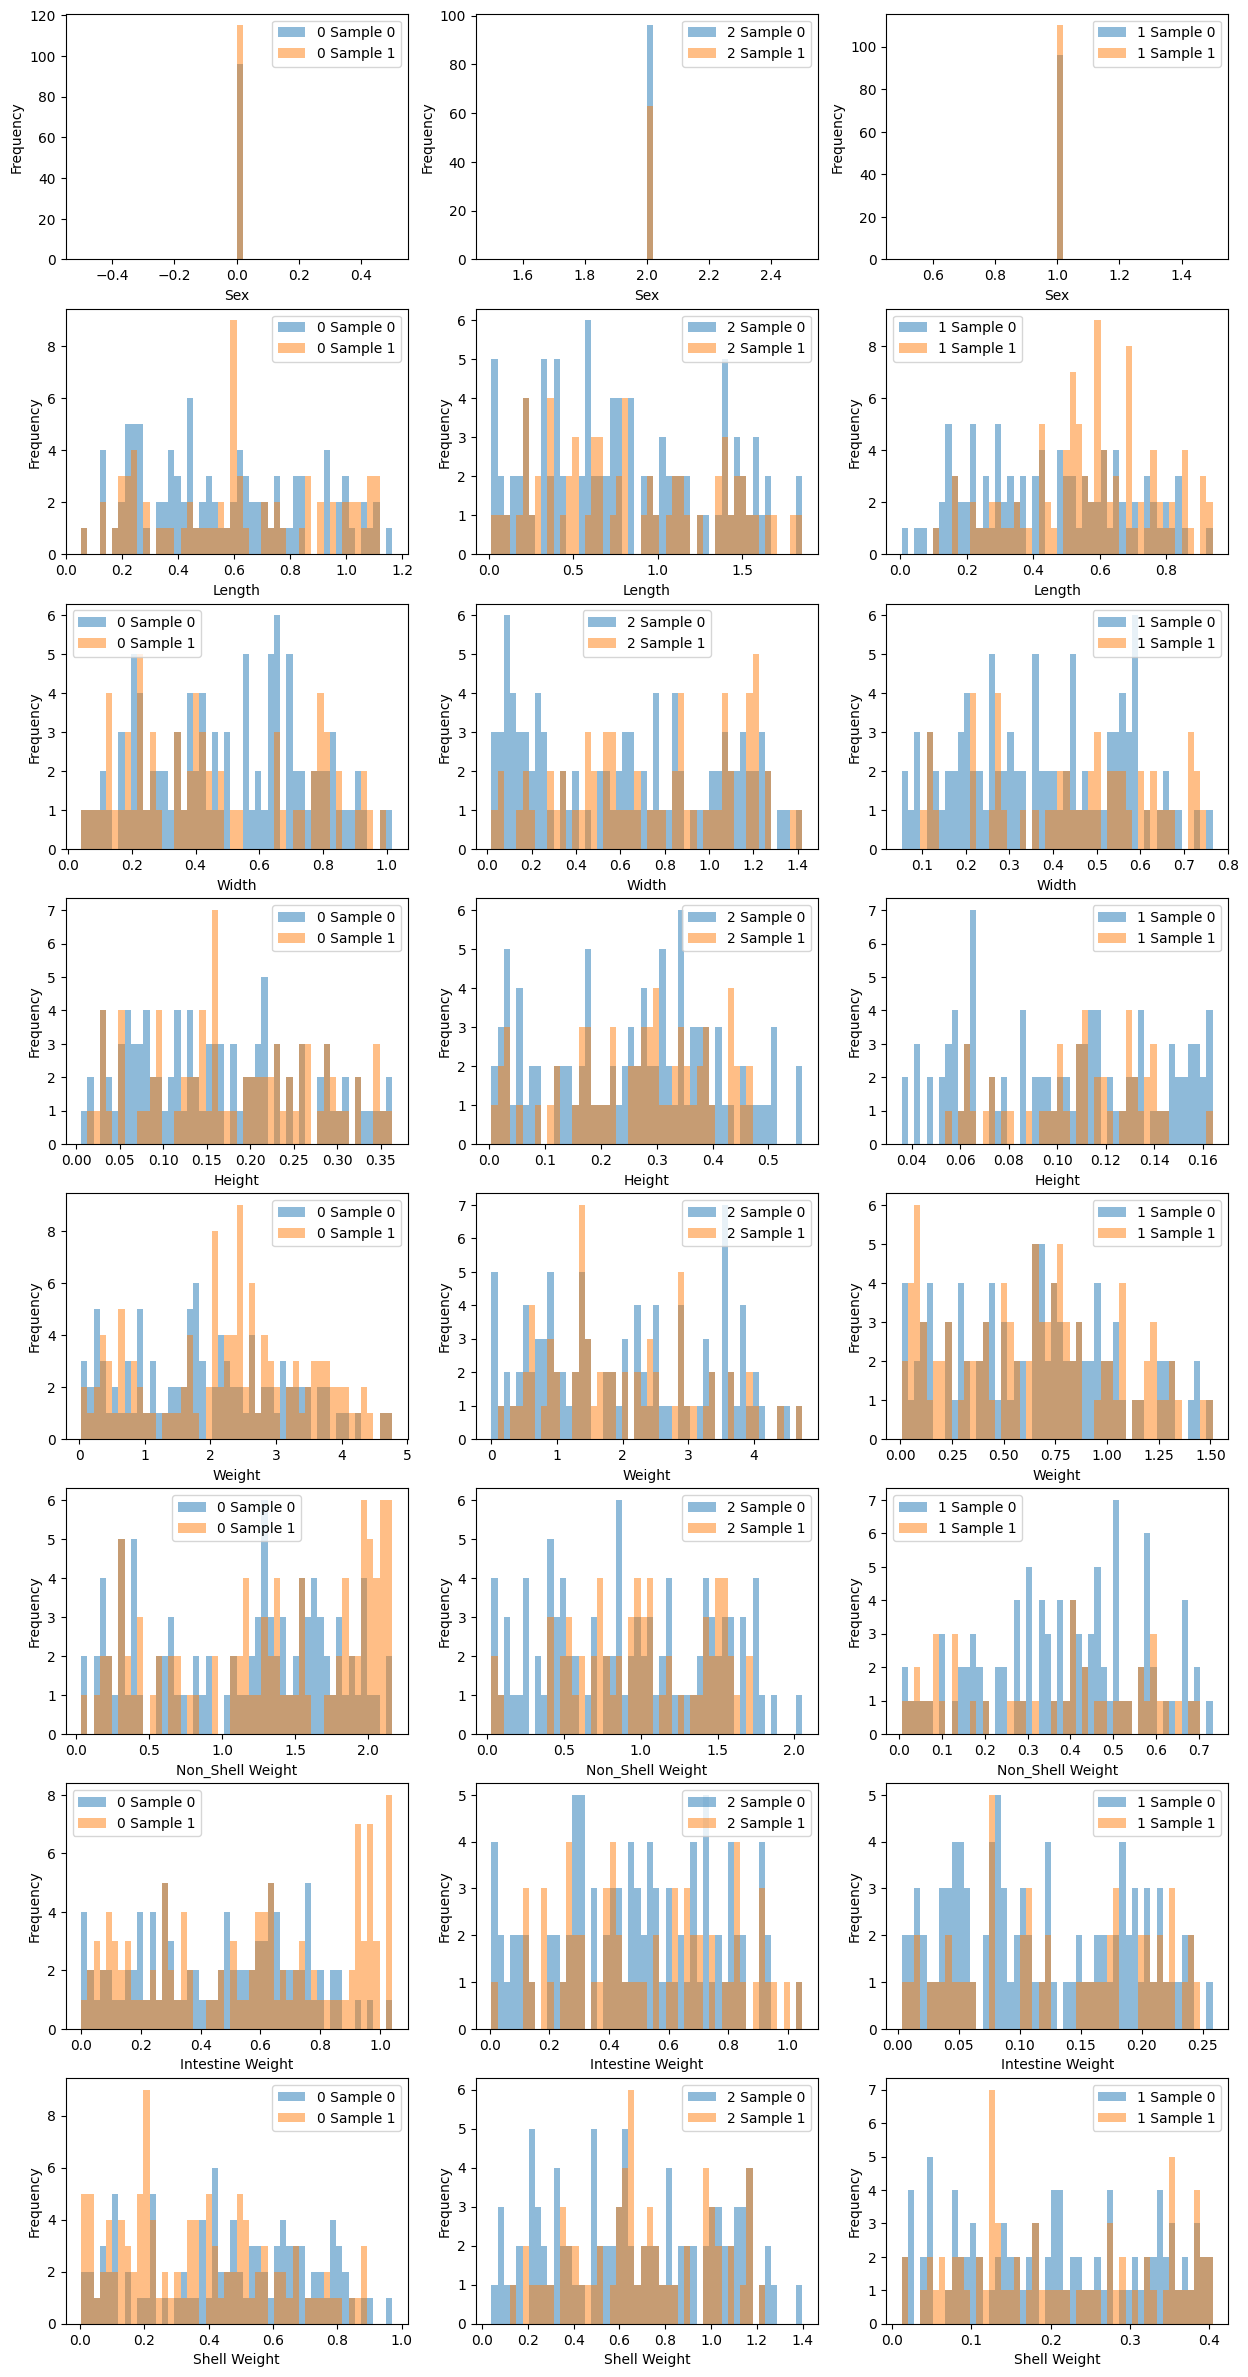

In [321]:
plot_samples(split_dataset(data_req_period_1, "Sex"), split_dataset(data_req_period_2, "Sex"))

In [322]:
data_req_period_2_decoded = decode_labels(data_req_period_2, label_encoders)
data_req_period_2_decoded.to_csv("../results/data_requests/data_req_period_2.csv", index=False)

#### Second batch of data

In [323]:
second_batch_data = pd.read_csv("../data/batch2_laskowicz_labels.csv")
second_batch_data

Sex    Length     Width    Height    Weight  Non_Shell Weight  \
0     F  0.366805  0.632528  0.190831  3.065267          0.101366   
1     F  0.497467  0.714280  0.258426  2.437754          0.253056   
2     F  0.371993  0.243488  0.304708  3.106694          1.072935   
3     F  0.580485  0.292359  0.041360  2.139670          0.561327   
4     F  0.631938  0.742922  0.033617  3.695673          0.087739   
..   ..       ...       ...       ...       ...               ...   
235   I  0.631222  0.198593  0.103302  0.444455          0.639375   
236   I  0.491215  0.013010  0.054504  0.326175          0.333912   
237   I  0.509933  0.333399  0.136939  0.869618          0.217613   
238   I  0.315159  0.192376  0.098837  1.779237          0.248563   
239   I  0.629052  0.397442  0.135404  0.824312          0.372534   

     Intestine Weight  Shell Weight Stage of Life  
0            0.324844      0.294917         Adult  
1            0.756059      0.722063         Adult  
2            0.821989      0.036689         Adult  
3            0.647463      1.011899         Adult  
4            0.466397      0.217857         Adult  
..                ...           ...           ...  
235          0.107750      0.020512         Adult  
236          0.142419      0.334970         Child  
237          0.062229      0.036036         Adult  
238          0.112084      0.250240         Adult  
239          0.021783      0.120860         Adult  

[240 rows x 9 columns]

In [324]:
molluscs_data = encode_labels(pd.concat([initial_molluscs_data, first_batch_data, second_batch_data], ignore_index=True), label_encoders)[0]
molluscs_data

Sex    Length     Width    Height    Weight  Non_Shell Weight  \
0      0  0.450000  0.345000  0.120000  0.416500          0.165500   
1      0  0.475000  0.380000  0.145000  0.570000          0.167000   
2      2  0.610000  0.485000  0.170000  1.022500          0.419000   
3      1  0.430000  0.340000  0.105000  0.440500          0.238500   
4      2  0.205000  0.155000  0.045000  0.042500          0.017000   
..   ...       ...       ...       ...       ...               ...   
539    1  0.631222  0.198593  0.103302  0.444455          0.639375   
540    1  0.491215  0.013010  0.054504  0.326175          0.333912   
541    1  0.509933  0.333399  0.136939  0.869618          0.217613   
542    1  0.315159  0.192376  0.098837  1.779237          0.248563   
543    1  0.629052  0.397442  0.135404  0.824312          0.372534   

     Intestine Weight  Shell Weight  Stage of Life  
0            0.095000      0.135000              1  
1            0.118000      0.187000              0  
2            0.240500      0.360000              1  
3            0.074500      0.107500              0  
4            0.005500      0.015500              1  
..                ...           ...            ...  
539          0.107750      0.020512              1  
540          0.142419      0.334970              2  
541          0.062229      0.036036              1  
542          0.112084      0.250240              1  
543          0.021783      0.120860              1  

[544 rows x 9 columns]

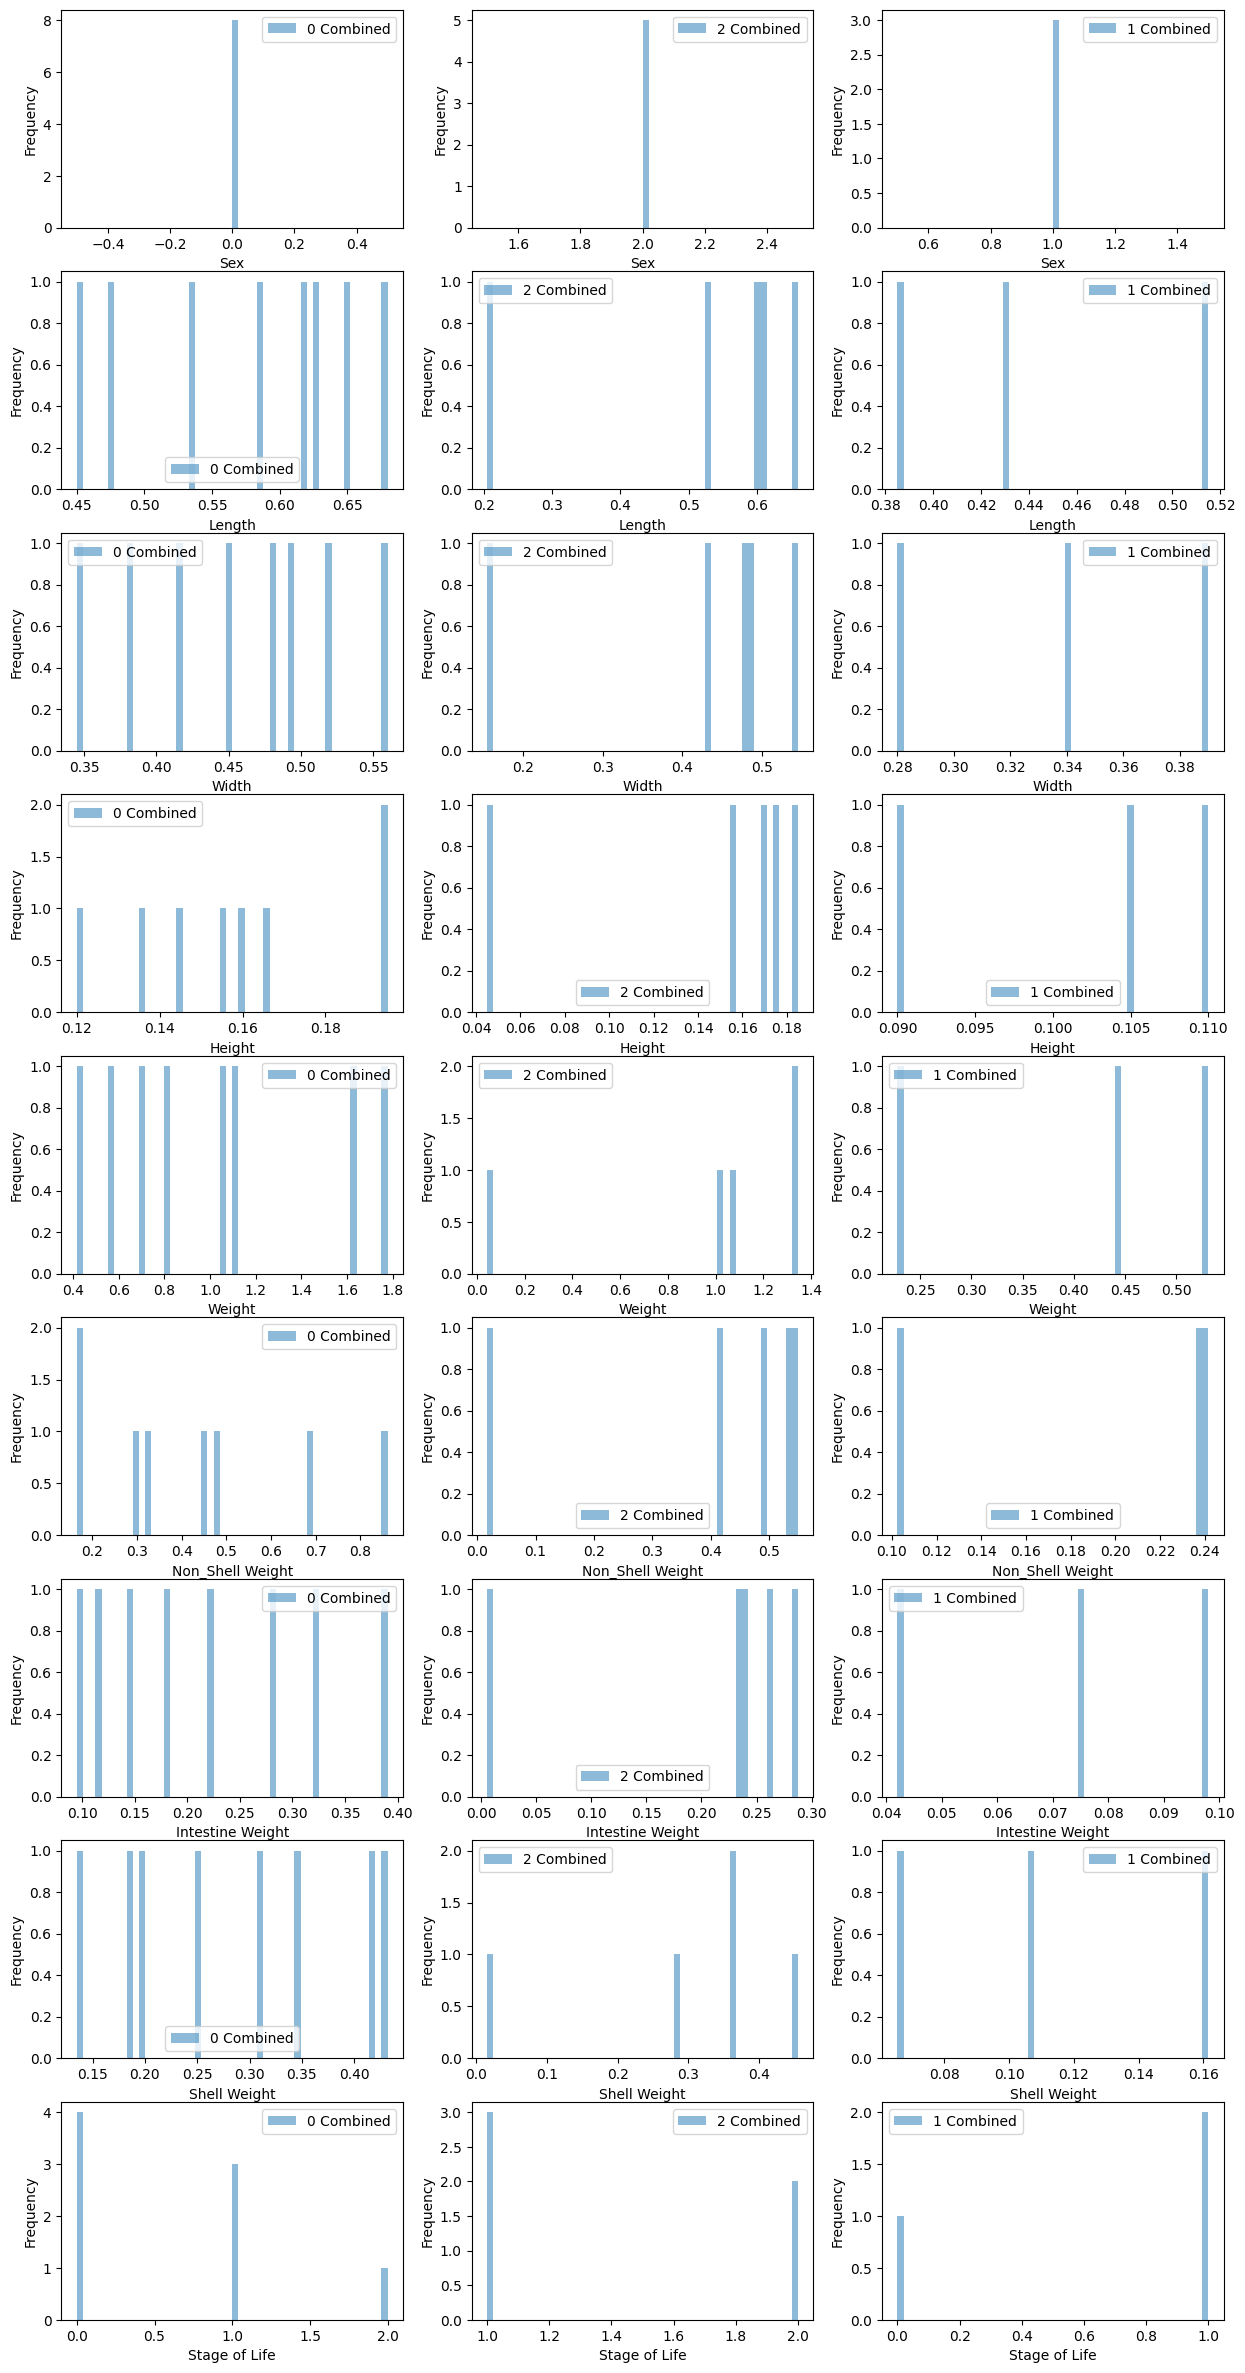

In [325]:
plot_samples(molluscs_data_dict, titles=["Combined"], include_stage_of_life=True)

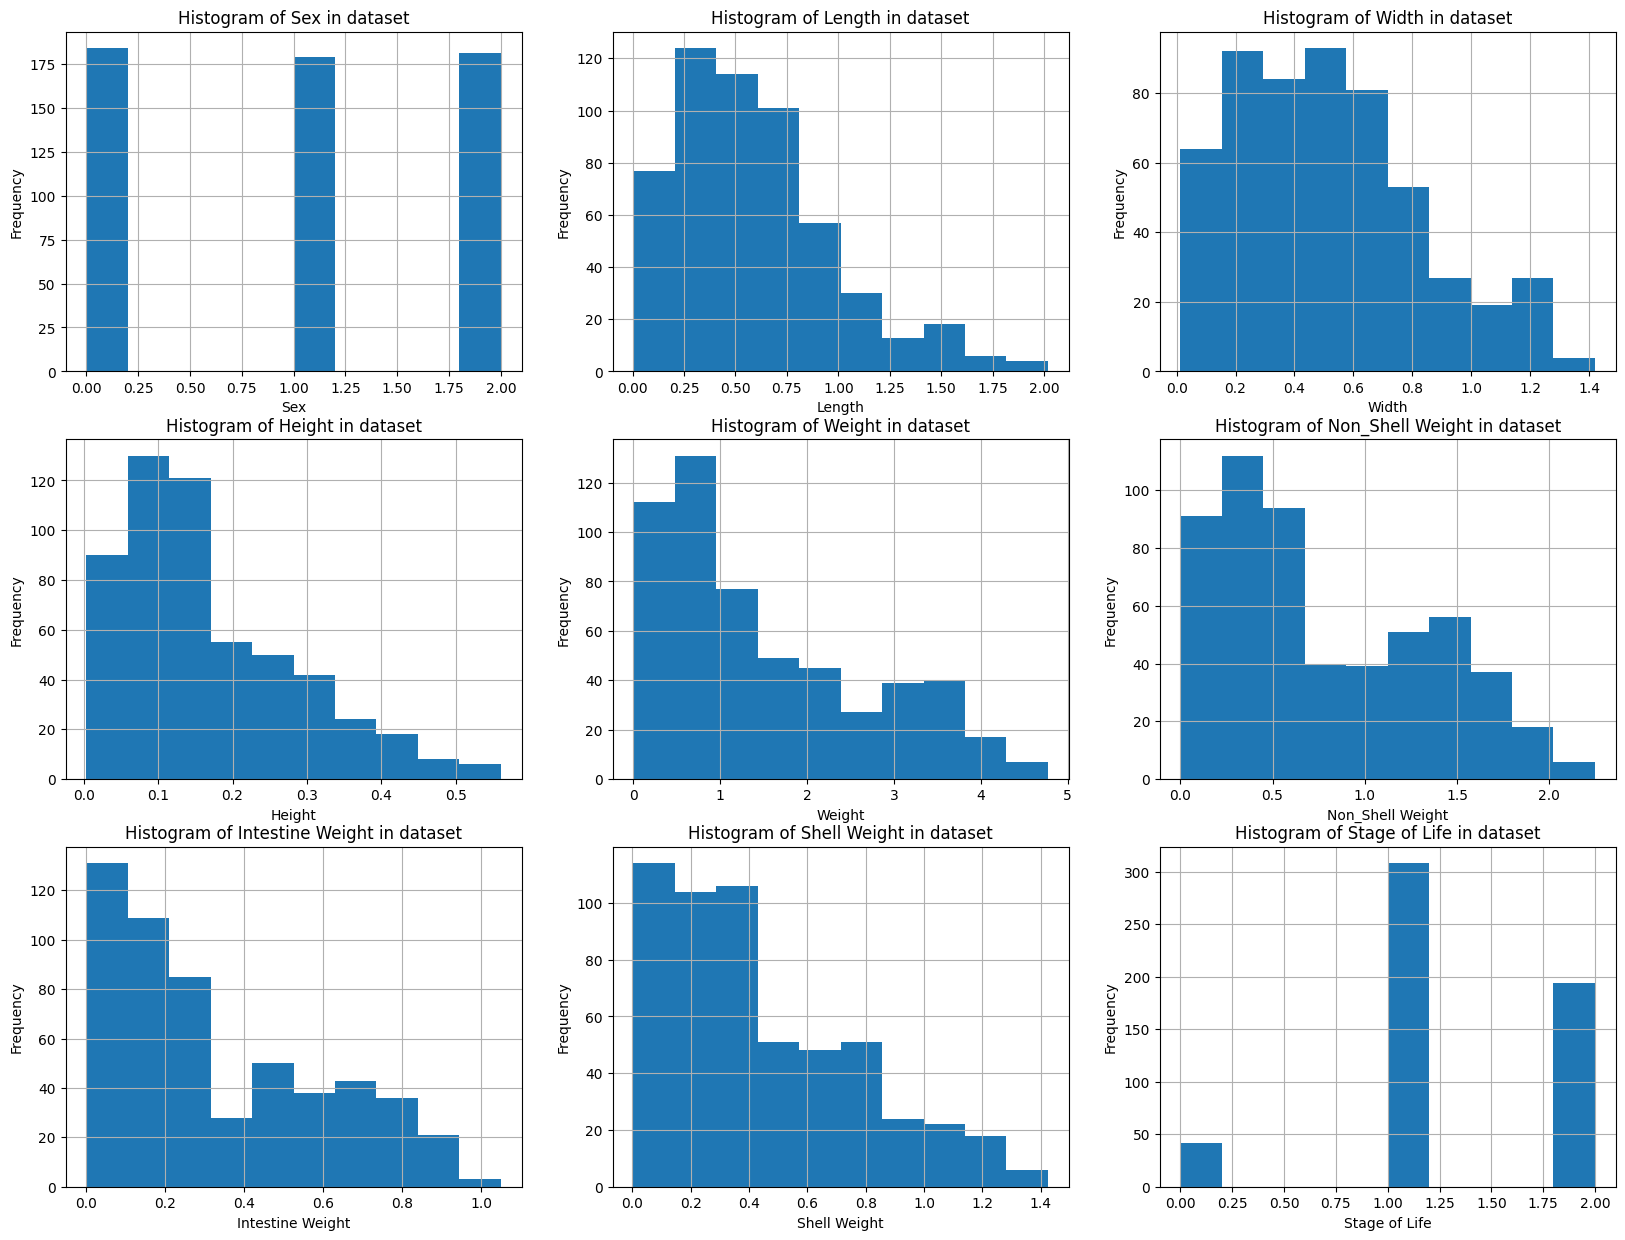

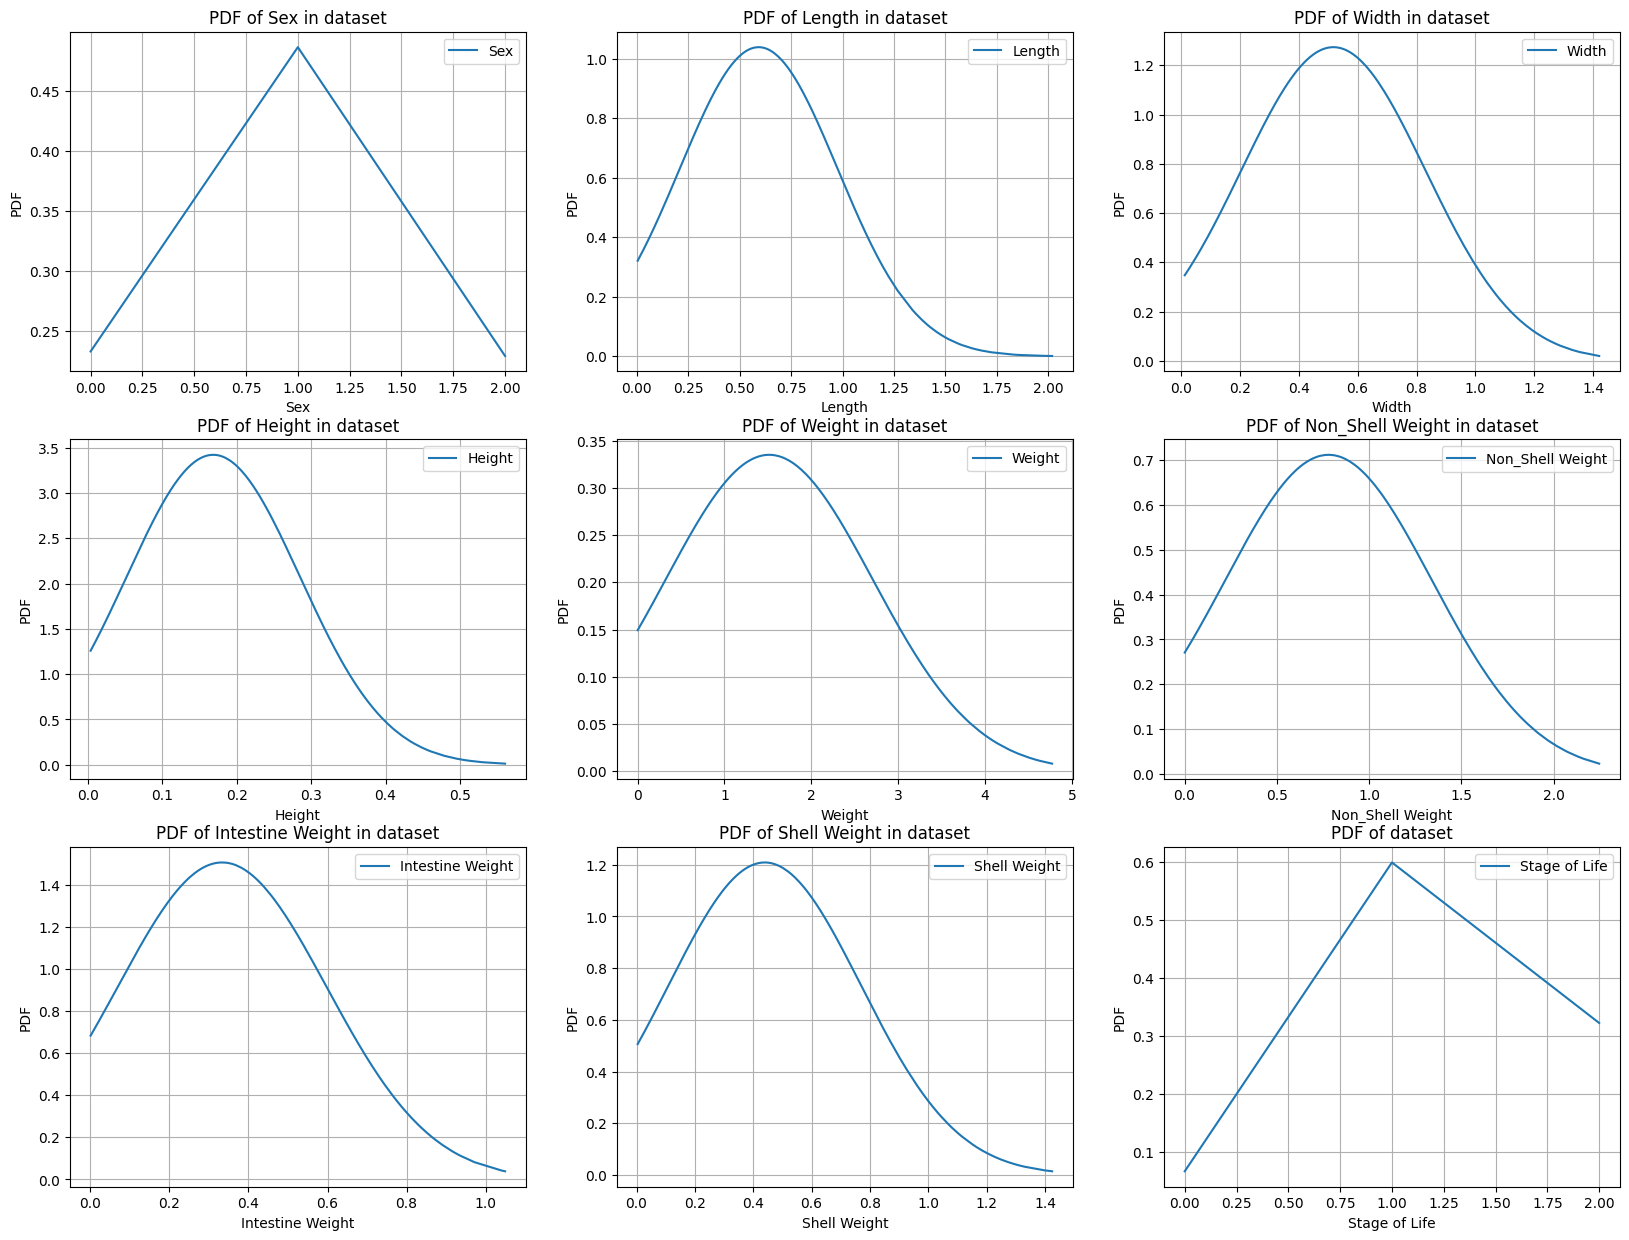

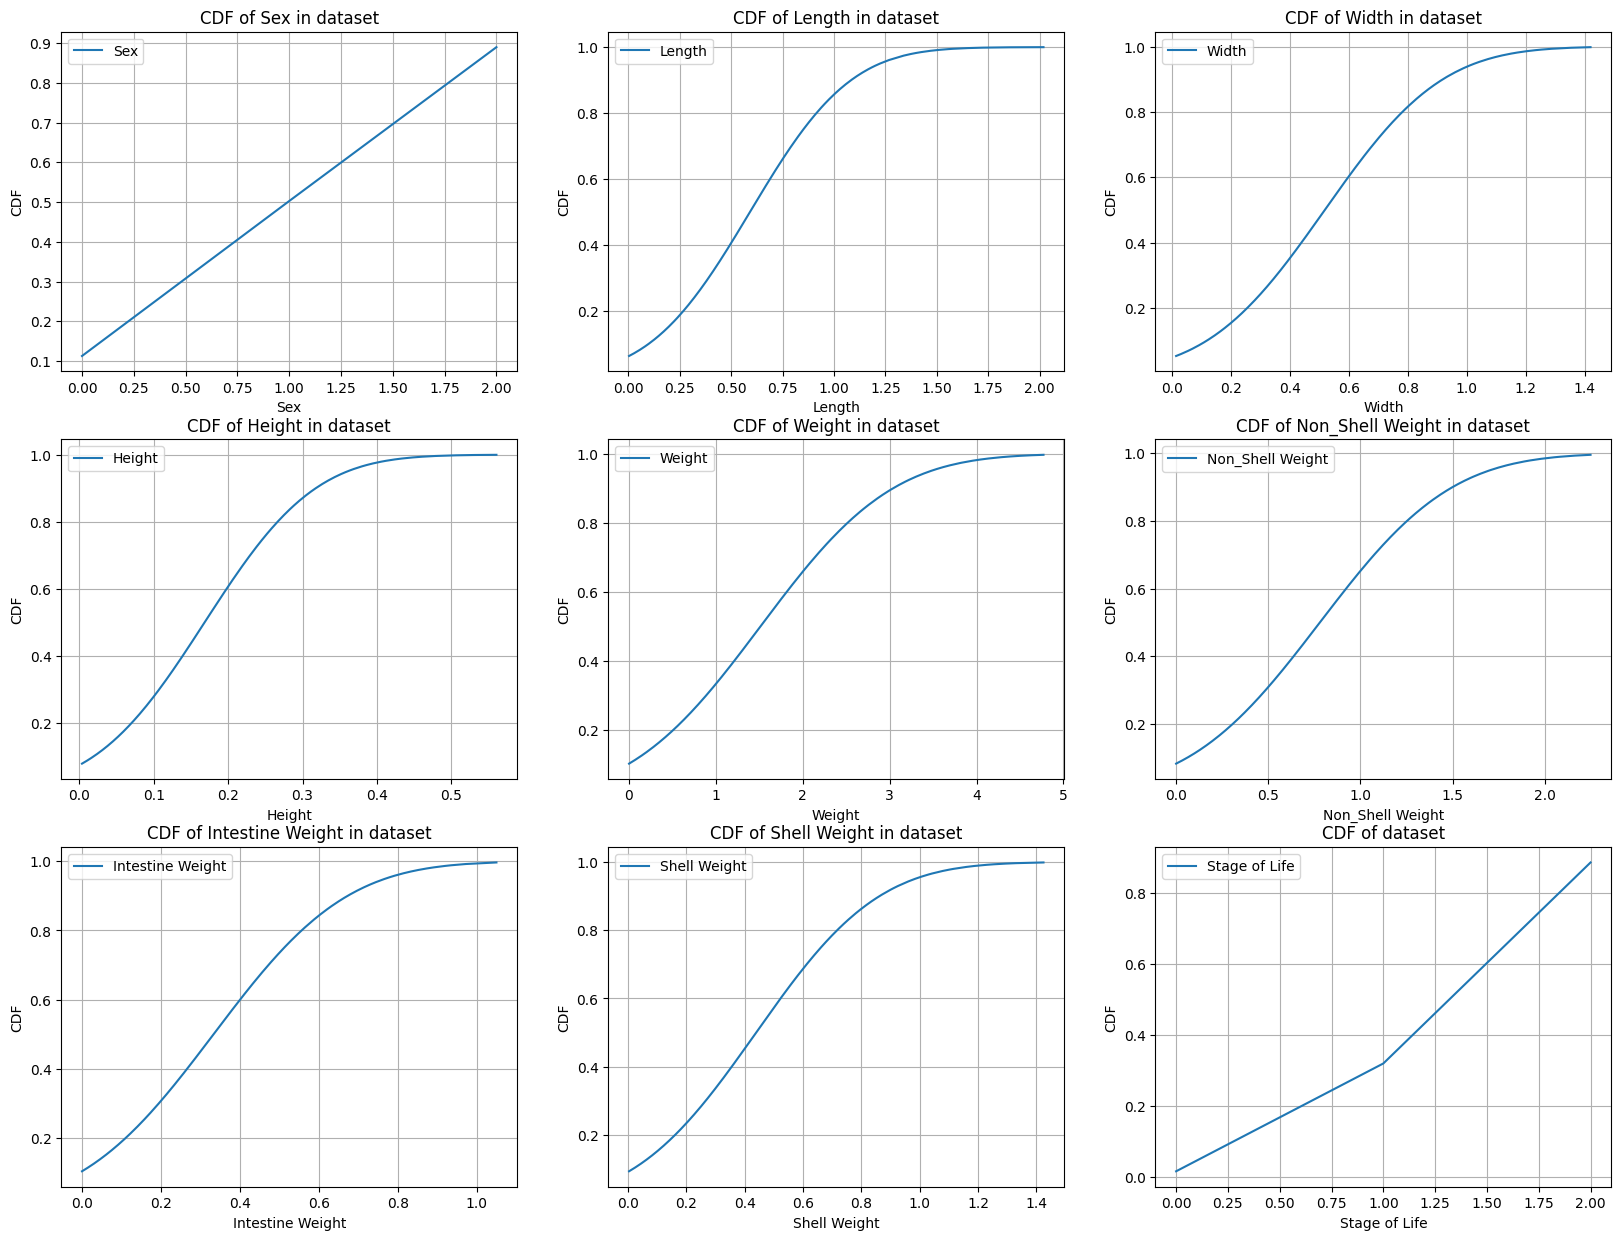

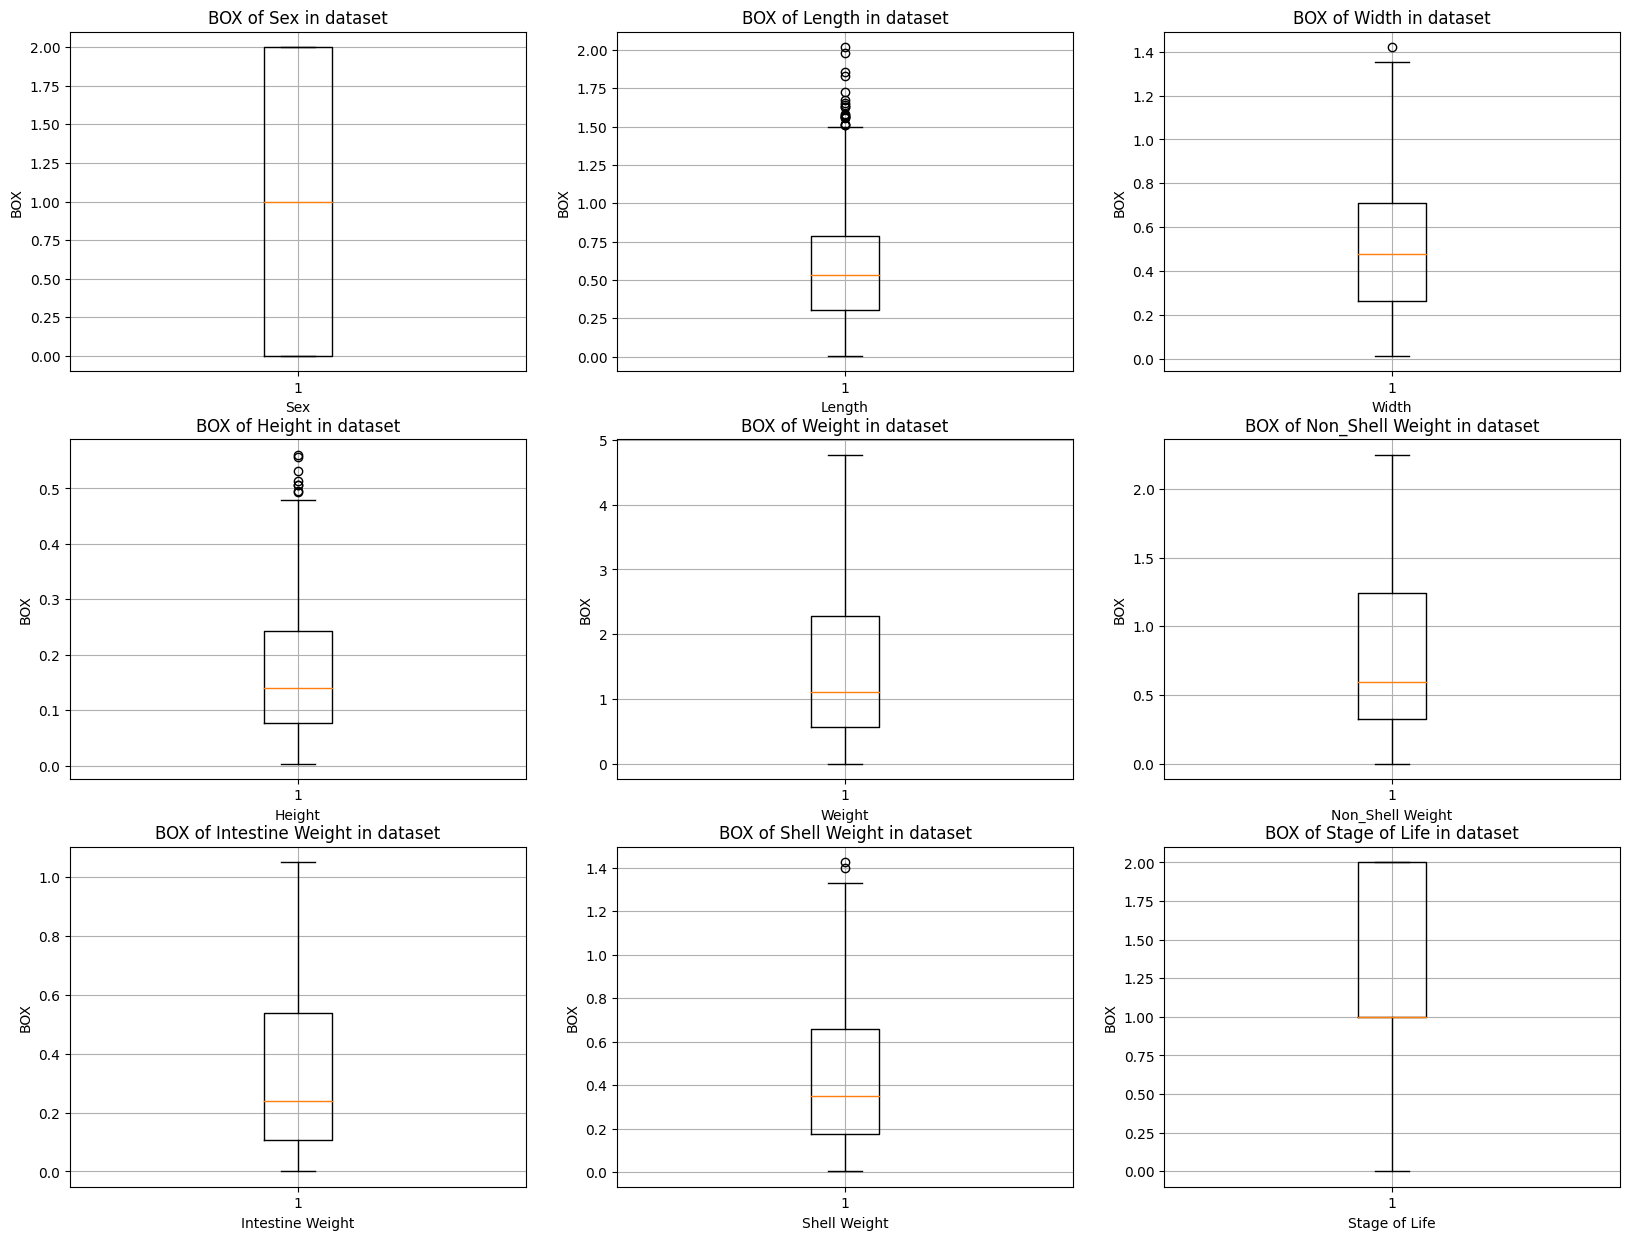

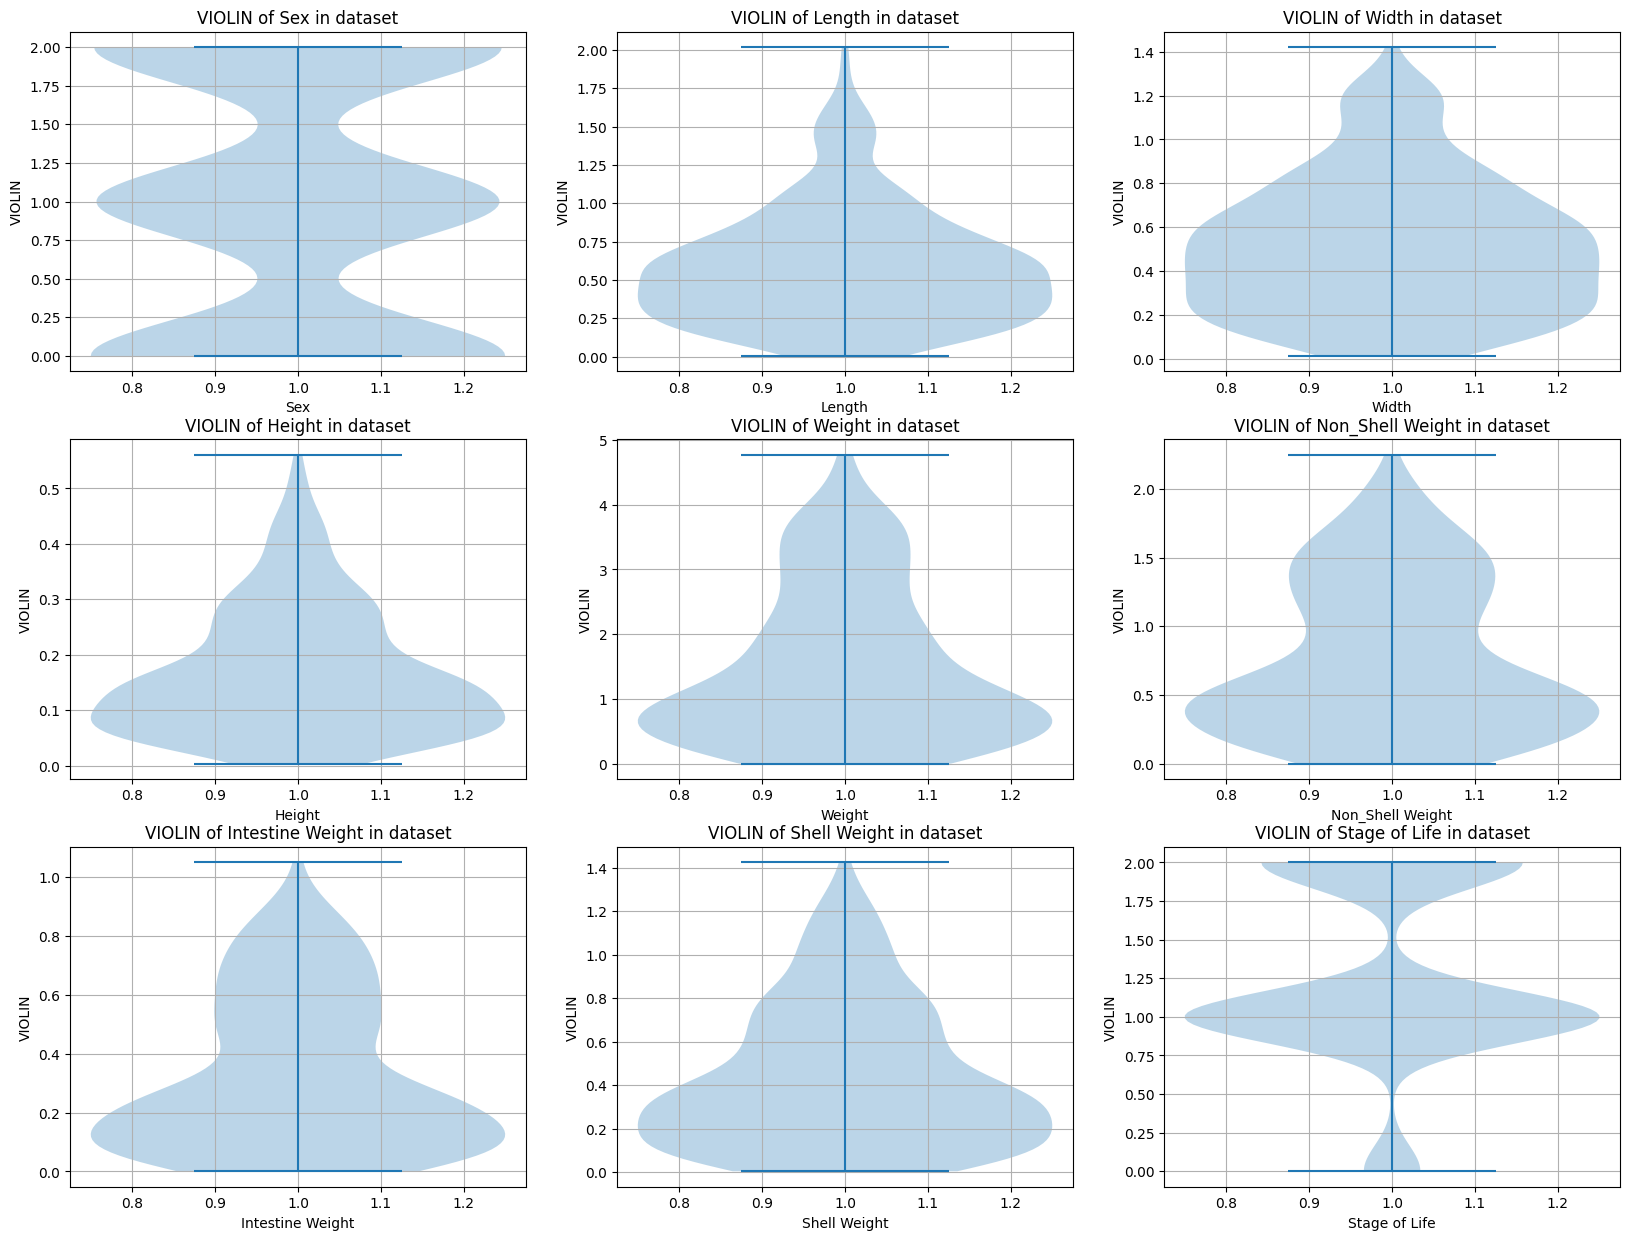

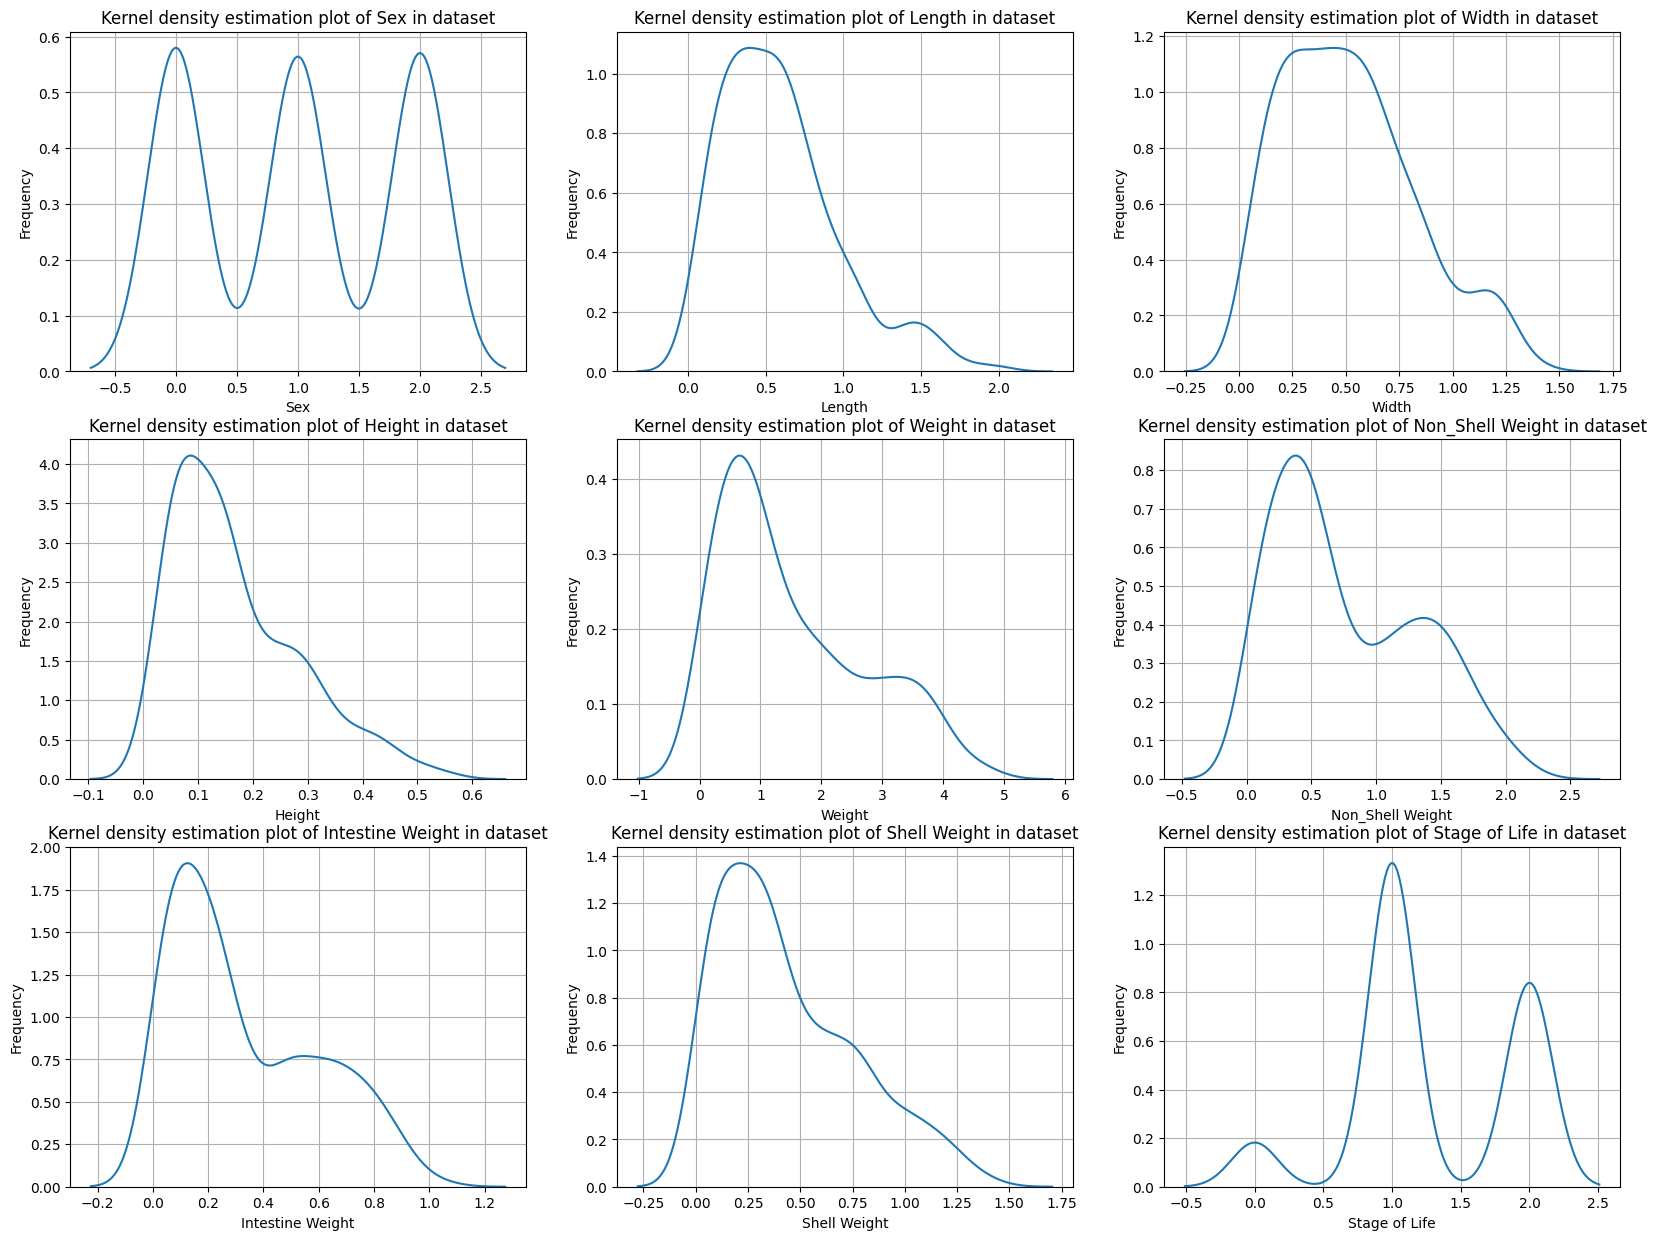

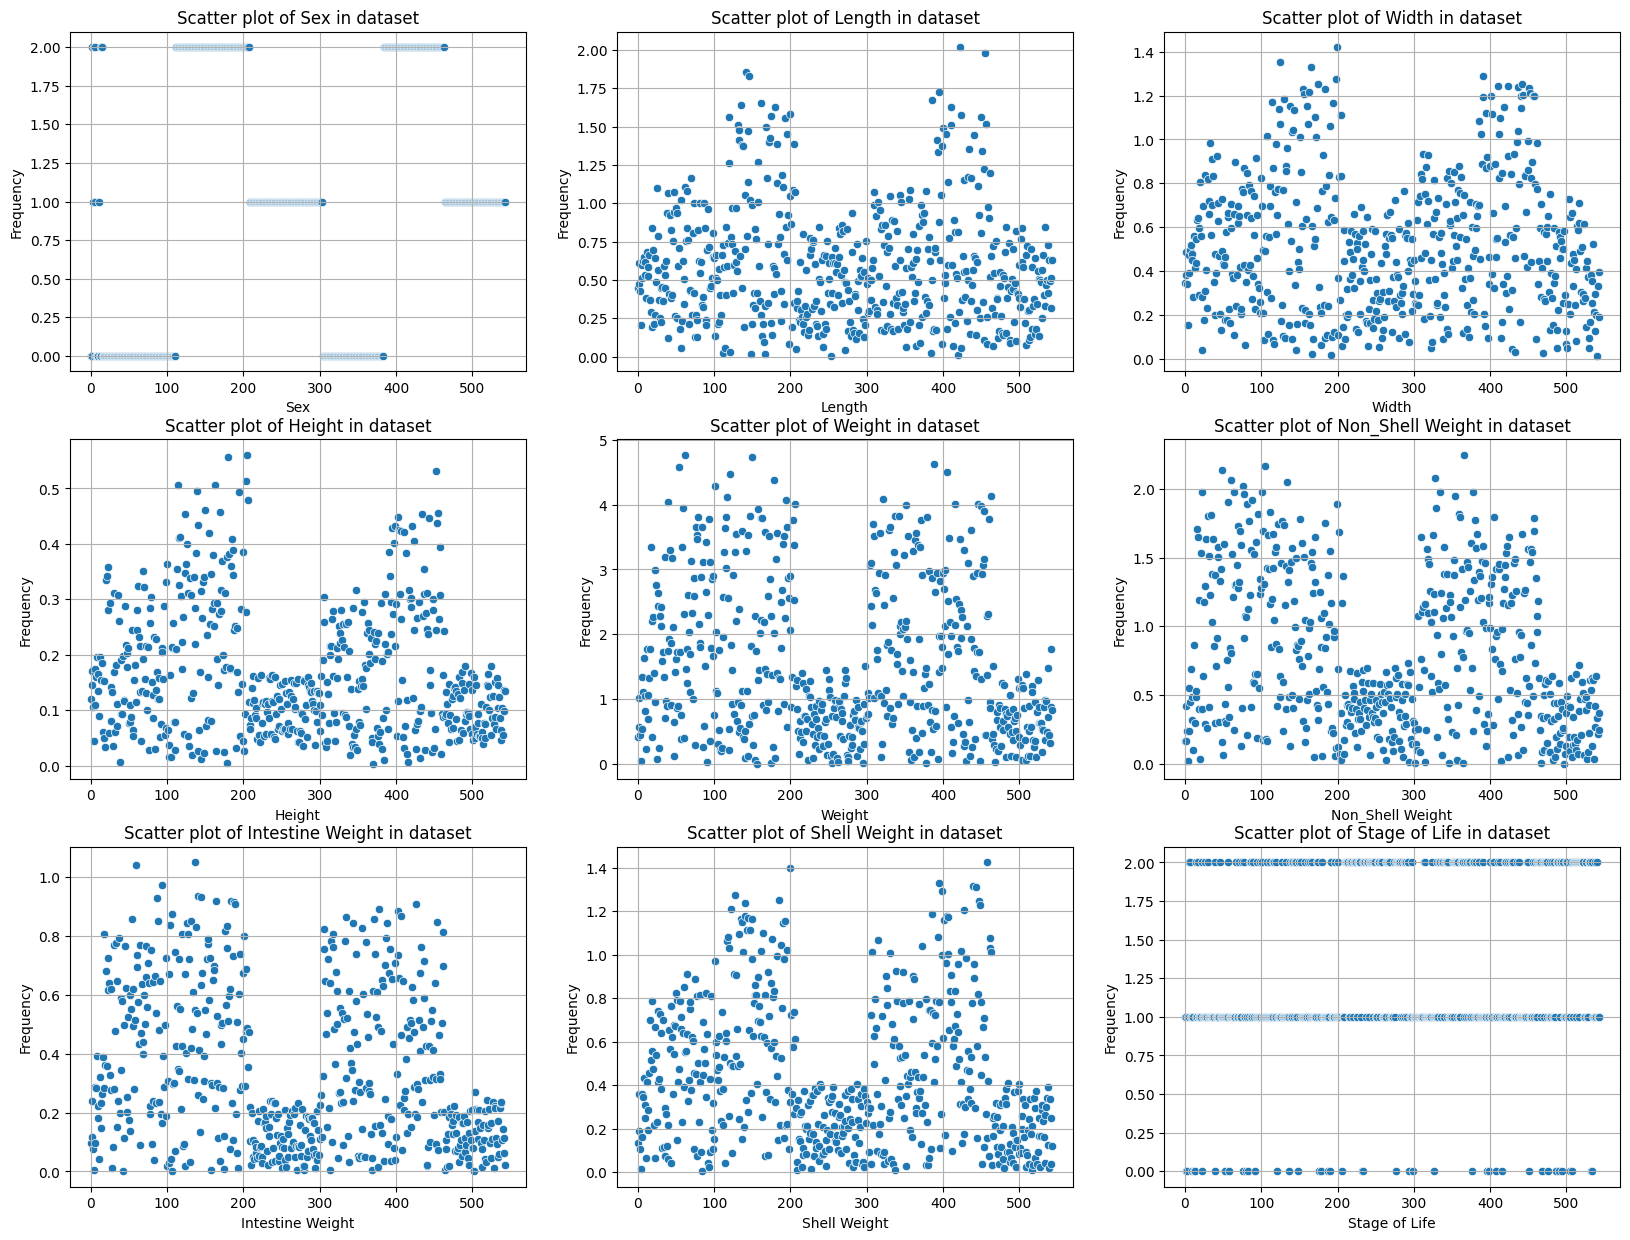

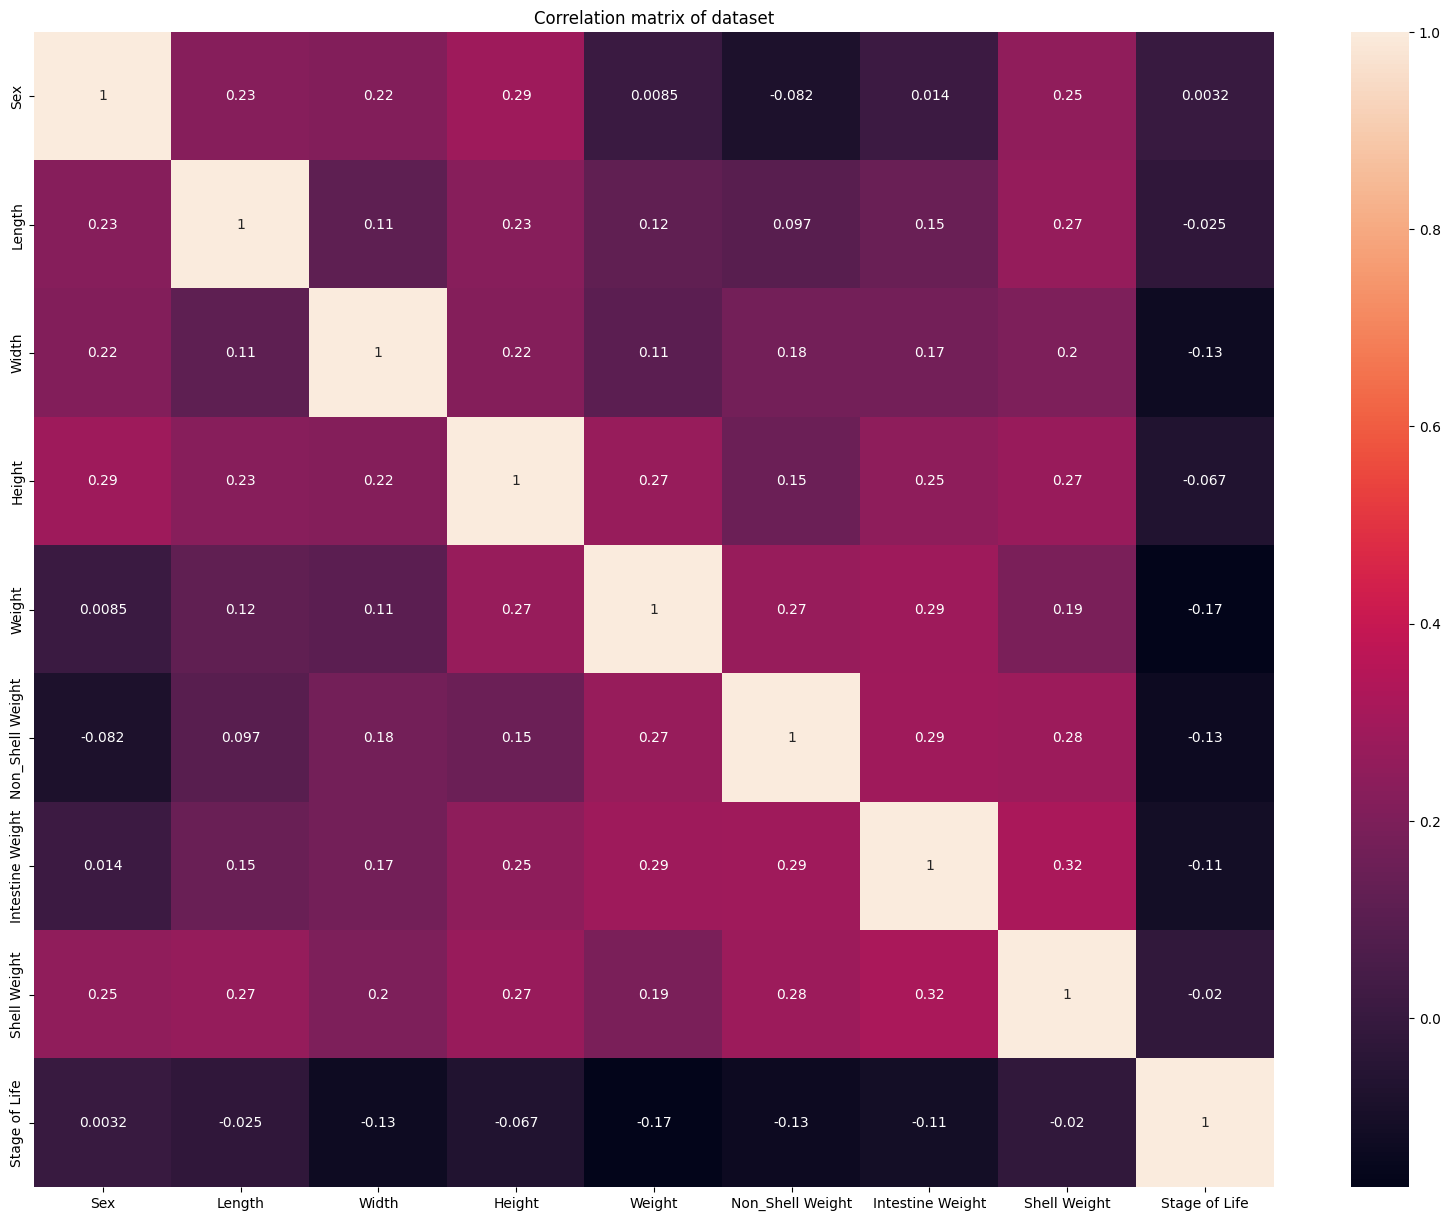

In [326]:
plot_all(molluscs_data, subplot=True)

#### Generate thrid data request

In [327]:
data_point_count_req_3 = calculate_datapoint_count(duration_days=6)
data_point_count_req_3_per_model = int((data_point_count_req_3 / 2) / 3)
data_point_count_req_3, data_point_count_req_3_per_model, data_point_count_req_3_per_model * 3 * 2

(288, 48, 288)

In [328]:
scaled_molluscs_data, scaler = scale_numeric(molluscs_data, key=["Stage of Life"])
scaled_molluscs_data.describe()

Sex      Length       Width      Height      Weight  \
count  544.000000  544.000000  544.000000  544.000000  544.000000   
mean     0.497243    0.291867    0.358650    0.295906    0.317376   
std      0.409927    0.190505    0.222578    0.209209    0.249611   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.148315    0.178032    0.132278    0.118995   
50%      0.500000    0.261322    0.329351    0.244800    0.232923   
75%      1.000000    0.387524    0.493849    0.430981    0.478532   
max      1.000000    1.000000    1.000000    1.000000    1.000000   

       Non_Shell Weight  Intestine Weight  Shell Weight  Stage of Life  
count        544.000000        544.000000    544.000000     544.000000  
mean           0.346991          0.317315      0.306576       1.279412  
std            0.249648          0.252395      0.232369       0.596999  
min            0.000000          0.000000      0.000000       0.000000  
25%            0.142950          0.102389      0.119450       1.000000  
50%            0.263521          0.226149      0.244956       1.000000  
75%            0.553662          0.513209      0.459756       2.000000  
max            1.000000          1.000000      1.000000       2.000000

In [329]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Test the models using k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

classifiers = {
    "RFC": RandomForestClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "MLP": MLPClassifier(random_state=42),
}

kf = KFold(n_splits=5, shuffle=True)
accuracy_scores = {key: [] for key in classifiers.keys()}
precision_scores = {key: [] for key in classifiers.keys()}
recall_scores = {key: [] for key in classifiers.keys()}
f1_scores = {key: [] for key in classifiers.keys()}
confusion_matrices = {key: [] for key in classifiers.keys()}

X = scaled_molluscs_data.drop(columns=["Stage of Life"])
y = scaled_molluscs_data["Stage of Life"]

for train_index, test_index in kf.split(scaled_molluscs_data):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    for model_name, model in classifiers.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_scores[model_name].append(accuracy_score(y_test, y_pred))
        precision_scores[model_name].append(precision_score(y_test, y_pred, average="weighted", zero_division=0))
        recall_scores[model_name].append(recall_score(y_test, y_pred, average="weighted", zero_division=0))
        f1_scores[model_name].append(f1_score(y_test, y_pred, average="weighted", zero_division=0))
        confusion_matrices[model_name].append(confusion_matrix(y_test, y_pred))

mean_accuracy_scores = {key: np.mean(value) for key, value in accuracy_scores.items()}
mean_precision_scores = {key: np.mean(value) for key, value in precision_scores.items()}
mean_recall_scores = {key: np.mean(value) for key, value in recall_scores.items()}
mean_f1_scores = {key: np.mean(value) for key, value in f1_scores.items()}
mean_confusion_matrices = {key: np.mean(value, axis=0) for key, value in confusion_matrices.items()}

print("\tAccuracy scores:")
print(mean_accuracy_scores)
print("\tPrecision scores:")
print(mean_precision_scores)
print("\tRecall scores:")
print(mean_recall_scores)
print("\tF1 scores:")
print(mean_f1_scores)
print("\tConfusion matrices:")
print(mean_confusion_matrices)

	Accuracy scores:
{'RFC': 0.7646788990825689, 'SVC': 0.757373428474346, 'MLP': 0.7187393815834182}
	Precision scores:
{'RFC': 0.712182506746196, 'SVC': 0.7039308083390952, 'MLP': 0.6640699398273644}
	Recall scores:
{'RFC': 0.7646788990825689, 'SVC': 0.757373428474346, 'MLP': 0.7187393815834182}
	F1 scores:
{'RFC': 0.7301043334128287, 'SVC': 0.7216522007210927, 'MLP': 0.6883594450723892}
	Confusion matrices:
{'RFC': array([[ 0. ,  5. ,  3.4],
       [ 0.2, 57.6,  3.8],
       [ 0. , 13.2, 25.6]]), 'SVC': array([[ 0. ,  5.6,  2.8],
       [ 0. , 56.8,  4.8],
       [ 0. , 13.2, 25.6]]), 'MLP': array([[ 0. ,  5.2,  3.2],
       [ 0. , 52.2,  9.4],
       [ 0. , 12.8, 26. ]])}


In [330]:
# Test the models on latin hypercube of data to find worst values save only the probabilities
bounds = [(0, 1)] * (scaled_molluscs_data.shape[1] - 1)
test_data = lat_hyp_cube(100000, scaled_molluscs_data.drop(columns=["Stage of Life"]).shape[1], bounds)
test_data_df = pd.DataFrame(test_data, columns=scaled_molluscs_data.drop(columns=["Stage of Life"]).columns)
test_data_df = unscale_numeric(test_data_df, scaler, key=test_data_df.drop(columns=["Sex"]).columns)
test_data_df["Sex"] = test_data_df["Sex"].round().astype(int)

mlp_probs = classifiers["MLP"].predict_proba(test_data_df)
rfc_probs = classifiers["RFC"].predict_proba(test_data_df)
svc_probs = classifiers["SVC"].predict_proba(test_data_df)

mlp_probs_df = pd.DataFrame(mlp_probs, columns=classifiers["MLP"].classes_)
rfc_probs_df = pd.DataFrame(rfc_probs, columns=classifiers["RFC"].classes_)
svc_probs_df = pd.DataFrame(svc_probs, columns=classifiers["SVC"].classes_)

probs_df_dict = {
    "MLP": mlp_probs_df,
    "RFC": rfc_probs_df,
    "SVC": svc_probs_df,
}

display(mlp_probs_df)
display(rfc_probs_df)
display(svc_probs_df)

0         1         2
0      0.059371  0.326830  0.613799
1      0.027845  0.819565  0.152589
2      0.065969  0.412031  0.522000
3      0.050199  0.635460  0.314340
4      0.055954  0.841747  0.102299
...         ...       ...       ...
99995  0.037816  0.638345  0.323839
99996  0.020574  0.926007  0.053419
99997  0.018569  0.896642  0.084789
99998  0.040825  0.901282  0.057893
99999  0.022346  0.887460  0.090194

[100000 rows x 3 columns]

0     1     2
0      0.04  0.49  0.47
1      0.11  0.57  0.32
2      0.26  0.50  0.24
3      0.13  0.67  0.20
4      0.10  0.57  0.33
...     ...   ...   ...
99995  0.07  0.74  0.19
99996  0.12  0.81  0.07
99997  0.11  0.79  0.10
99998  0.06  0.72  0.22
99999  0.03  0.92  0.05

[100000 rows x 3 columns]

0         1         2
0      0.071024  0.655036  0.273941
1      0.074968  0.781133  0.143899
2      0.077479  0.722156  0.200365
3      0.081619  0.620420  0.297961
4      0.073367  0.703957  0.222676
...         ...       ...       ...
99995  0.077223  0.671394  0.251383
99996  0.077686  0.865316  0.056998
99997  0.082801  0.859585  0.057614
99998  0.071335  0.880080  0.048585
99999  0.074454  0.848182  0.077364

[100000 rows x 3 columns]

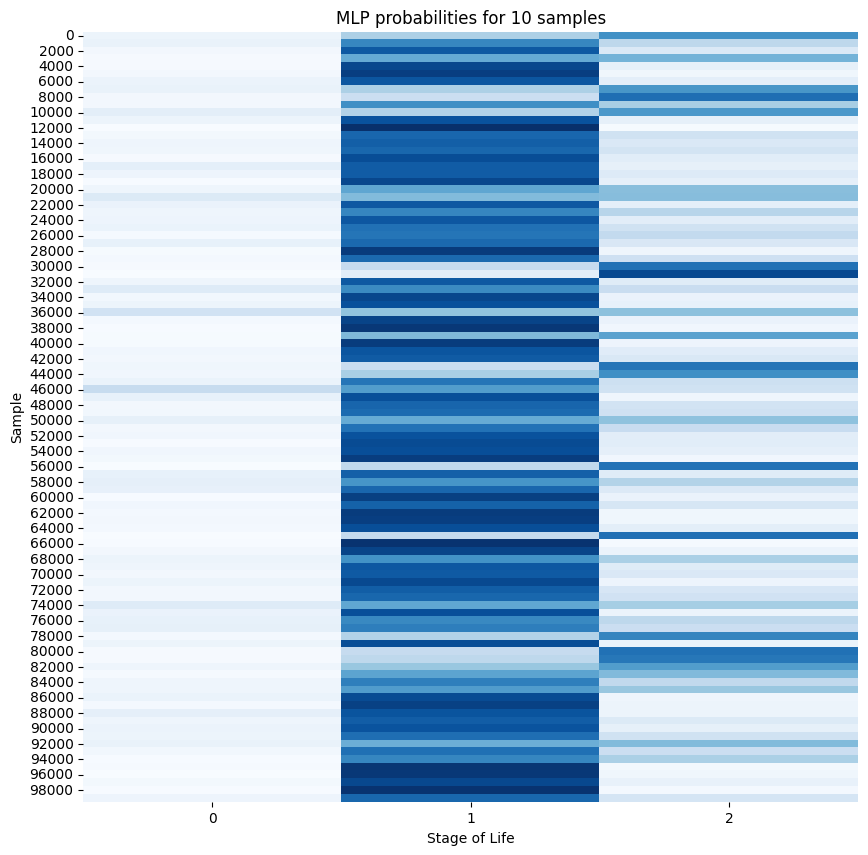

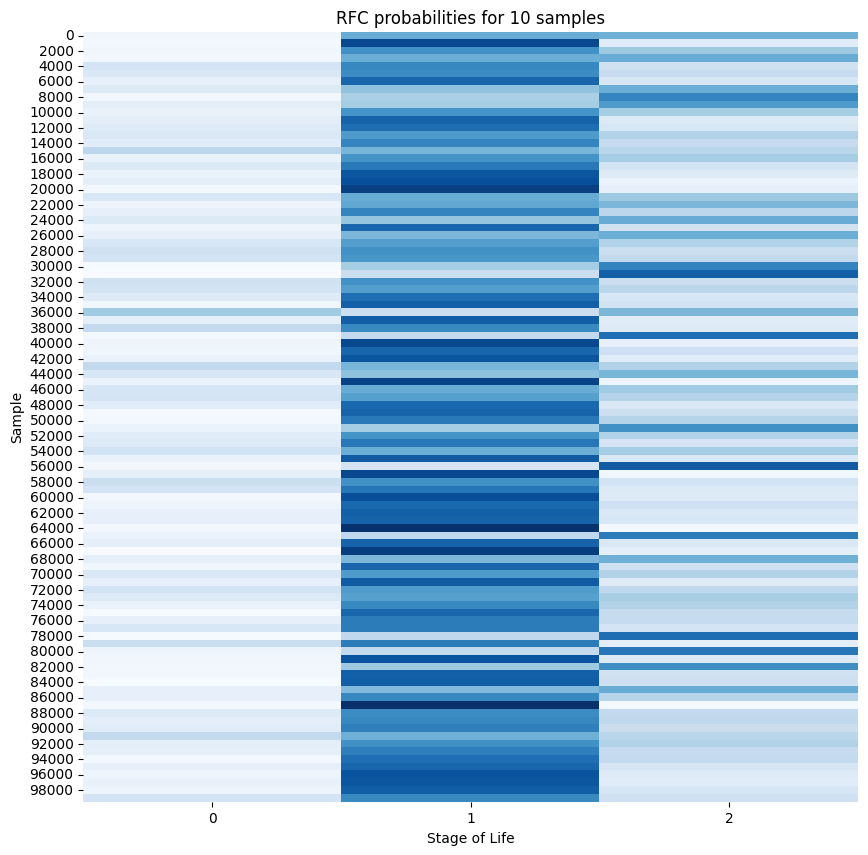

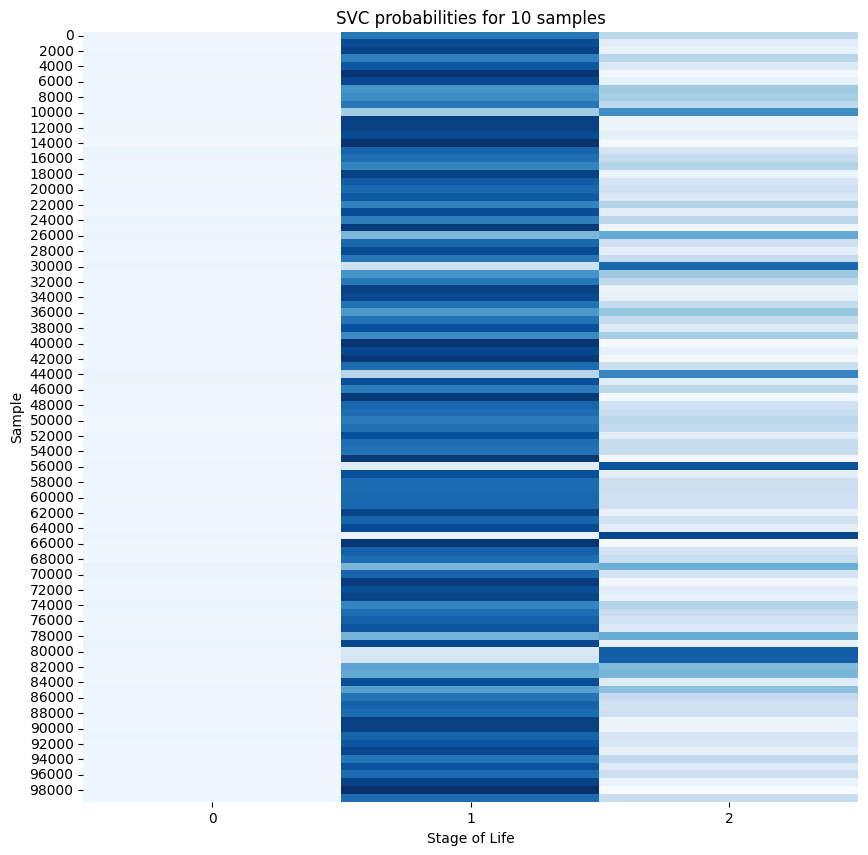

In [331]:
# plot the probabilities as a heatmap for 10 evenly spaced samples
for model_name, probs_df in probs_df_dict.items():
    sample = test_data_df.iloc[::test_data_df.shape[0] // 100]
    plt.figure(figsize=(10, 10))
    sns.heatmap(probs_df.loc[sample.index], cmap="Blues", cbar=False)
    plt.title(f"{model_name} probabilities for 10 samples")
    plt.xlabel("Stage of Life")
    plt.ylabel("Sample")
    plt.show()

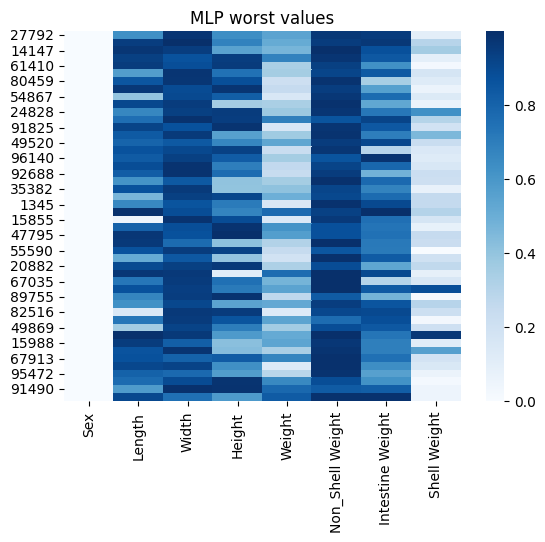

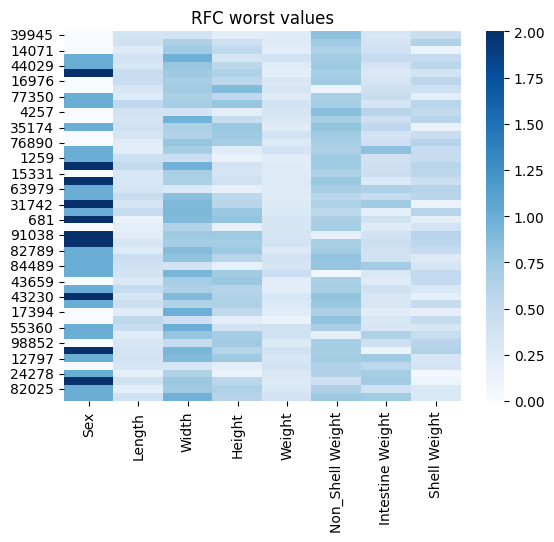

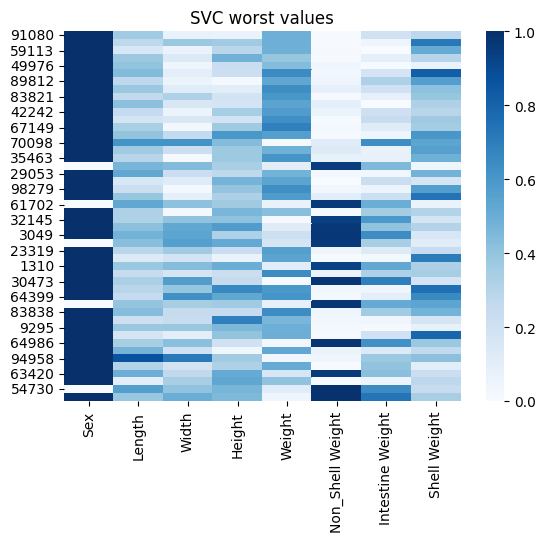

In [332]:
# Find the worst values for each model
worst_mlp = mlp_probs_df.max(axis=1).sort_values(ascending=False).head(data_point_count_req_3_per_model)
worst_rfc = rfc_probs_df.max(axis=1).sort_values(ascending=False).head(data_point_count_req_3_per_model)
worst_svc = svc_probs_df.max(axis=1).sort_values(ascending=False).head(data_point_count_req_3_per_model)

worst_mlp_df = test_data_df.iloc[worst_mlp.index]
worst_rfc_df = test_data_df.iloc[worst_rfc.index]
worst_svc_df = test_data_df.iloc[worst_svc.index]

worst_df_dict = {
    "MLP": worst_mlp_df,
    "RFC": worst_rfc_df,
    "SVC": worst_svc_df,
}

# Plot the worst values
for model_name, worst_df in worst_df_dict.items():
    plt.figure()
    sns.heatmap(worst_df, cmap="Blues", fmt=".2f")
    plt.title(f"{model_name} worst values")
    plt.show()

In [333]:
# Get the worst values for each model based the on accuracy on mollusc_data using k-fold cross validation
from sklearn.metrics import accuracy_score

worst_data_mlp = pd.DataFrame()
worst_data_rfc = pd.DataFrame()
worst_data_svc = pd.DataFrame()

i = 0

while len(pd.concat([worst_data_mlp, worst_data_rfc, worst_data_svc]).drop_duplicates()) < data_point_count_req_3_per_model * 3 and i < MAX_ITER:
    print(f"Iteration {i}, current data point count: {len(pd.concat([worst_data_mlp, worst_data_rfc, worst_data_svc]).drop_duplicates())}")

    mlp_accuracy = []
    rfc_accuracy = []
    svc_accuracy = []

    kf = KFold(n_splits=10, shuffle=False)

    for train_index, test_index in kf.split(scaled_molluscs_data):
        classifiers_ = {
            "MLP": MLPClassifier(random_state=42),
            "RFC": RandomForestClassifier(random_state=42),
            "SVC": SVC(random_state=42),
        }

        X_train, X_test = scaled_molluscs_data.iloc[train_index].drop("Stage of Life", axis=1), scaled_molluscs_data.iloc[test_index].drop("Stage of Life", axis=1)
        y_train, y_test = scaled_molluscs_data.iloc[train_index]["Stage of Life"], scaled_molluscs_data.iloc[test_index]["Stage of Life"]

        classifiers_["MLP"].fit(X_train, y_train)
        classifiers_["RFC"].fit(X_train, y_train)
        classifiers_["SVC"].fit(X_train, y_train)

        mlp_accuracy += [accuracy_score([y_], classifiers_["MLP"].predict(x_.reshape(1, -1))) for x_, y_ in zip(X_test.values, y_test.values)]
        rfc_accuracy += [accuracy_score([y_], classifiers_["RFC"].predict(x_.reshape(1, -1))) for x_, y_ in zip(X_test.values, y_test.values)]
        svc_accuracy += [accuracy_score([y_], classifiers_["SVC"].predict(x_.reshape(1, -1))) for x_, y_ in zip(X_test.values, y_test.values)]

    mlp_accuracy = np.array(mlp_accuracy)
    rfc_accuracy = np.array(rfc_accuracy)
    svc_accuracy = np.array(svc_accuracy)

    worst_data_mlp = scaled_molluscs_data.iloc[mlp_accuracy <= 0].sample(data_point_count_req_3_per_model, random_state=42)
    worst_data_rfc = scaled_molluscs_data.iloc[rfc_accuracy <= 0].sample(data_point_count_req_3_per_model, random_state=42)
    worst_data_svc = scaled_molluscs_data.iloc[svc_accuracy <= 0].sample(data_point_count_req_3_per_model, random_state=42)

    worst_data_mlp = worst_data_mlp.apply(lambda x: abs(x + np.random.normal(0, 0.01, x.shape[0])) if x.name not in ["Stage of Life", "Sex"] else x)
    worst_data_rfc = worst_data_rfc.apply(lambda x: abs(x + np.random.normal(0, 0.01, x.shape[0])) if x.name not in ["Stage of Life", "Sex"] else x)
    worst_data_svc = worst_data_svc.apply(lambda x: abs(x + np.random.normal(0, 0.01, x.shape[0])) if x.name not in ["Stage of Life", "Sex"] else x)

    worst_data_mlp = unscale_numeric(worst_data_mlp, scaler, worst_data_mlp.drop(columns=["Sex"]).columns).astype({"Sex":"int"})
    worst_data_rfc = unscale_numeric(worst_data_rfc, scaler, worst_data_rfc.drop(columns=["Sex"]).columns).astype({"Sex":"int"})
    worst_data_svc = unscale_numeric(worst_data_svc, scaler, worst_data_svc.drop(columns=["Sex"]).columns).astype({"Sex":"int"})

worst_data_mlp, worst_data_rfc, worst_data_svc

Iteration 0, current data point count: 0


(     Sex    Length     Width    Height    Weight  Non_Shell Weight  \
 344    0  0.544511  0.099315  0.514874  0.386176          0.593467   
 407    2  0.569028  0.330554  0.459979  0.528719          0.629848   
 19     0  0.088007  0.201792  0.041036  0.085349          0.530749   
 71     0  0.138590  0.457891  0.292630  0.488194          0.575844   
 256    1  0.297055  0.190178  0.237612  0.034283          0.266253   
 262    1  0.216456  0.349916  0.211231  0.019339          0.201049   
 260    1  0.279091  0.078453  0.234689  0.147698          0.057807   
 468    1  0.128710  0.288856  0.153622  0.015759          0.033275   
 415    2  0.118263  0.127249  0.215994  0.456416          0.302456   
 286    1  0.065233  0.220897  0.242396  0.202837          0.030939   
 333    0  0.448223  0.373095  0.148225  0.123371          0.245774   
 148    2  0.009277  0.308894  0.020673  0.371920          0.374682   
 295    1  0.138896  0.310489  0.167683  0.027438          0.280512   
 264  

In [334]:
# Combine the different worst data points into one dataframe
worst_data_sets = [worst_data_mlp, worst_data_rfc, worst_data_svc, worst_mlp_df, worst_rfc_df, worst_svc_df]

#data_req_period_3 = pd.concat(worst_data_sets, axis=0).drop(columns=["Stage of Life"])
#display(data_req_period_3["Sex"].unique())
#data_req_period_3 = unscale_numeric(data_req_period_3, scaler, ["Sex"])
#data_req_period_3.drop_duplicates()

data_req_period_3 = pd.read_csv("../results/data_requests/data_req_period_3.csv")

array([0, 2, 1])

Sex    Length     Width    Height    Weight  Non_Shell Weight  \
344      0  1.101008  0.152778  0.290369  1.843334          1.333894   
407      2  1.150407  0.478207  0.259784  2.523132          1.415587   
19       0  0.181207  0.296998  0.026365  0.408664          1.193062   
71       0  0.283127  0.657412  0.166543  2.329868          1.294321   
256      1  0.602413  0.280652  0.135889  0.165122          0.599146   
...    ...       ...       ...       ...       ...               ...   
46241    1  0.627791  0.272809  0.184869  2.450260          0.012197   
63420    1  1.004768  0.389095  0.290952  0.771282          2.154616   
46239    1  0.201681  0.497823  0.303642  1.945549          0.025074   
54730    0  1.152646  0.588822  0.265295  0.558805          2.228924   
72732    1  0.785959  0.718008  0.255605  0.234866          2.226294   

       Intestine Weight  Shell Weight  
344            0.228798      0.521266  
407            0.453122      0.989598  
19             0.349761      0.804025  
71             0.500204      0.637180  
256            0.009740      0.365983  
...                 ...           ...  
46241          0.429251      0.160549  
63420          0.445063      0.323823  
46239          0.061514      0.400520  
54730          0.679621      0.344417  
72732          0.774239      0.496818  

[288 rows x 8 columns]

{0:        Sex    Length     Width    Height    Weight  Non_Shell Weight  \
 344      0  1.101008  0.152778  0.290369  1.843334          1.333894   
 19       0  0.181207  0.296998  0.026365  0.408664          1.193062   
 71       0  0.283127  0.657412  0.166543  2.329868          1.294321   
 333      0  0.907000  0.538077  0.086087  0.589992          0.553162   
 87       0  1.012759  0.642716  0.164232  0.517857          0.432048   
 ...    ...       ...       ...       ...       ...               ...   
 57669    0  0.941522  0.638144  0.194802  0.511640          2.137071   
 61702    0  1.074328  0.596672  0.210411  0.338426          2.152722   
 41844    0  0.866438  0.811017  0.293730  0.837062          2.153654   
 4985     0  0.811599  0.499478  0.209791  0.396457          2.187959   
 54730    0  1.152646  0.588822  0.265295  0.558805          2.228924   
 
        Intestine Weight  Shell Weight  
 344            0.228798      0.521266  
 19             0.349761      0.80402

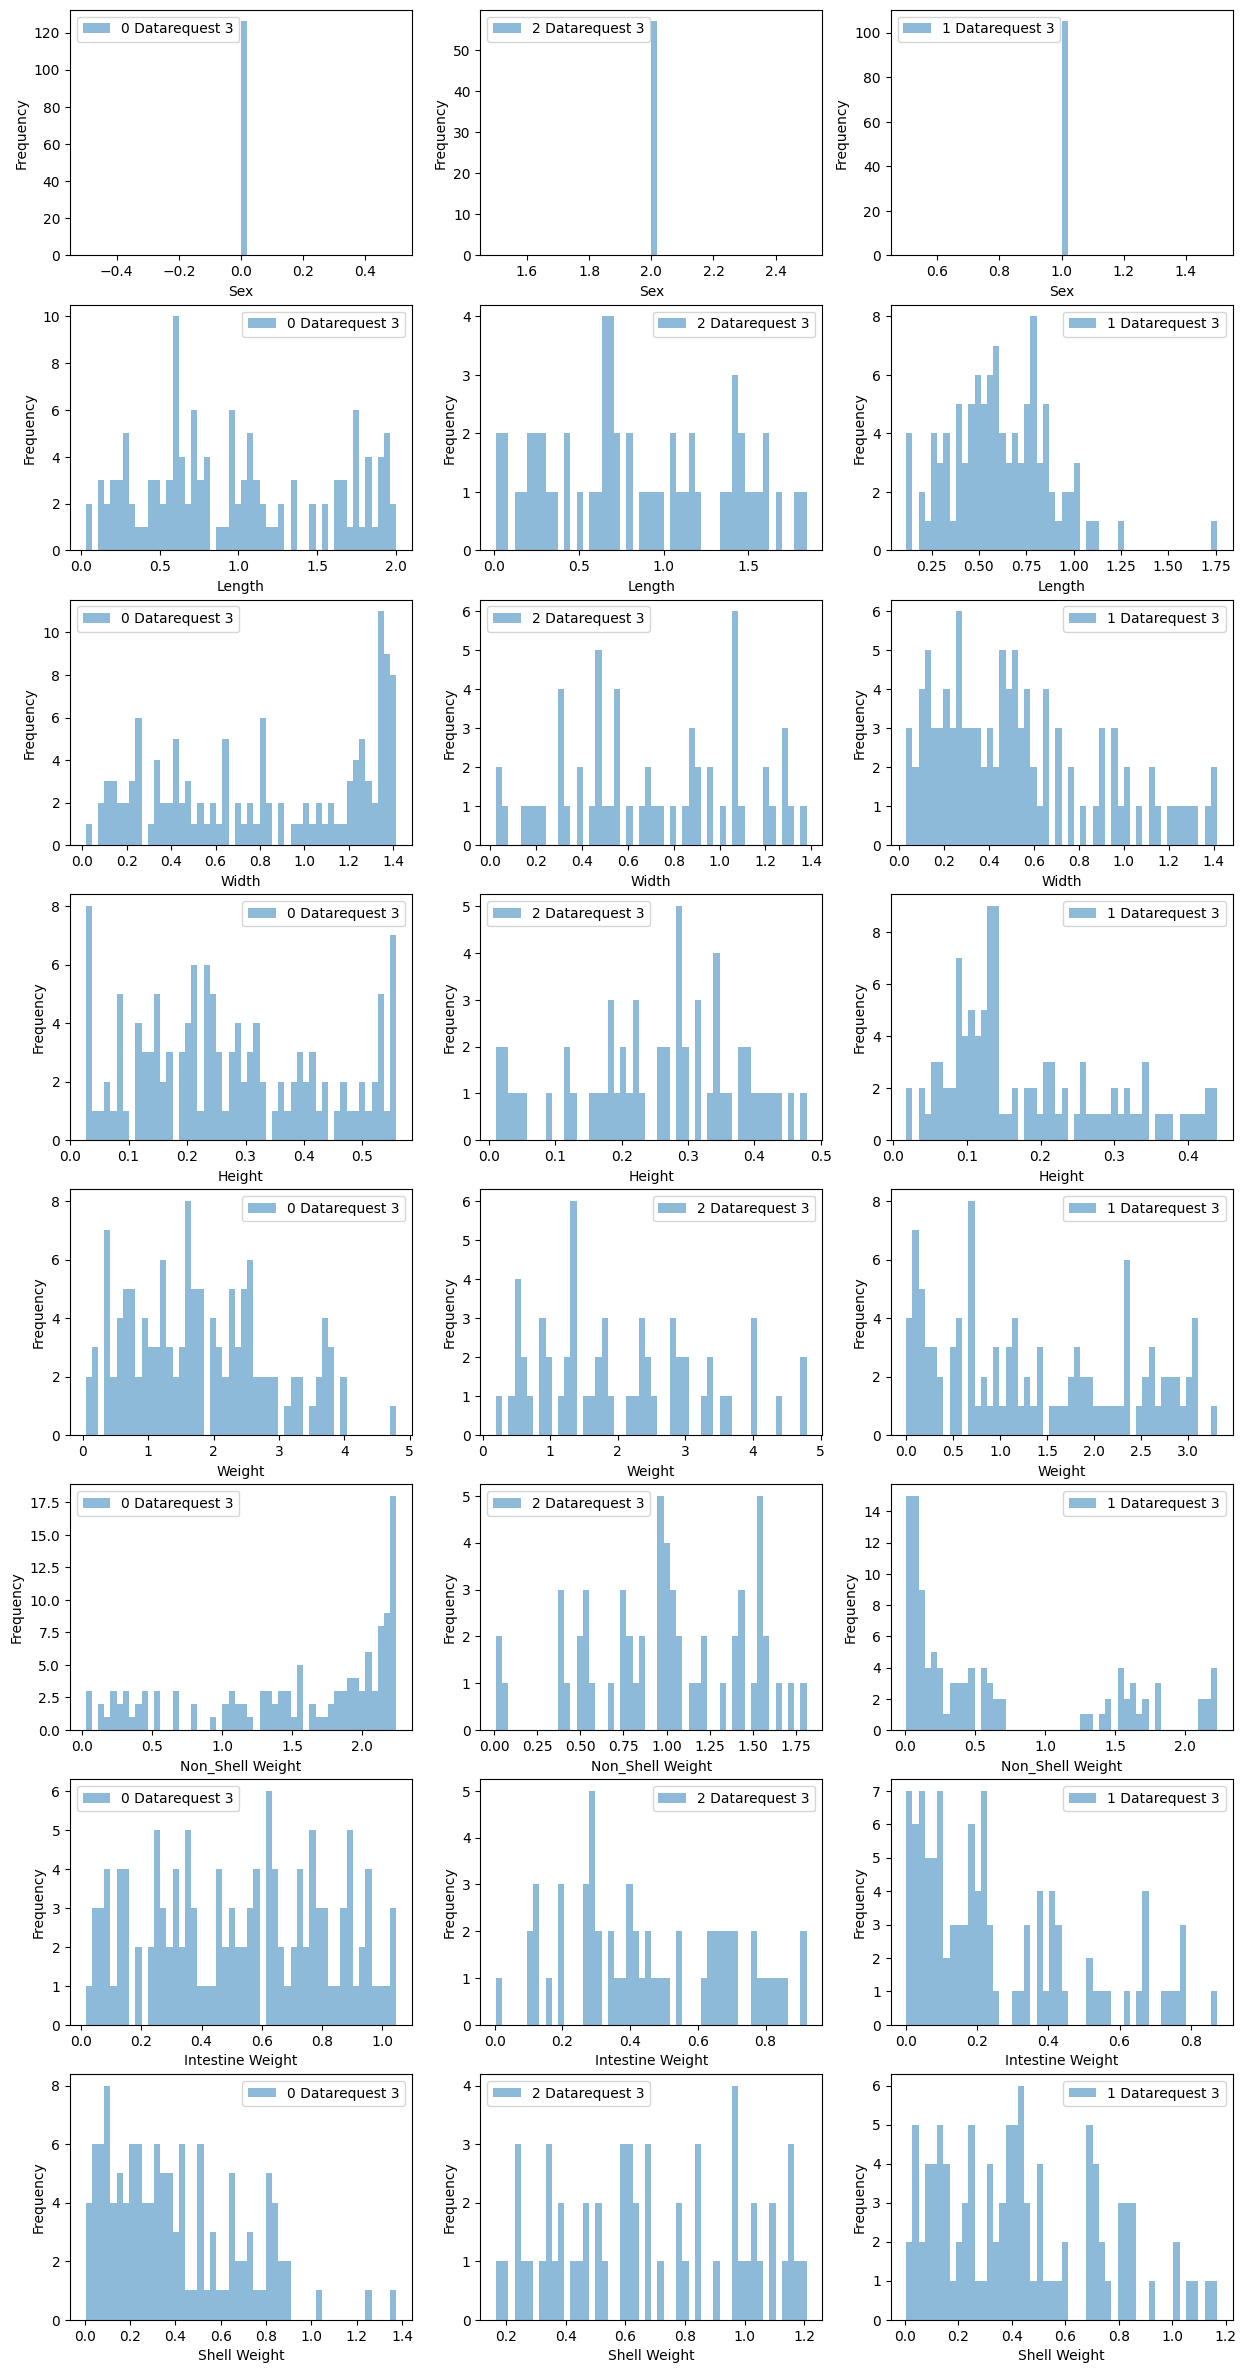

In [335]:
# Plot the data required for period 3
data_req_period_3_split = split_dataset(data_req_period_3, "Sex")
display(data_req_period_3_split)
plot_samples(data_req_period_3_split, titles=["Datarequest 3"])

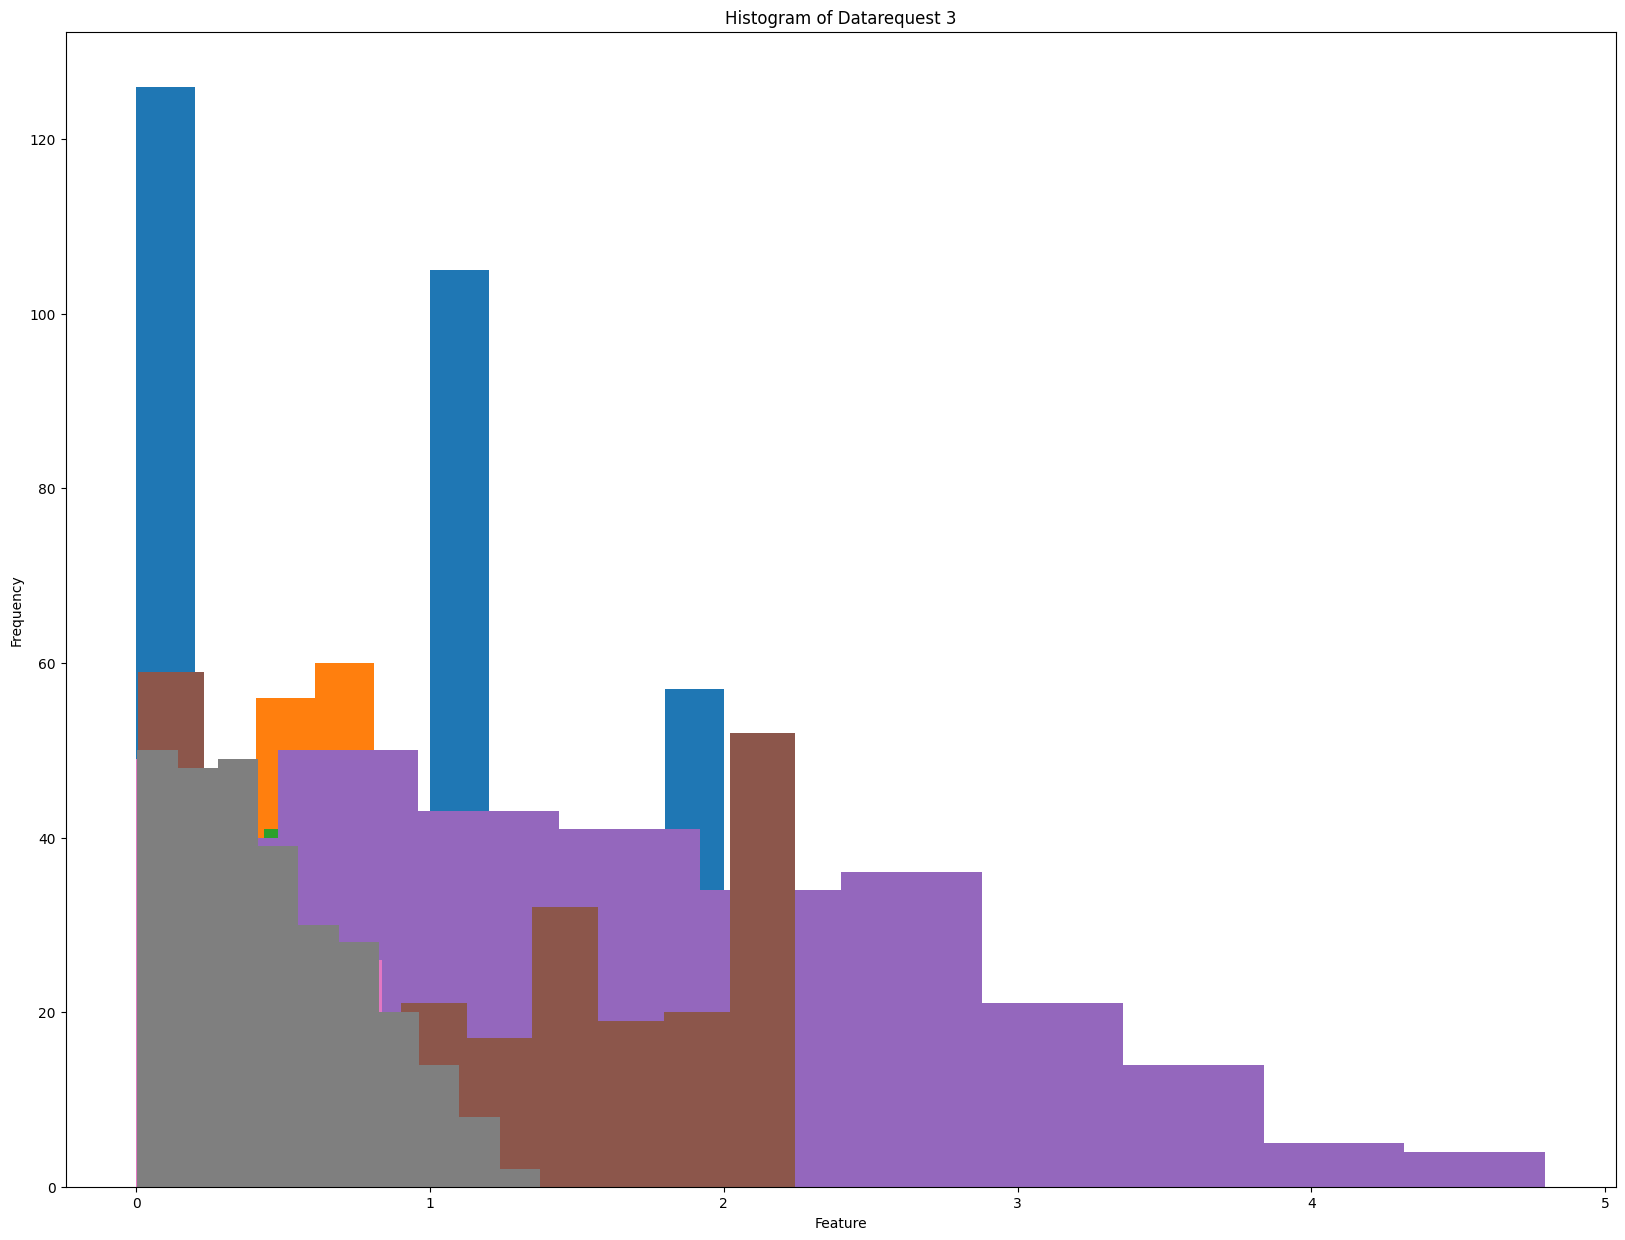

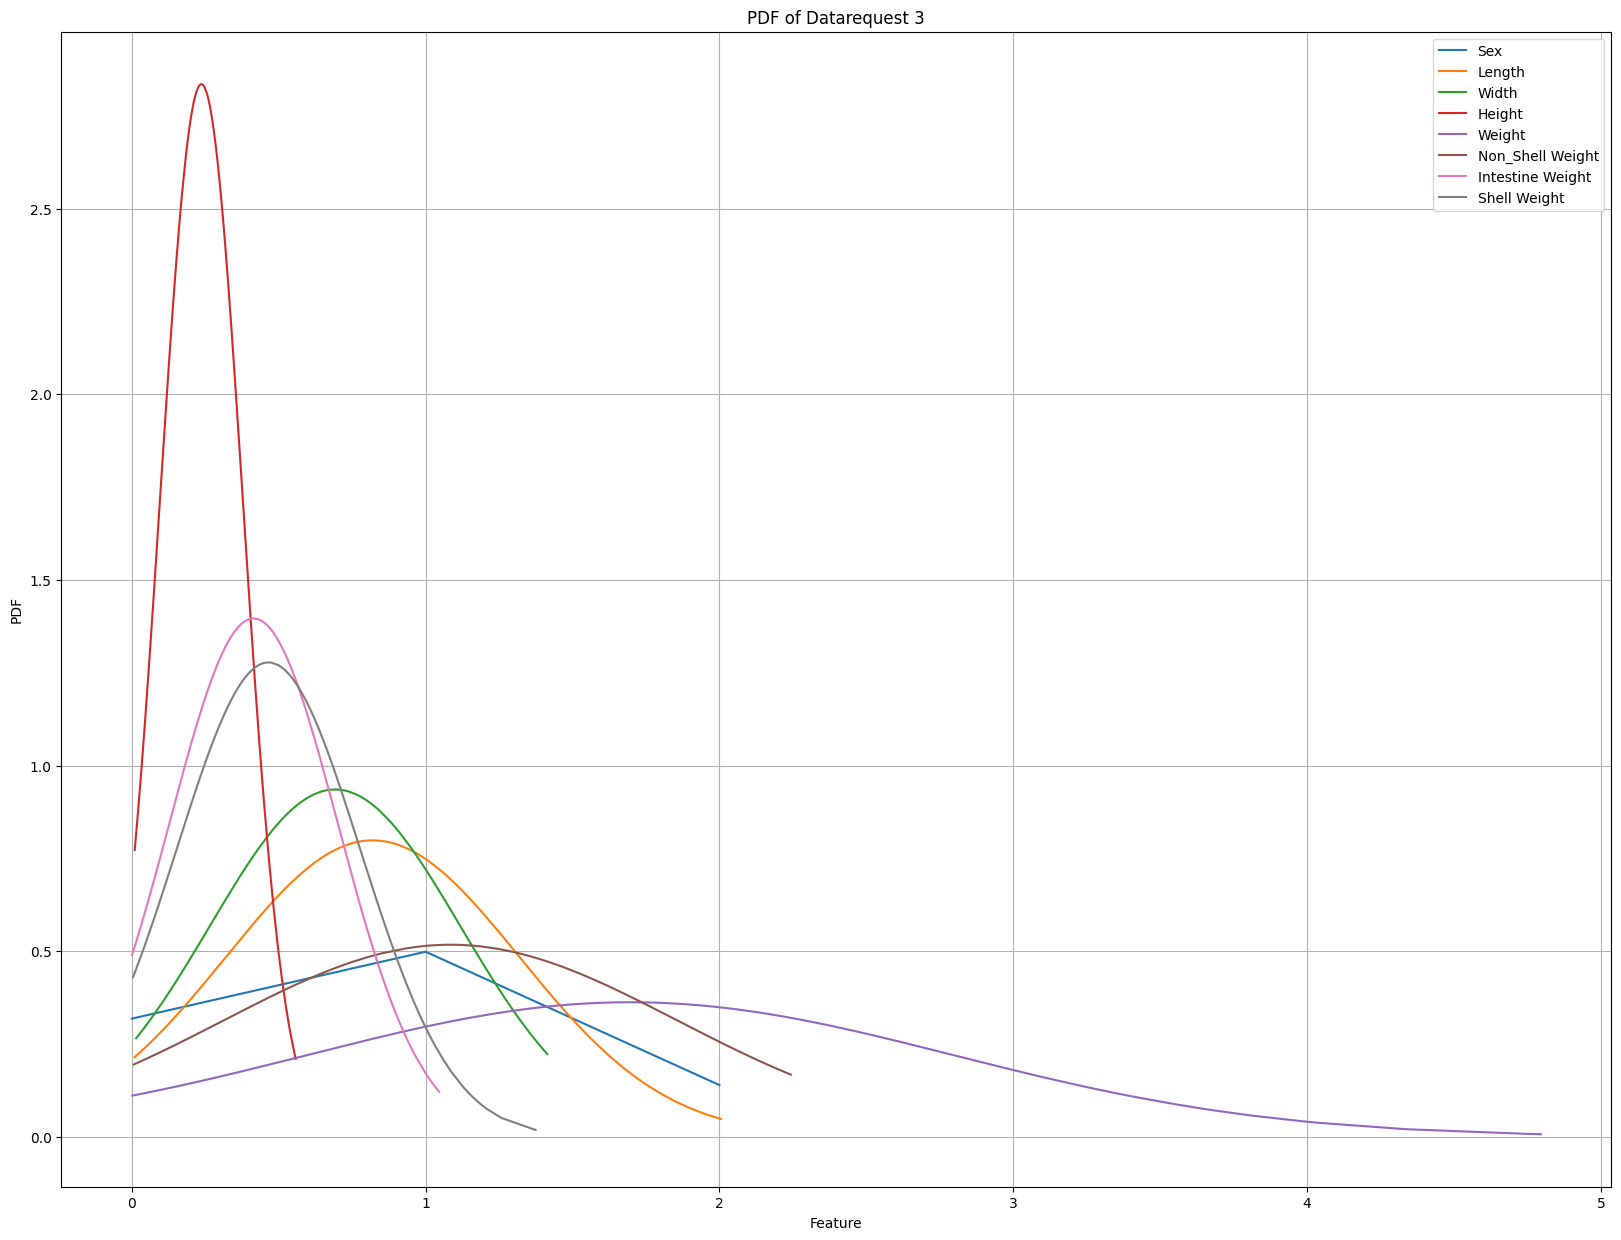

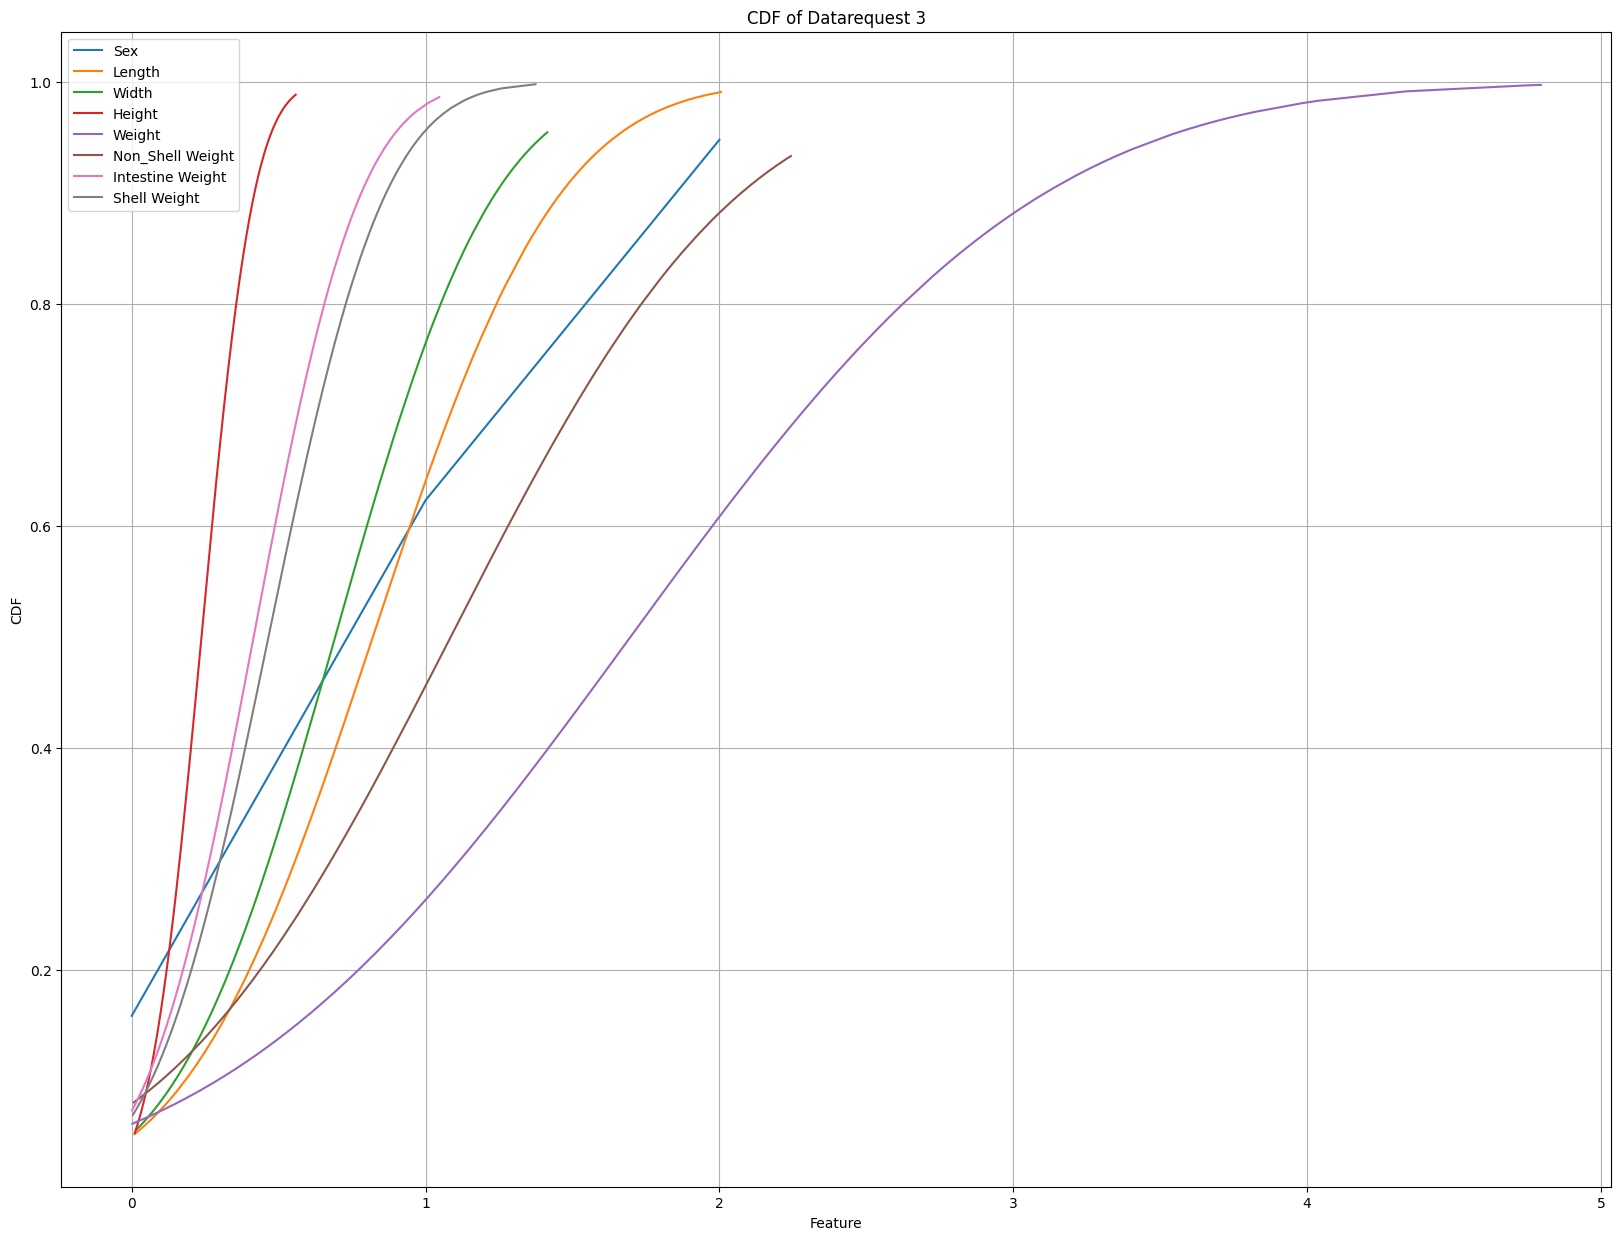

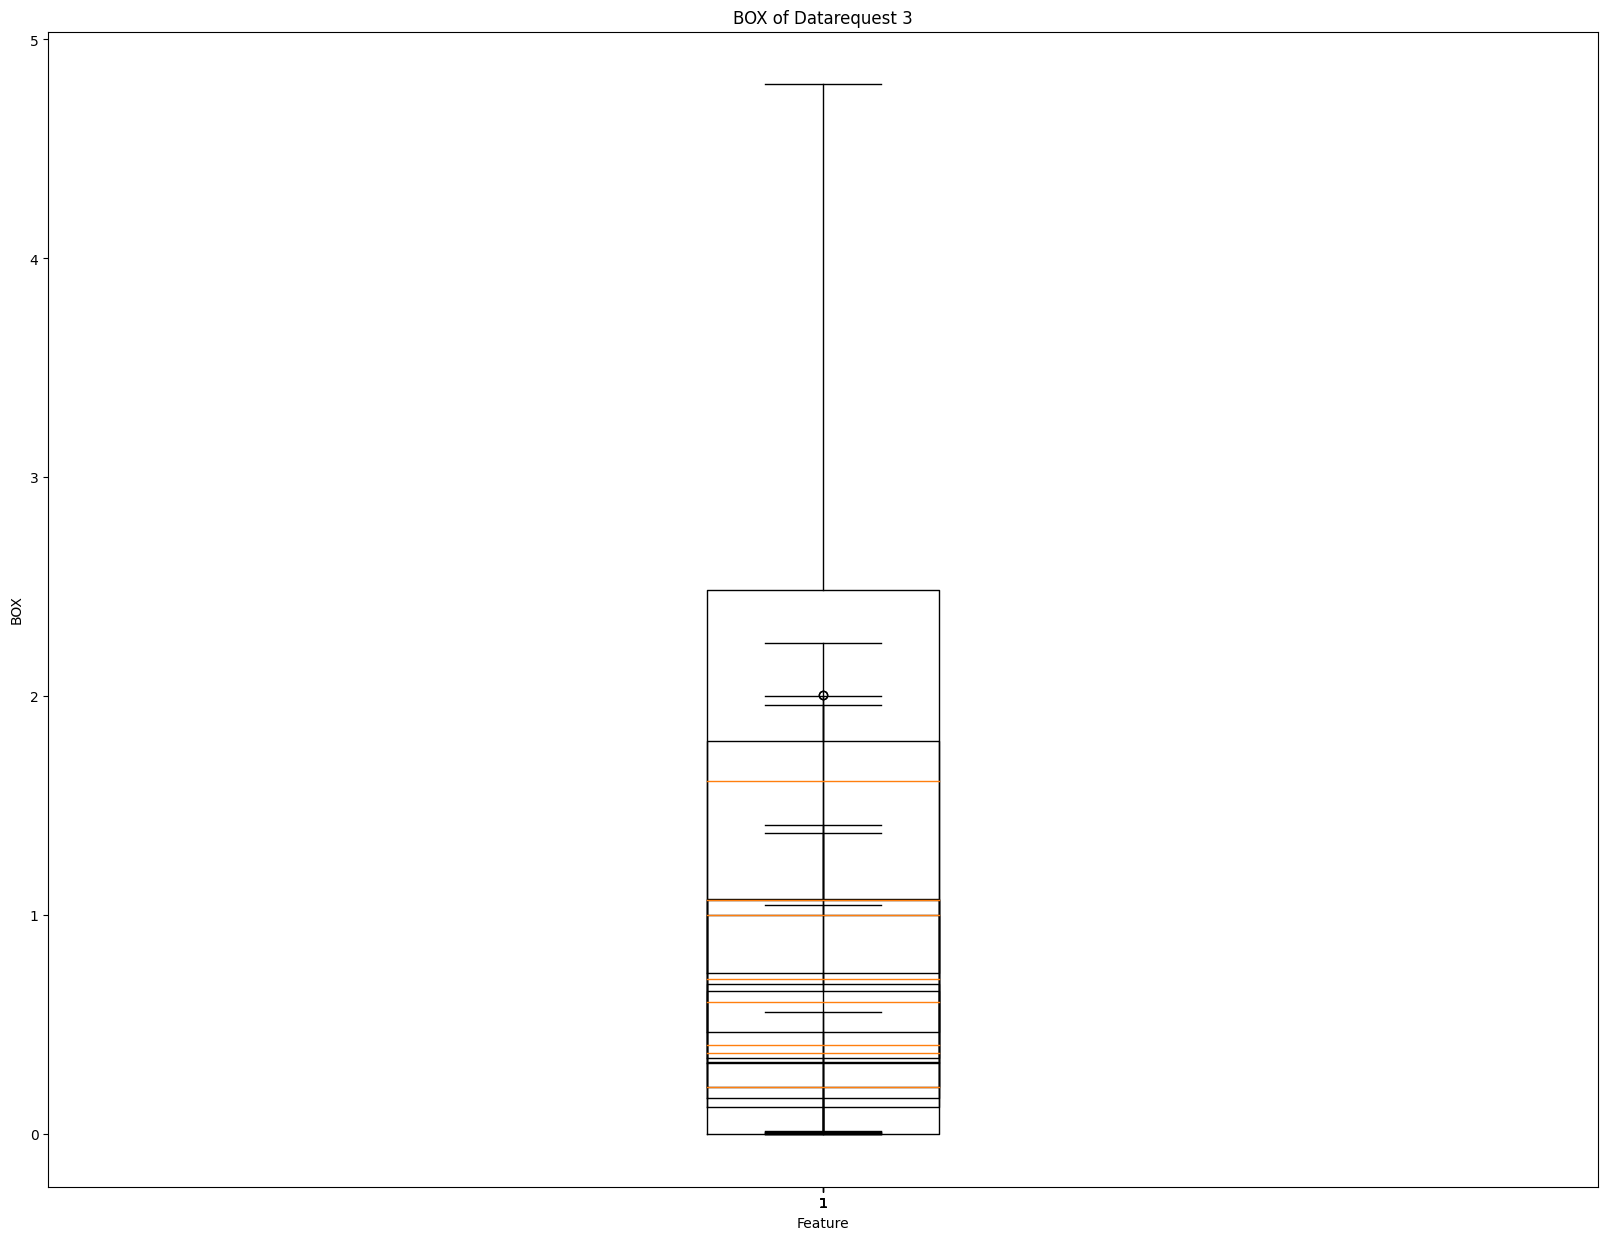

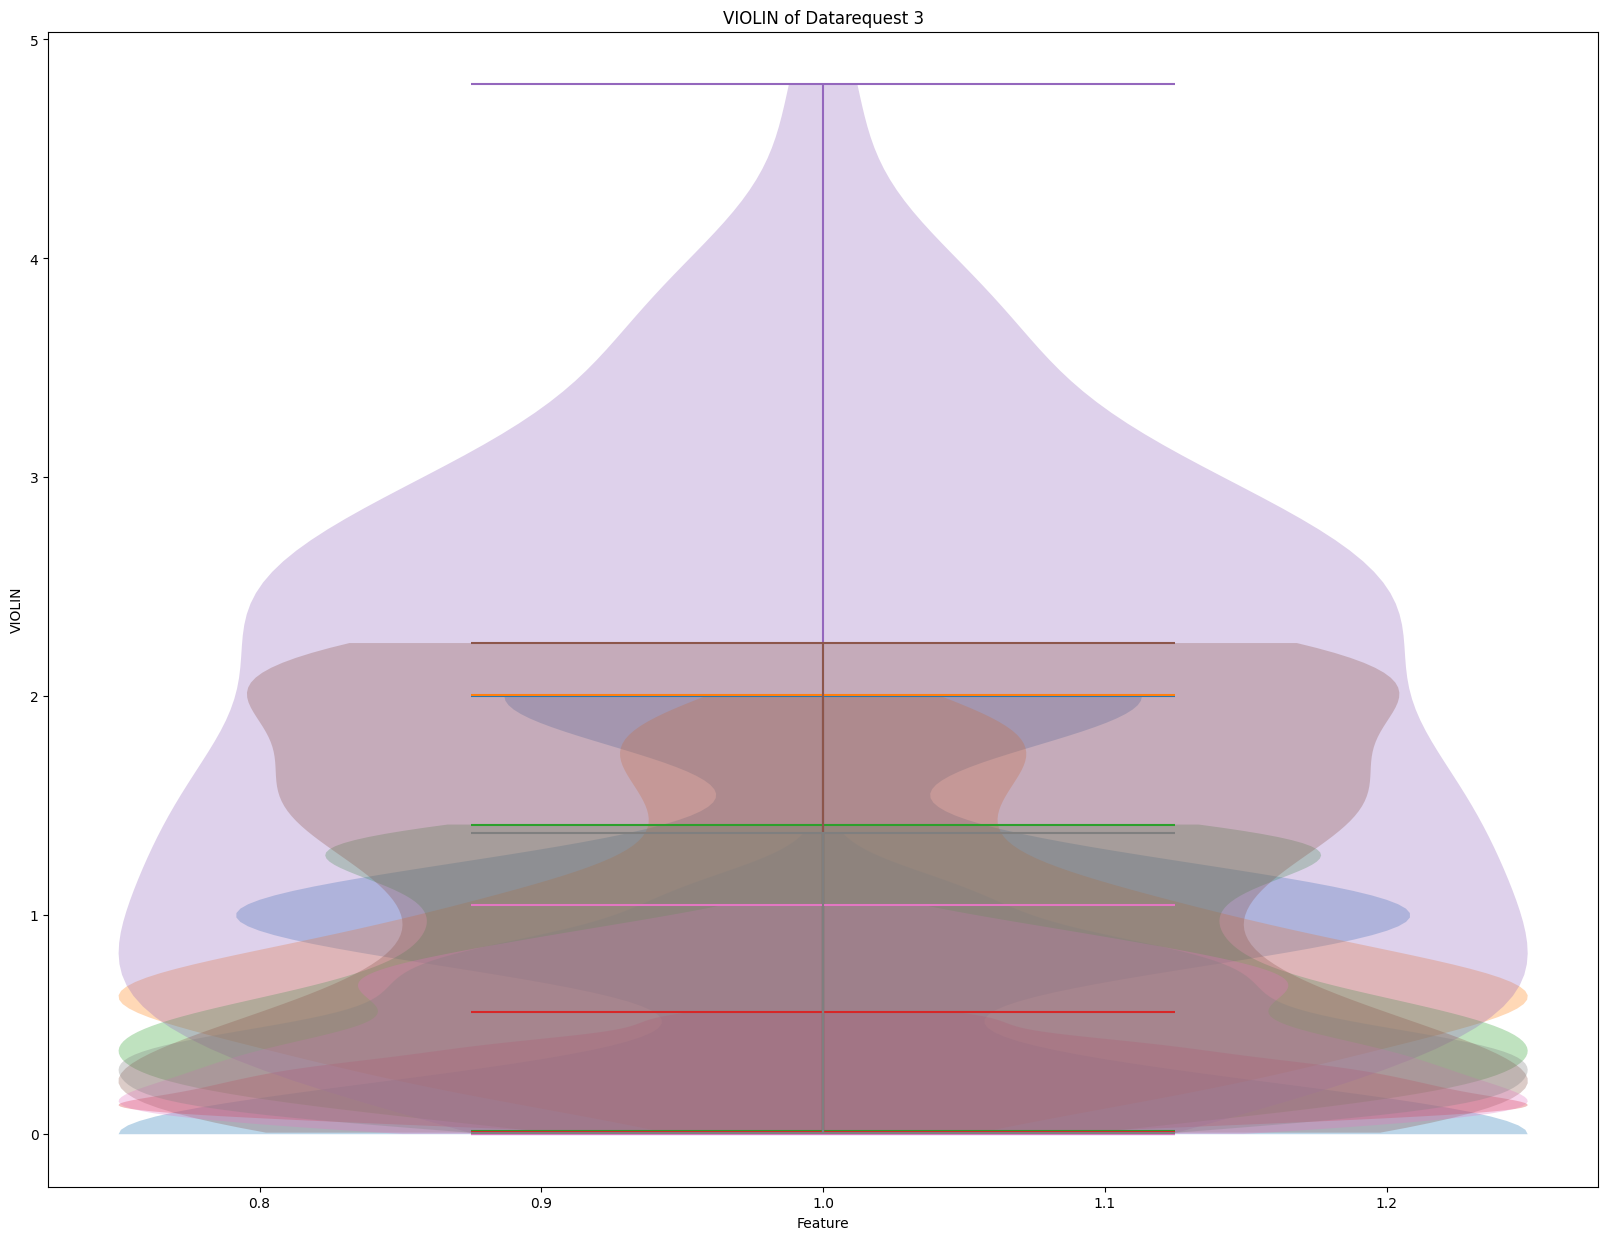

Error plotting kde


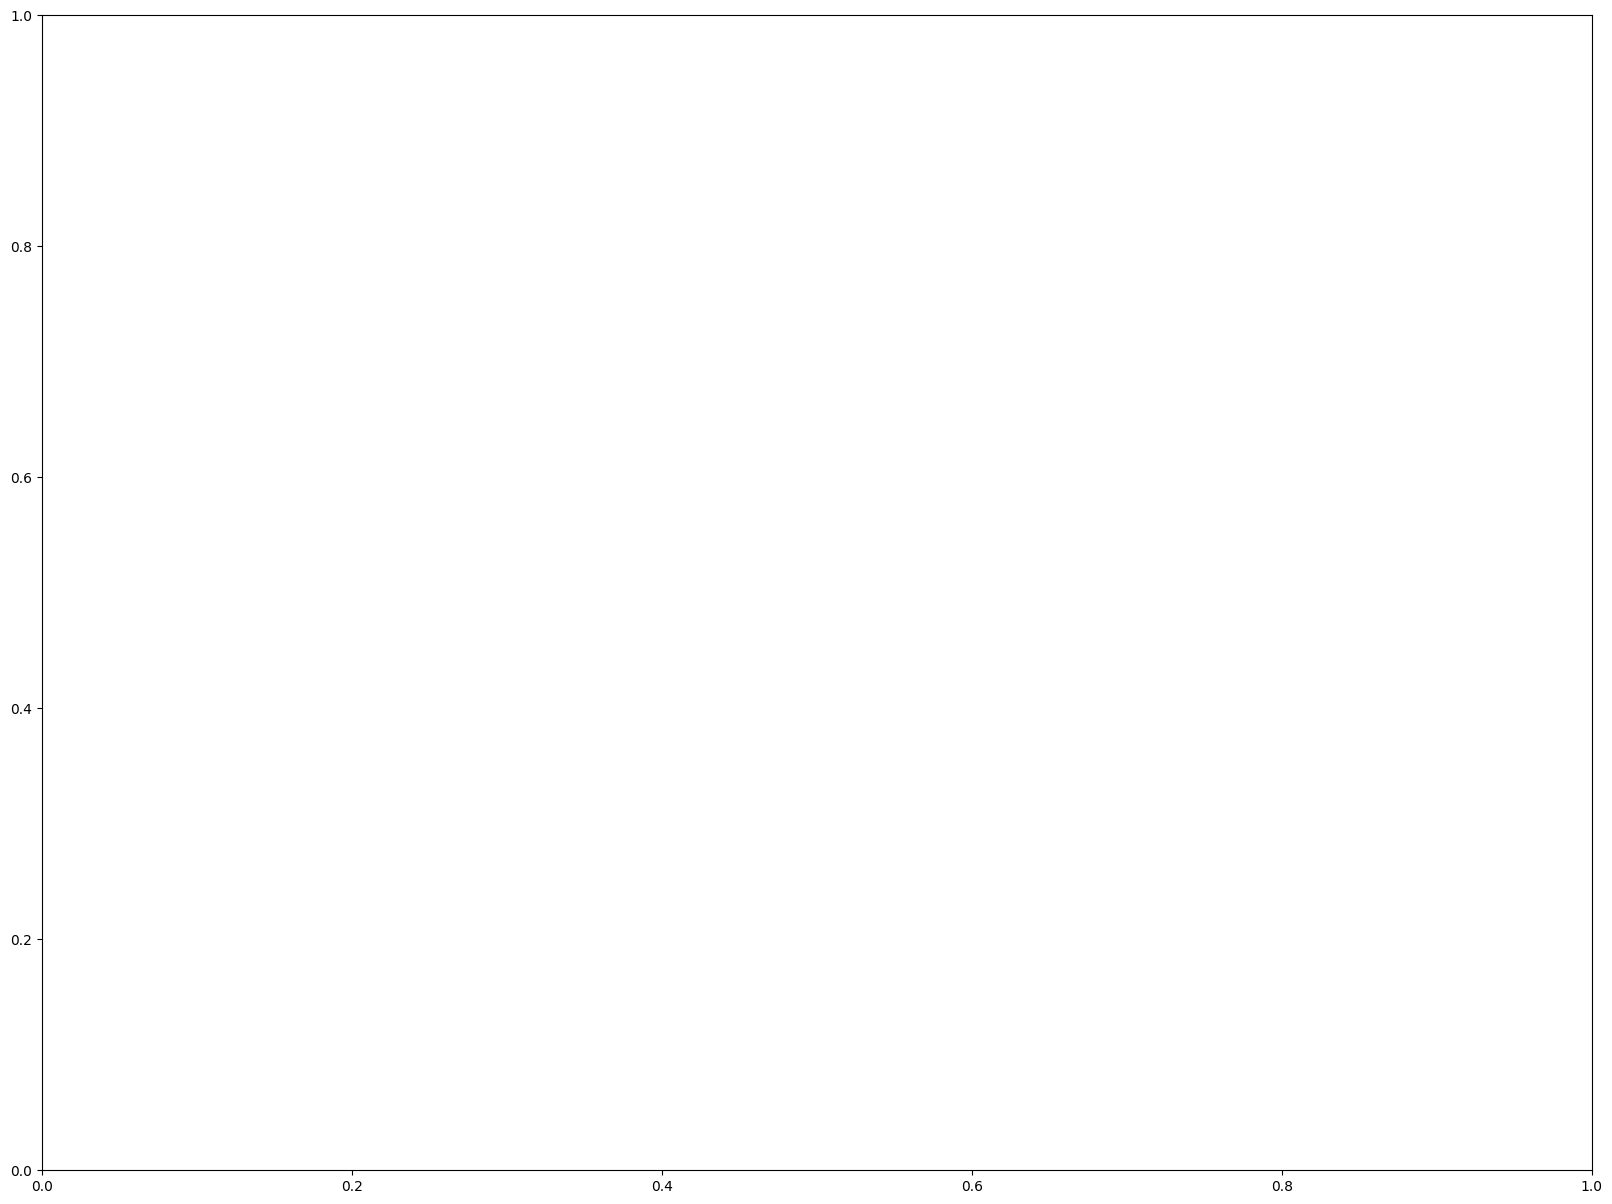

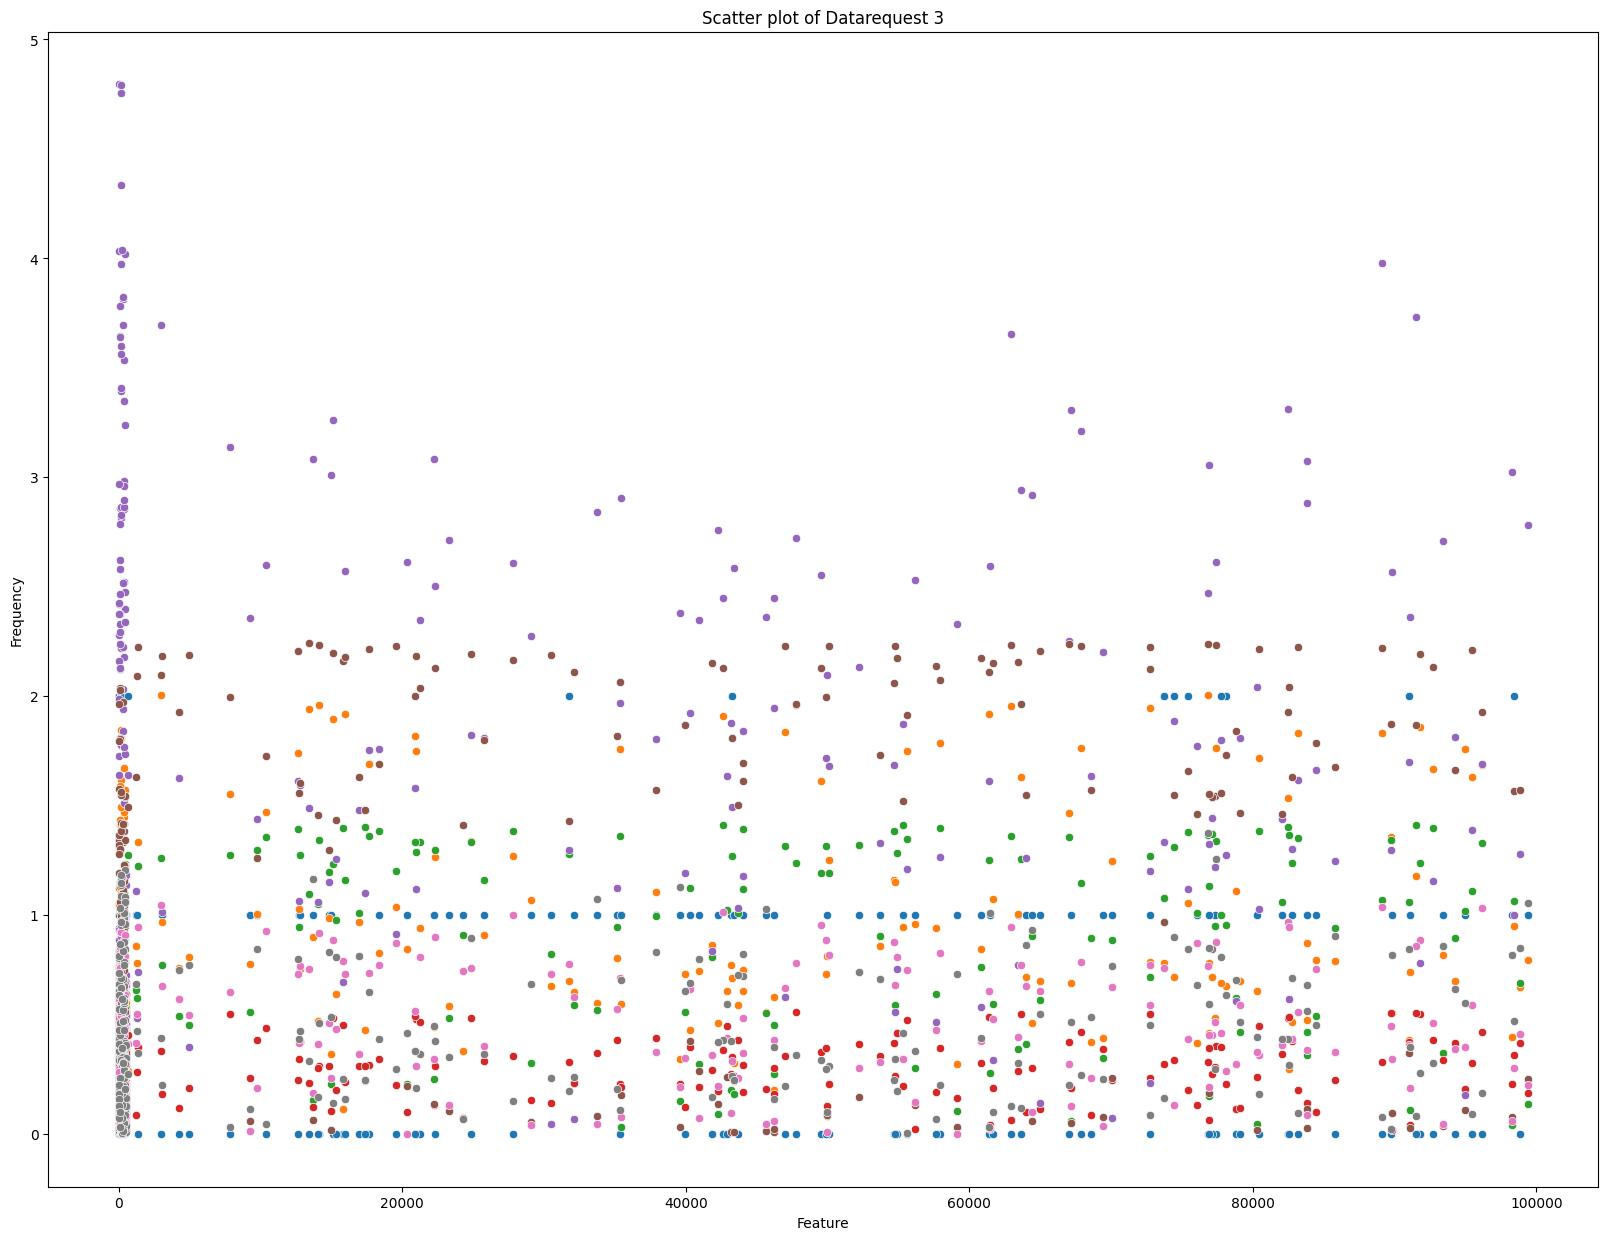

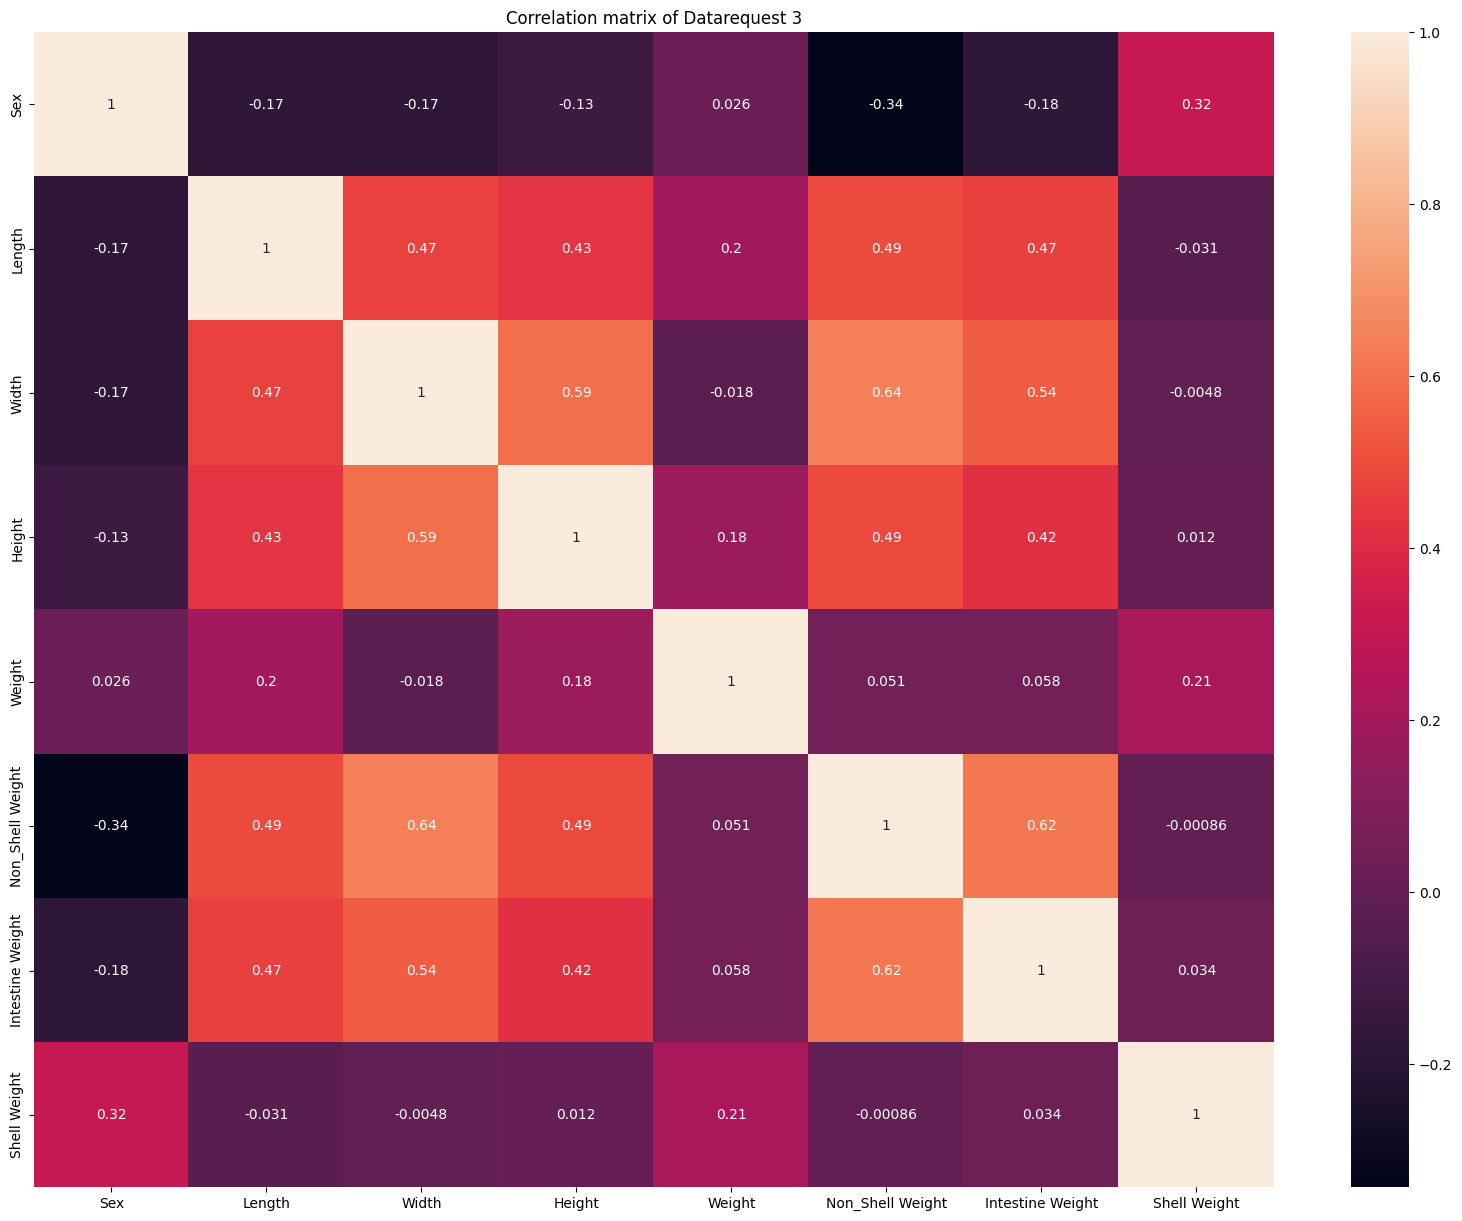

In [341]:
plot_all(data_req_period_3, "Datarequest 3")

In [342]:
data_req_period_3_decoded = decode_labels(data_req_period_3, label_encoders)
data_req_period_3_decoded.to_csv("../results/data_requests/data_req_period_3.csv", index=False)